<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np 
import keras
from keras.layers import Conv2D,MaxPooling2D,Dropout,LeakyReLU,concatenate,ZeroPadding2D,BatchNormalization,Conv2DTranspose, GlobalAveragePooling2D
from keras.layers import Add
from keras.models import Model
from keras.layers import Input, Dense
import os 
import cv2 
from matplotlib.pyplot import imshow,title ,show
from keras.applications import Xception
from keras import backend as K
from keras.losses import binary_crossentropy 
from keras.callbacks import ModelCheckpoint,Callback
from keras.optimizers import Adam, SGD
from matplotlib import pyplot as plt
import pandas as pd

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, UpSampling2D
from keras.models import Model
from keras import regularizers 
from keras.layers.normalization import BatchNormalization as bn
from keras.applications.xception import Xception
from keras.layers import LeakyReLU,Add,ZeroPadding2D
from keras.losses import binary_crossentropy
from keras import callbacks


Using TensorFlow backend.


In [ ]:
img_size = 768
model = UXception(input_shape=(img_size,img_size,3))

In [2]:
! nvidia-smi

Mon Nov  9 11:09:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   37C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   30C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
from scipy.spatial import distance
def dice_score(true,pred):
    return 1-(distance.dice(true.ravel(),pred.ravel()))

In [4]:
def weighted_crossentropy(y_true, y_pred):

    y_pred_f = K.reshape(y_pred, (batch_size*img_deps*img_rows,3))
    y_true_f = K.reshape(y_true, (batch_size*img_deps*img_rows,2))

    soft_pred_f = K.softmax(y_pred_f)
    soft_pred_f = K.log(tf.clip_by_value(soft_pred_f, 1e-10, 1.0))

    neg = K.equal(y_true_f, K.zeros_like(y_true_f))
    neg_calculoss = tf.gather(soft_pred_f[:,0], tf.where(neg))

    pos1 = K.equal(y_true_f, K.ones_like(y_true_f))
    pos1_calculoss = tf.gather(soft_pred_f[:,1], tf.where(pos1))

    pos2 = K.equal(y_true_f, 2*K.ones_like(y_true_f))
    pos2_calculoss = tf.gather(soft_pred_f[:,2], tf.where(pos2))

    loss = -K.mean(tf.concat([0.78*neg_calculoss, 0.65*pos1_calculoss, 8.57*pos2_calculoss], 0))

    return loss

def dice_loss(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred)+dice_loss(y_true, y_pred))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

In [5]:
def attach_attention_module(net, attention_module):
    if attention_module == 'se_block': # SE_block
        net = se_block(net)
    elif attention_module == 'cbam_block': # CBAM_block
        net = cbam_block(net)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_module))

    return net

def se_block(input_feature, ratio=8):
    """Contains the implementation of Squeeze-and-Excitation(SE) block.
    As described in https://arxiv.org/abs/1709.01507.
    """
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]

    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    assert se_feature._keras_shape[1:] == (1,1,channel)
    se_feature = Dense(channel // ratio,
                       activation='relu',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature._keras_shape[1:] == (1,1,channel//ratio)
    se_feature = Dense(channel,
                       activation='sigmoid',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature._keras_shape[1:] == (1,1,channel)
    if K.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)

    se_feature = multiply([input_feature, se_feature])
    return se_feature

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._keras_shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._keras_shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._keras_shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._keras_shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat) 
    assert cbam_feature._keras_shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])



def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    #x = attach_attention_module(x,attention_module='cbam_block')
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    x = attach_attention_module(x,attention_module='cbam_block')
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    #x = attach_attention_module(x,attention_module='cbam_block')
    return x

def UXception(input_shape=(None, None, 3),dropout_rate=0.5):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(dropout_rate)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [7]:
x_train=np.load('./Numpy/float_x_unet_train.npy', mmap_mode='r')
y_train=np.load('./Numpy/float_y_unet_train.npy', mmap_mode='r')

x_val=np.load('./Numpy/float_x_unet_val.npy', mmap_mode='r')
y_val=np.load('./Numpy/float_y_unet_val.npy', mmap_mode='r')

In [8]:
print (x_train.shape, y_train.shape)
print (x_val.shape, y_val.shape)

(5500, 768, 768, 3) (5500, 768, 768, 1)
(1264, 768, 768, 3) (1264, 768, 768, 1)


x_train_2=np.zeros(x_train.shape, dtype='float16')
for idx, i in enumerate(x_train):
    x_train_2[idx]=i.astype('float16')/255
    print (idx)
print (x_train_2[0])

x_val_2=np.zeros(x_val.shape, dtype='float16')
for idx, i in enumerate(x_val):
    x_val_2[idx]=i.astype('float16')/255
    print (idx)
print (x_val_2[0])

y_train=y_train.astype('float16')/255
y_val=y_val.astype('float16')/255

y_train=np.expand_dims(y_train,axis=-1)
y_val=np.expand_dims(y_val,axis=-1)

y_train[y_train>0.]=1
y_val[y_val>0.]=1

In [9]:
np.unique(y_val)

array([0., 1.], dtype=float16)

In [17]:
img_size = 768
model = UXception(input_shape=(img_size,img_size,3))

NameError: name 'GlobalMaxPooling2D' is not defined

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau,CSVLogger,ModelCheckpoint

adam=Adam(lr=1e-4)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy',dice_coef])

model_checkpoint = ModelCheckpoint(
        os.path.join('./Weights/', 'UNET_attention_tb.hdf5'),
        monitor='val_loss', mode='min',save_best_only=True, verbose=1)

#Callback for reducing learning rate based on validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, verbose=1, min_lr=1e-6)

#Callback for storing logs of learning rate, loss and accuracy
csvlogger=CSVLogger('./CSV/logs_from_scratch_adam_tb.csv')

callbacks = [model_checkpoint,reduce_lr,csvlogger]

In [18]:
model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=150,verbose=1,callbacks=callbacks,batch_size=2, shuffle=True)

NameError: name 'model' is not defined

In [6]:
model.load_weights('./Weights/segmentation-Copy1.hdf5')

In [7]:
op2=model.predict(x_val_2,verbose=1,batch_size=2)

1264/1264 [==============================] - 194s 153ms/step


In [11]:
len(x_val)

1264

0


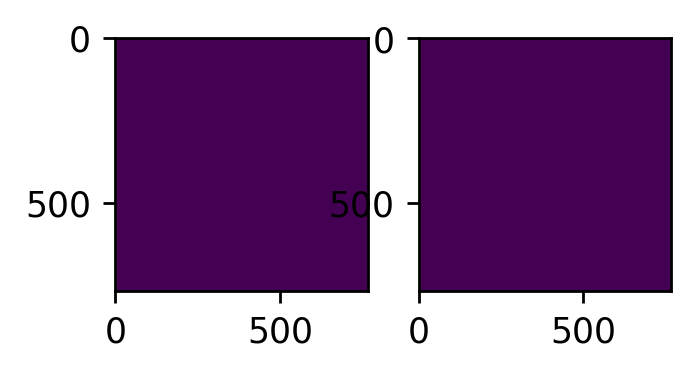

1


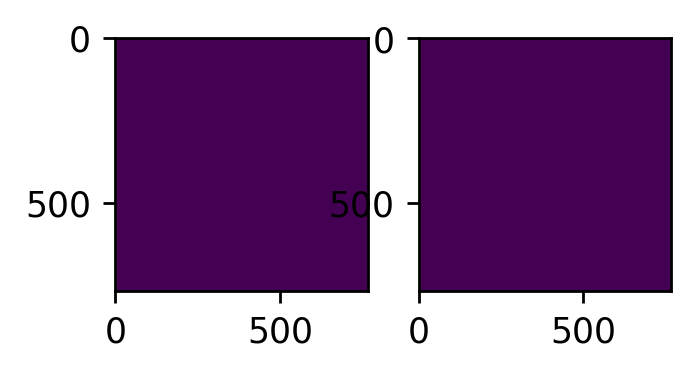

2


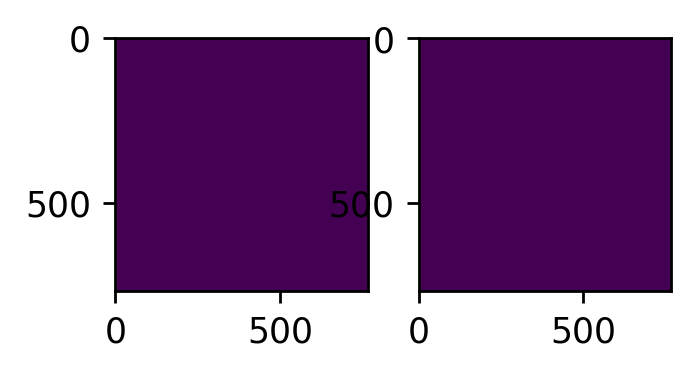

3


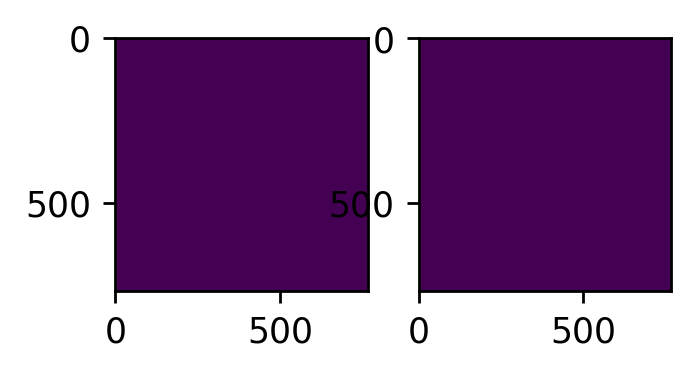

4


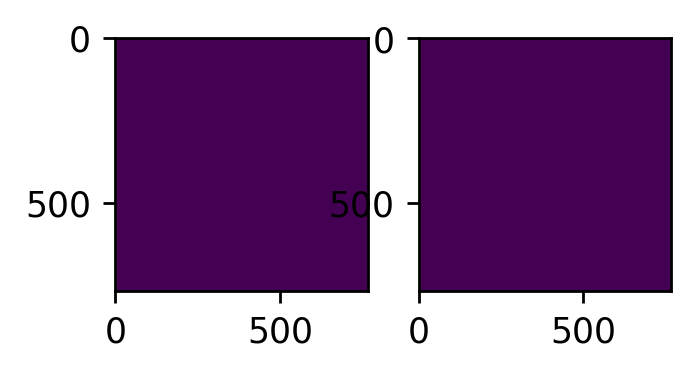

5


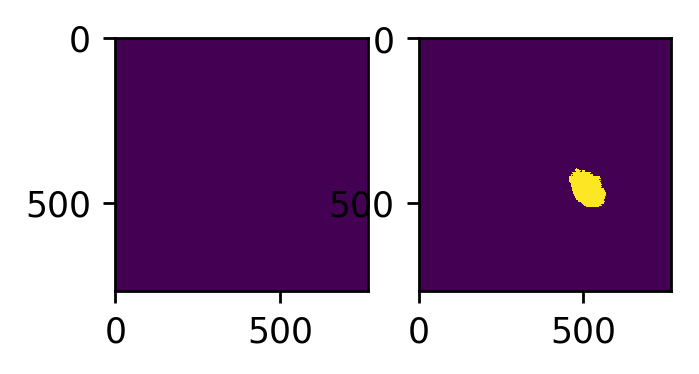

6


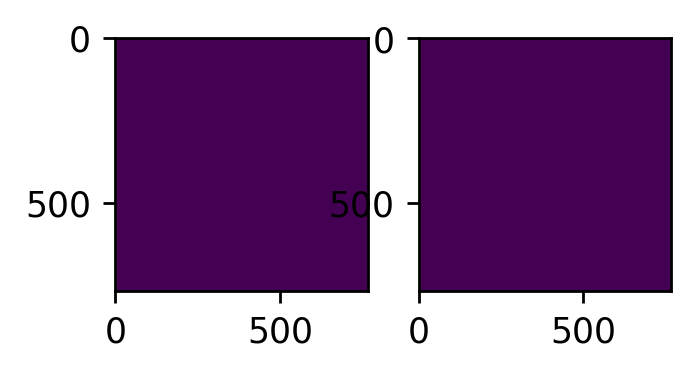

7


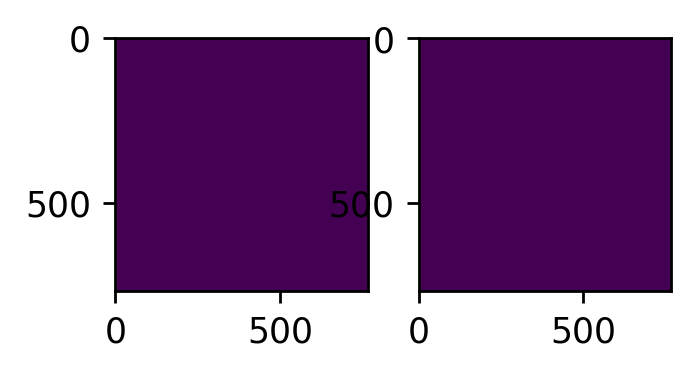

8


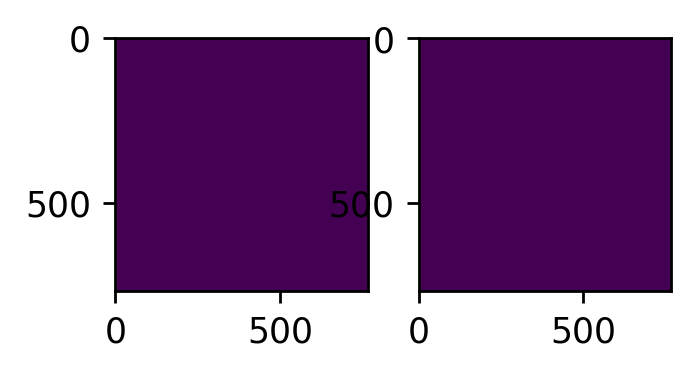

9


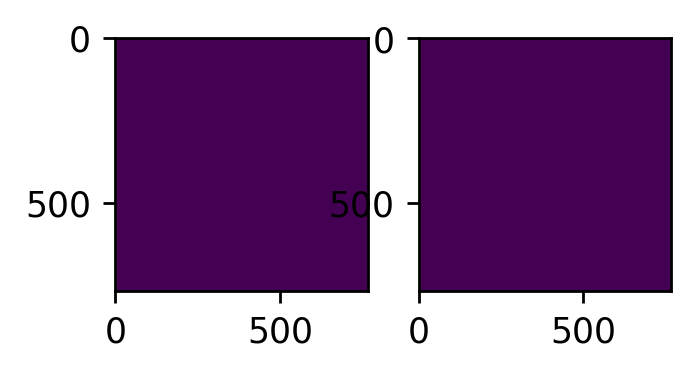

10


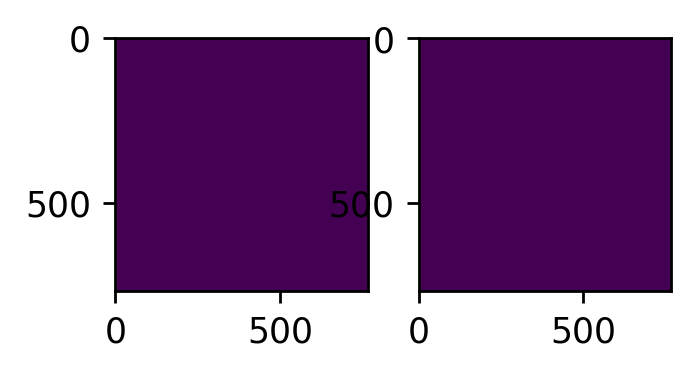

11


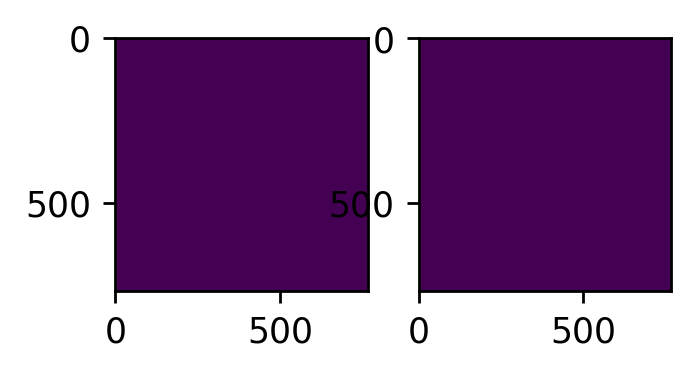

12


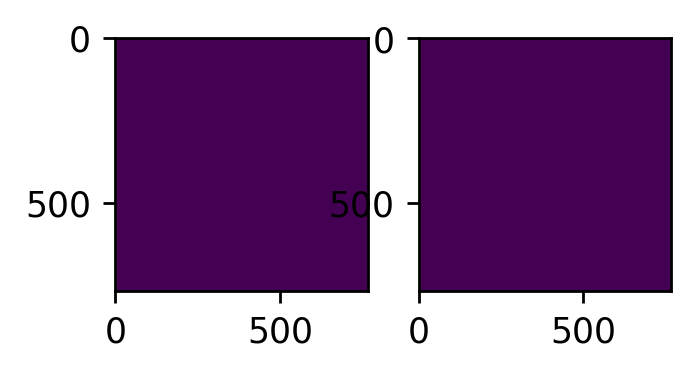

13


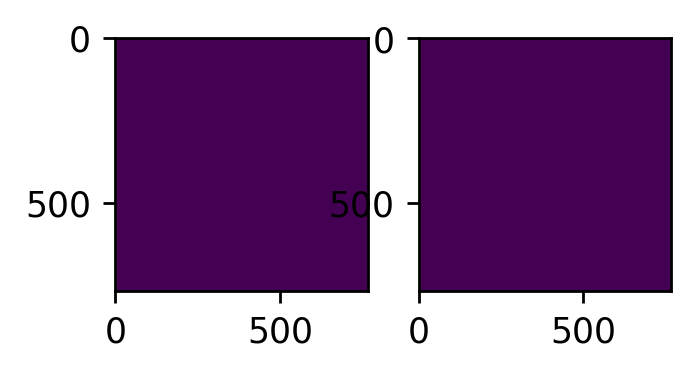

14


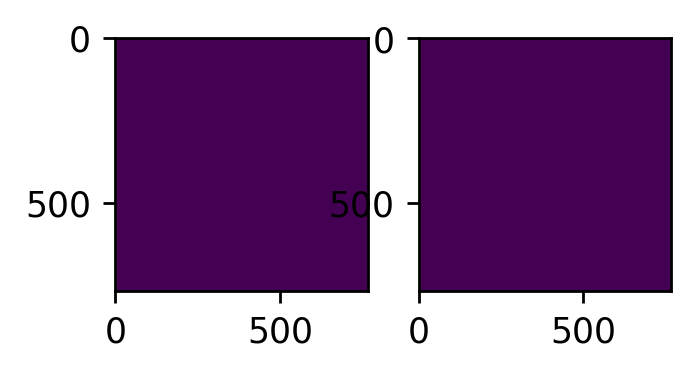

15


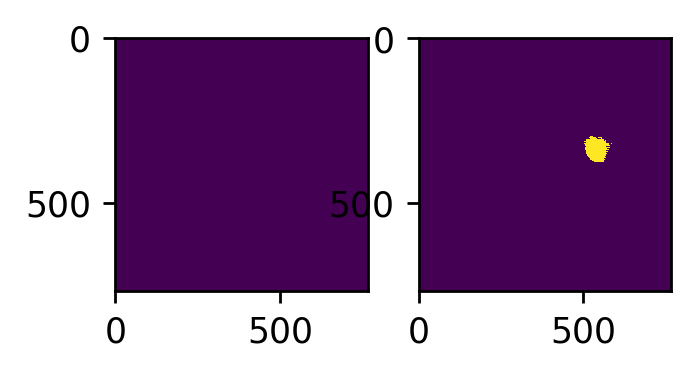

16


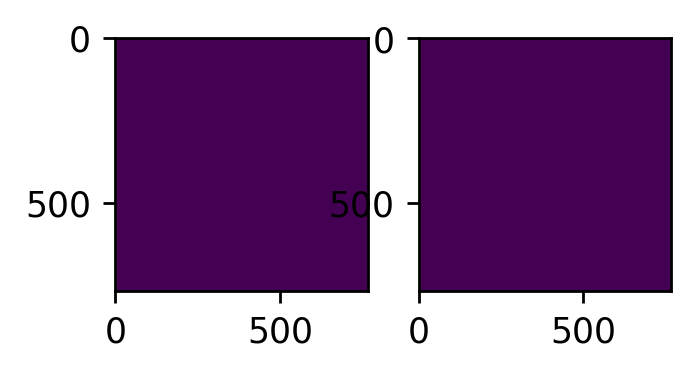

17


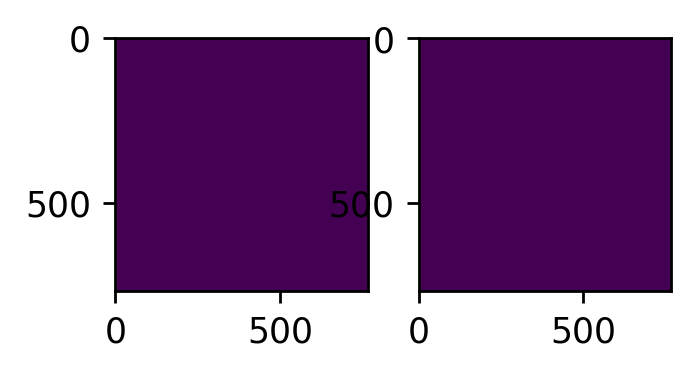

18


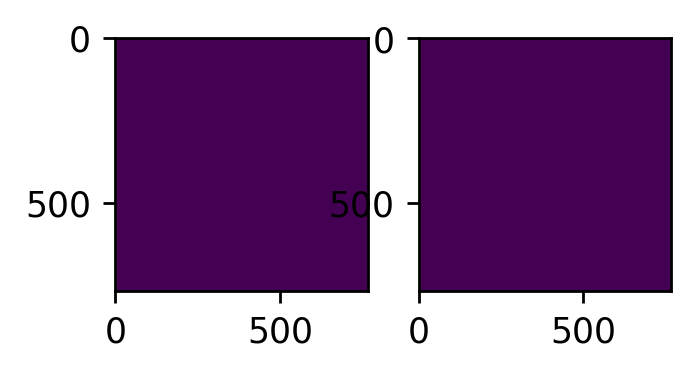

19


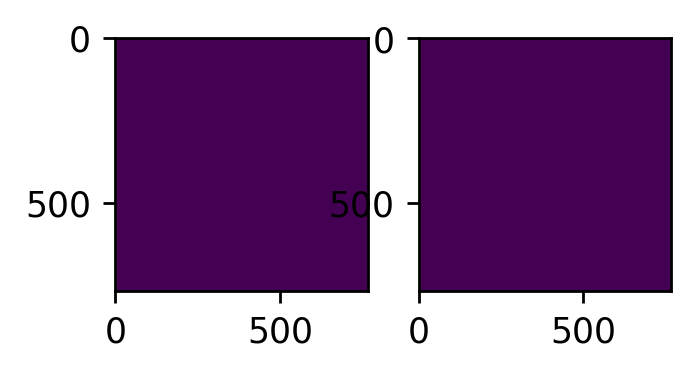

20


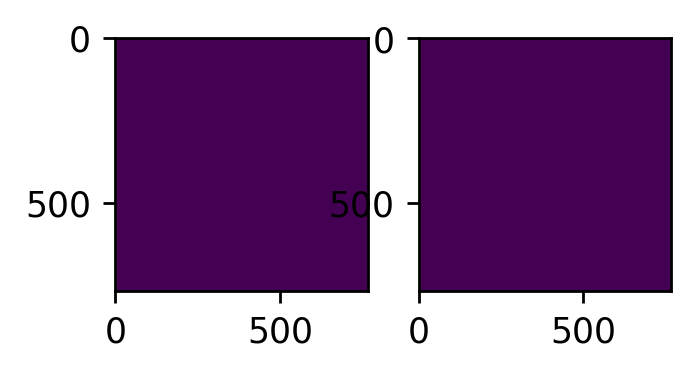

21


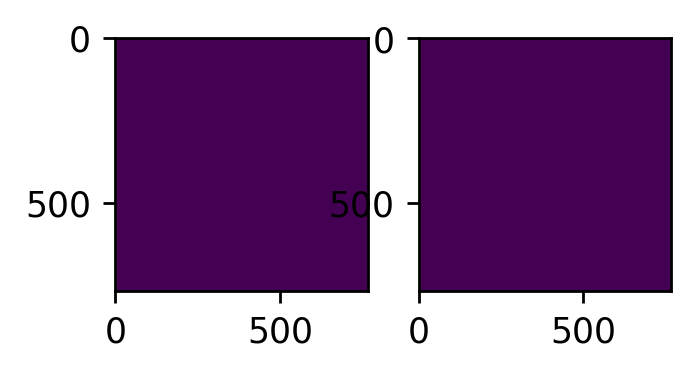

22


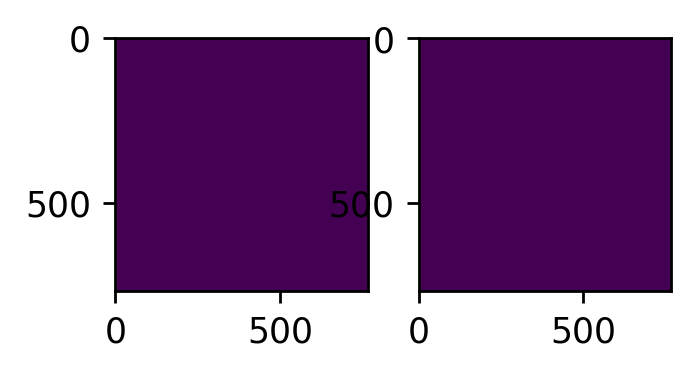

23


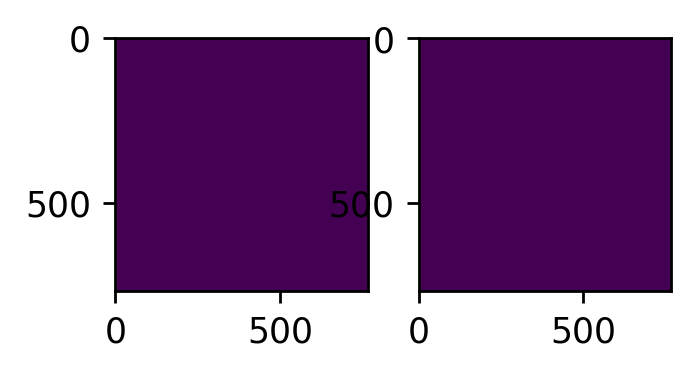

24


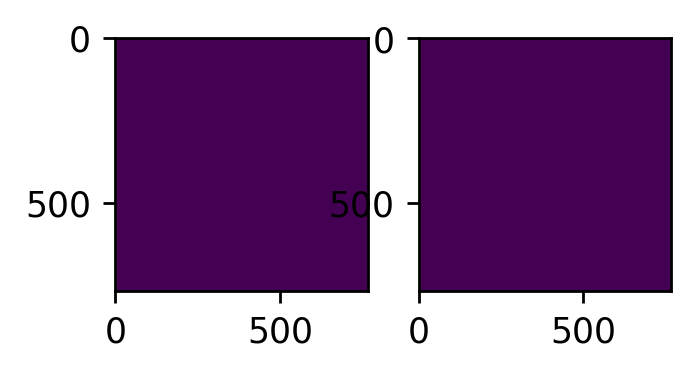

25


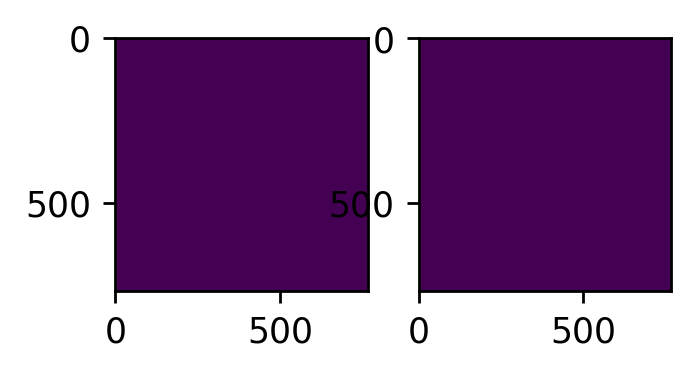

26


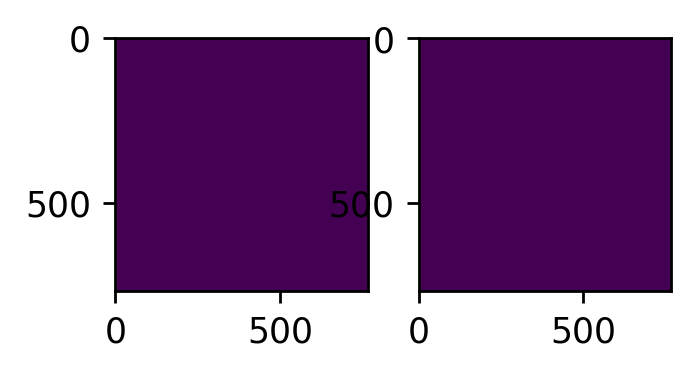

27


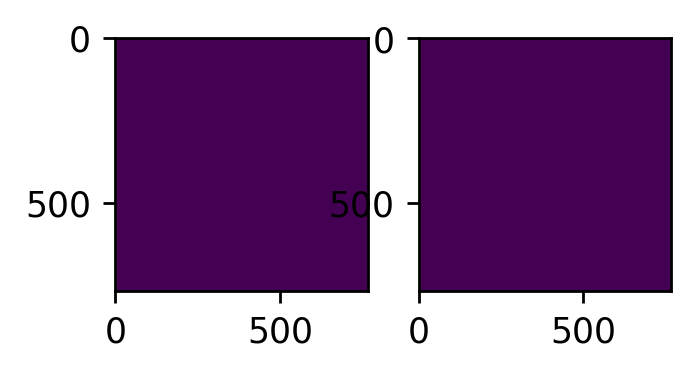

28


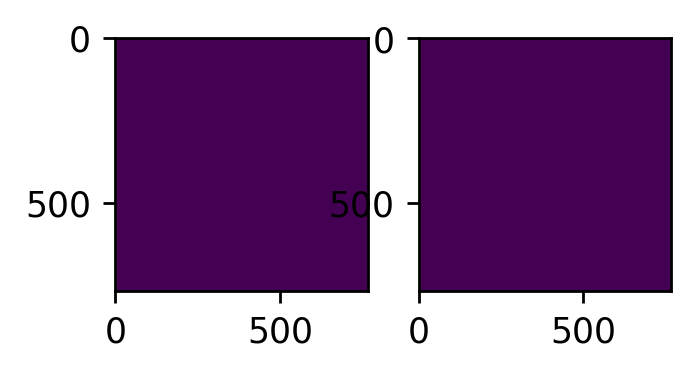

29


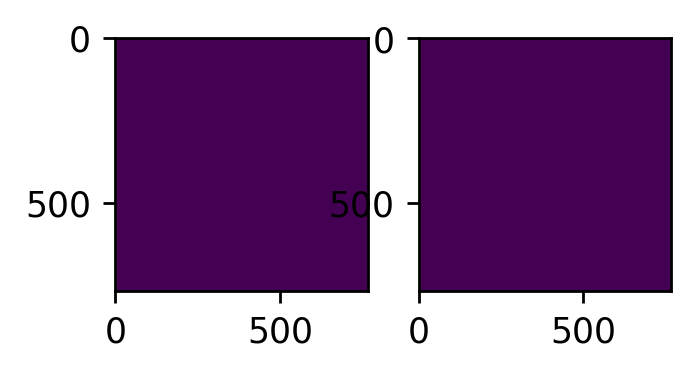

30


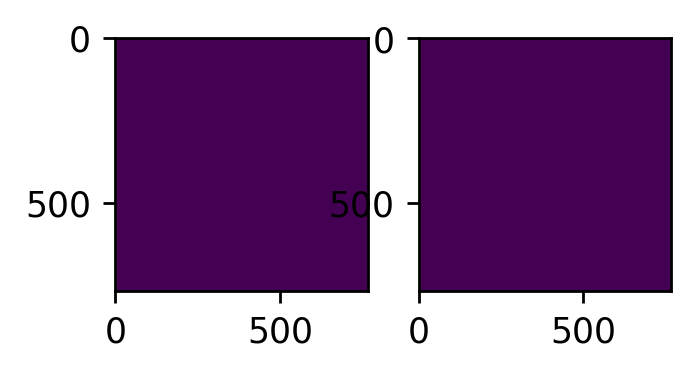

31


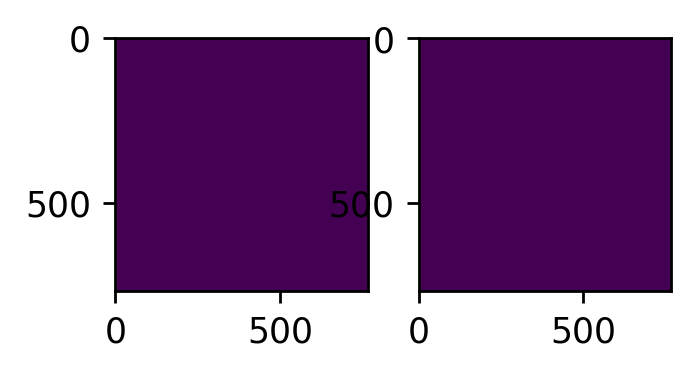

32


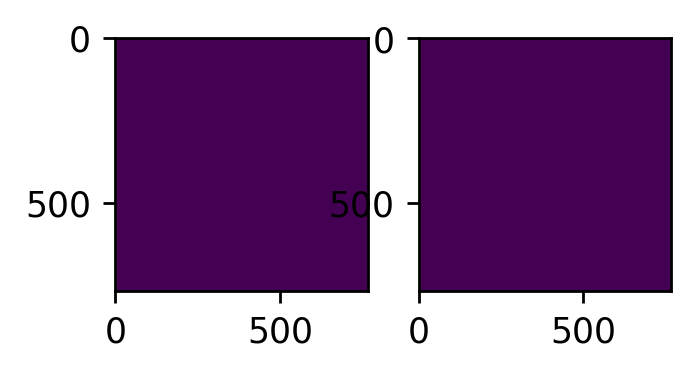

33


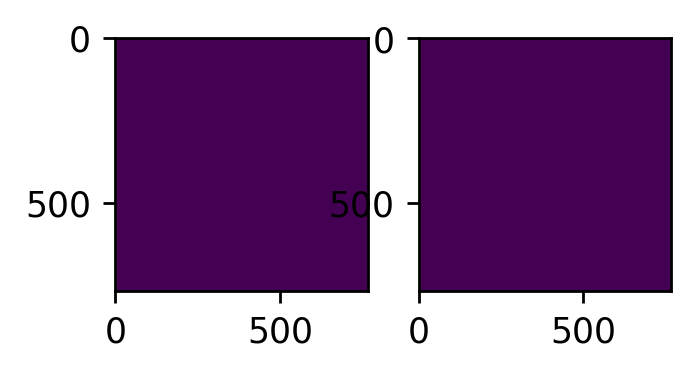

34


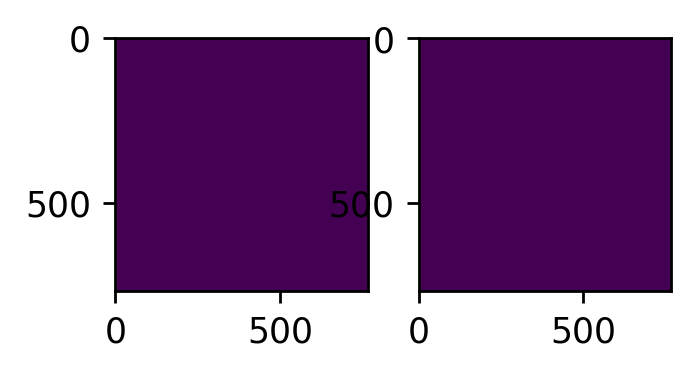

35


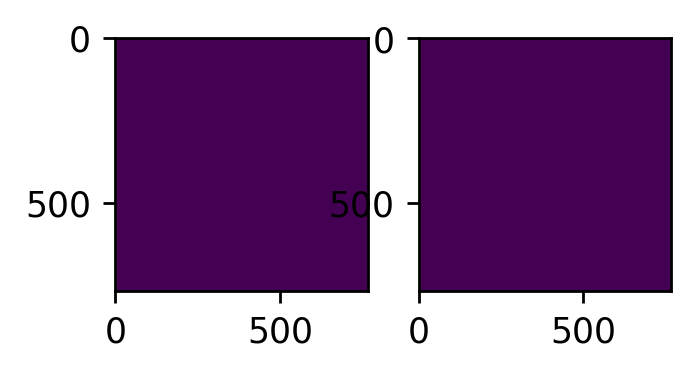

36


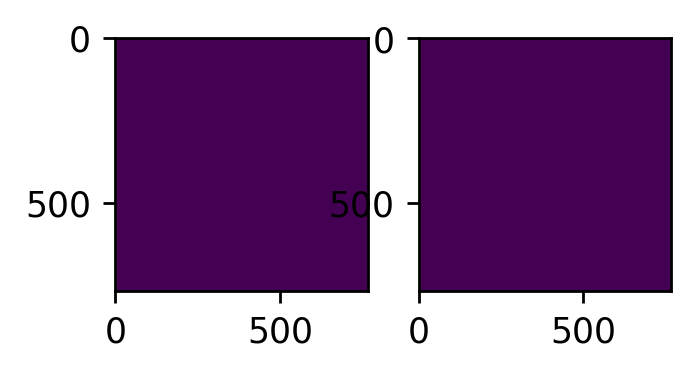

37


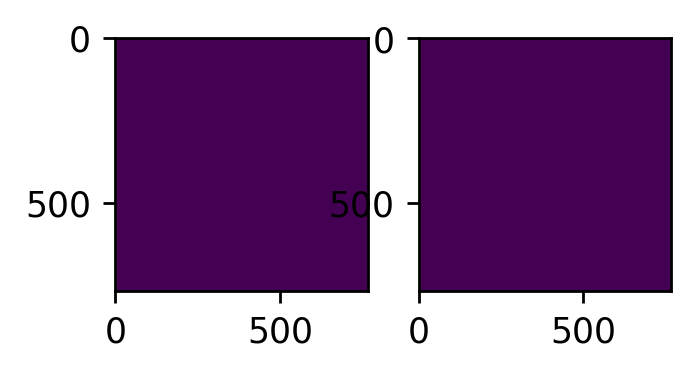

38


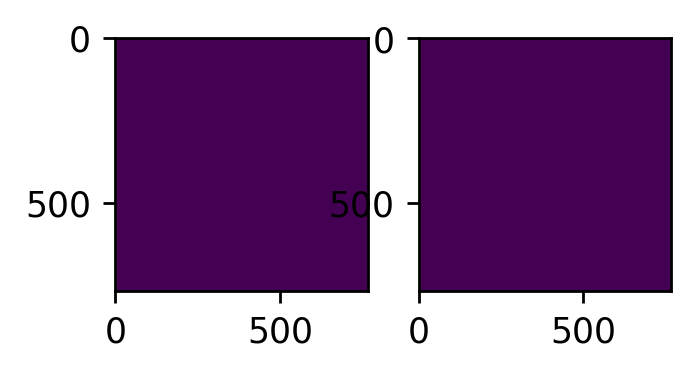

39


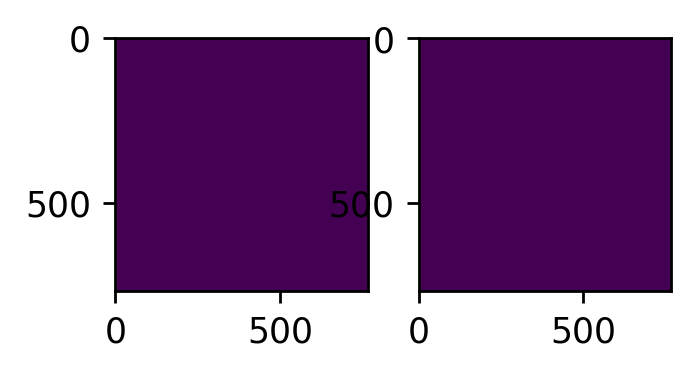

40


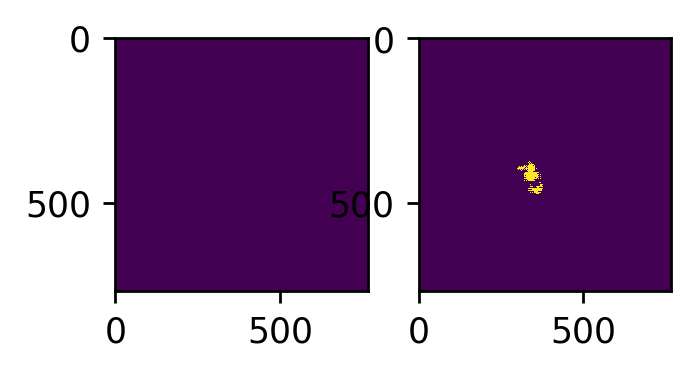

41


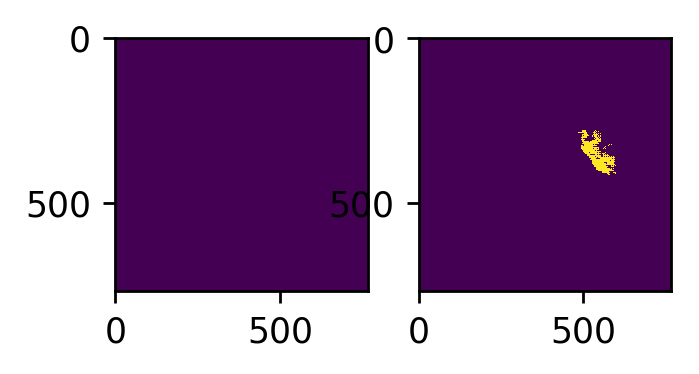

42


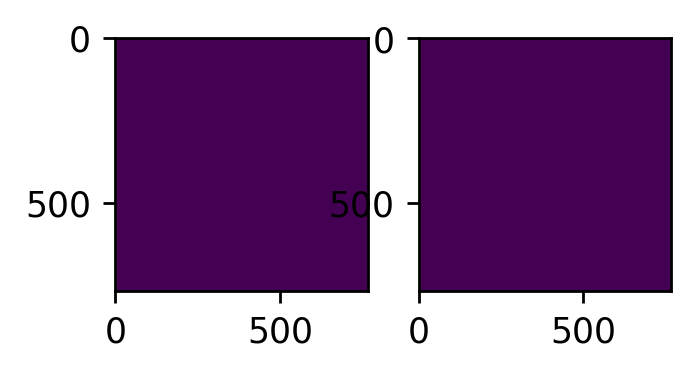

43


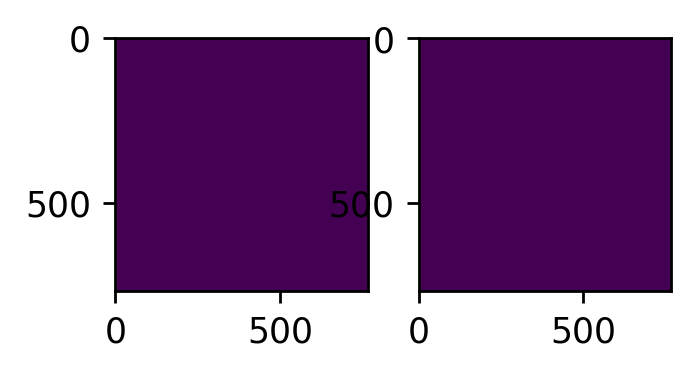

44


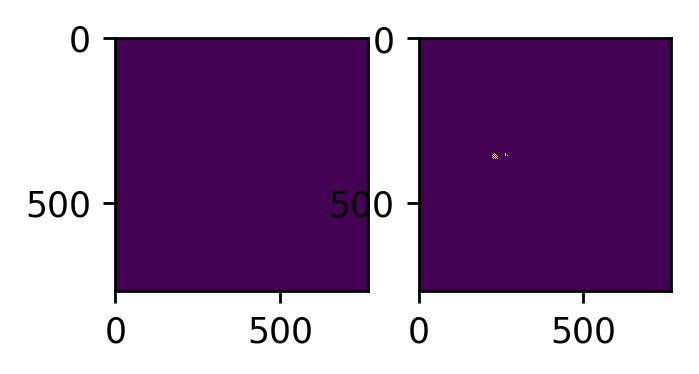

45


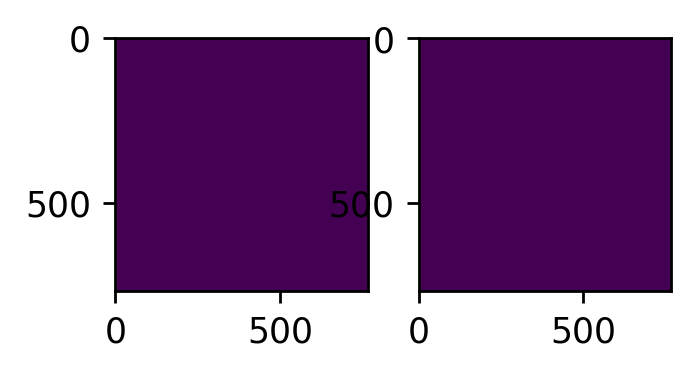

46


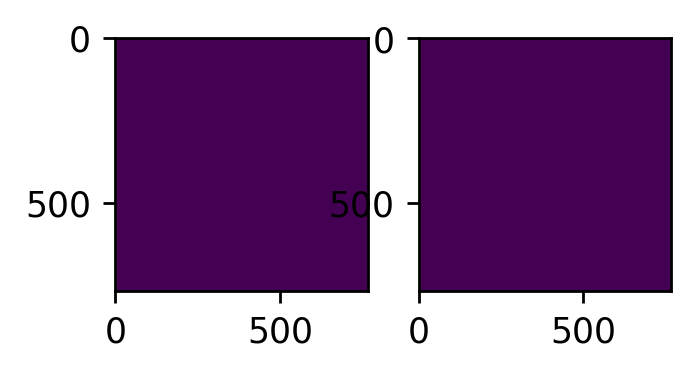

47


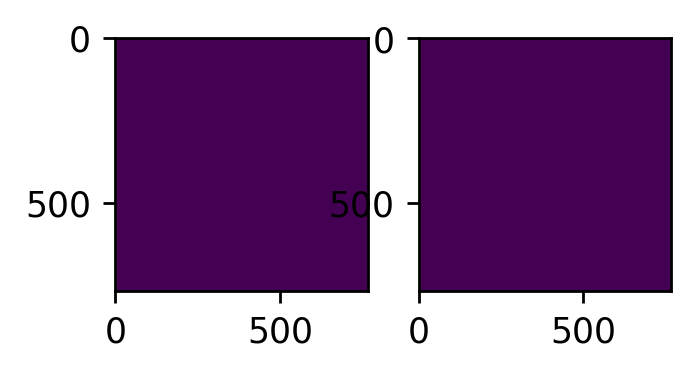

48


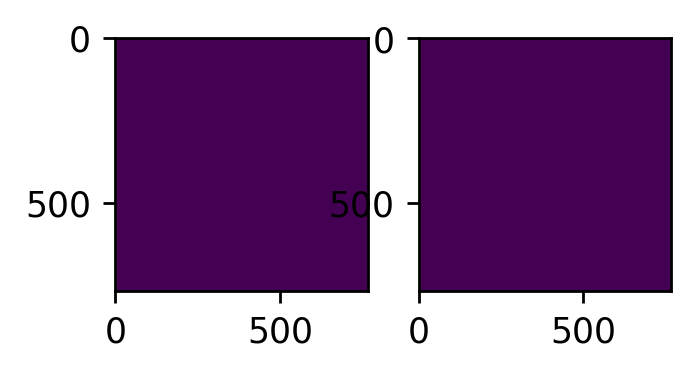

49


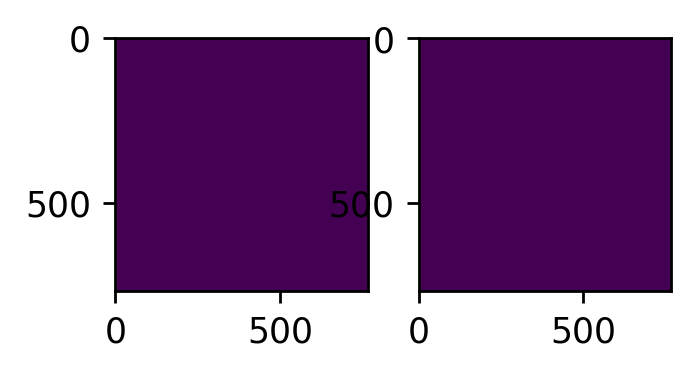

50


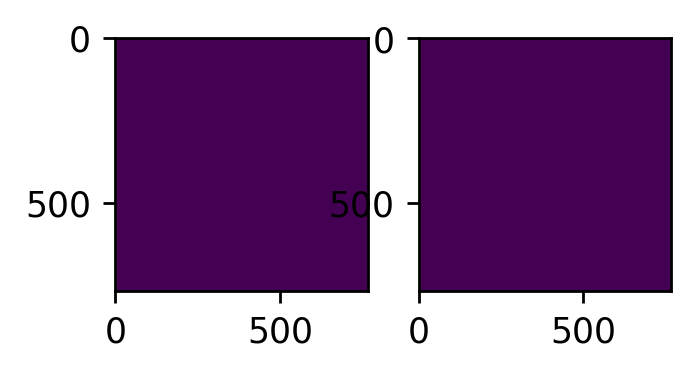

51


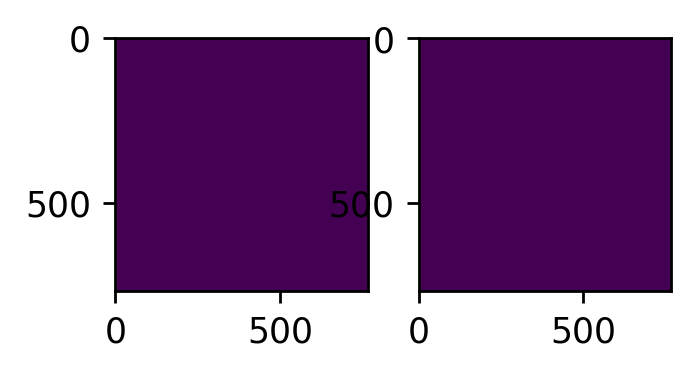

52


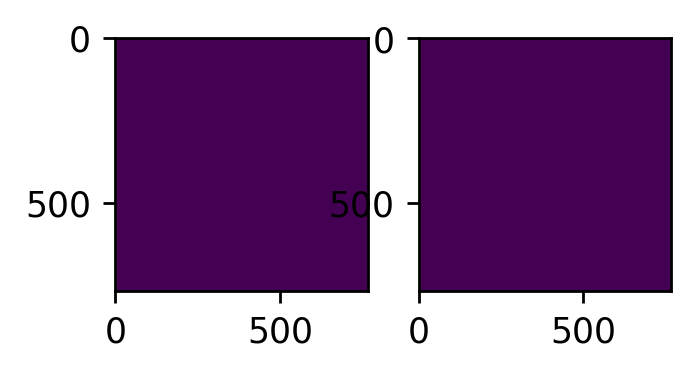

53


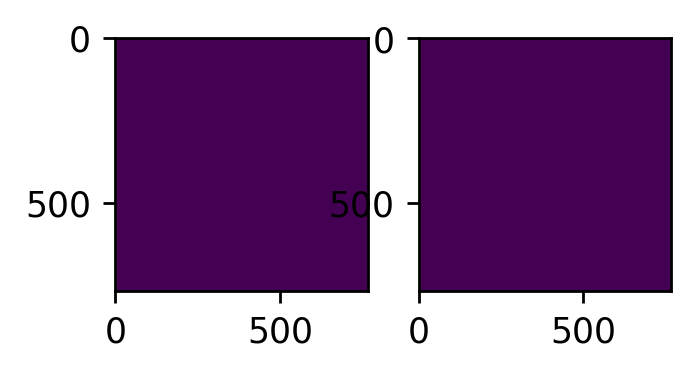

54


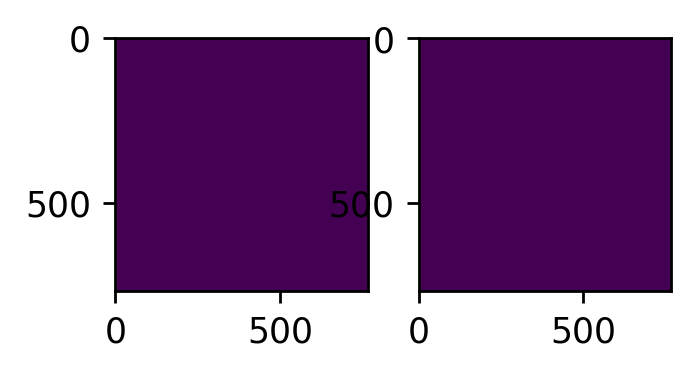

55


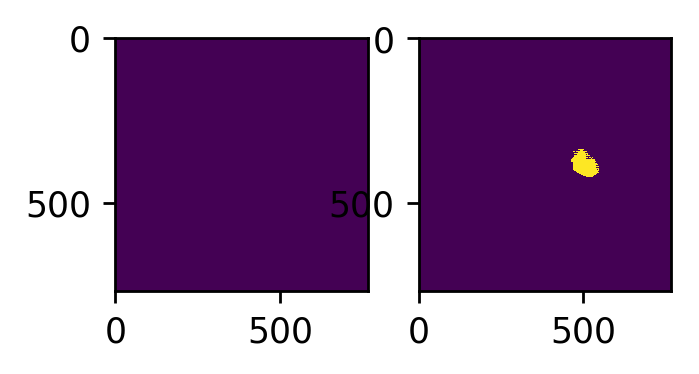

56


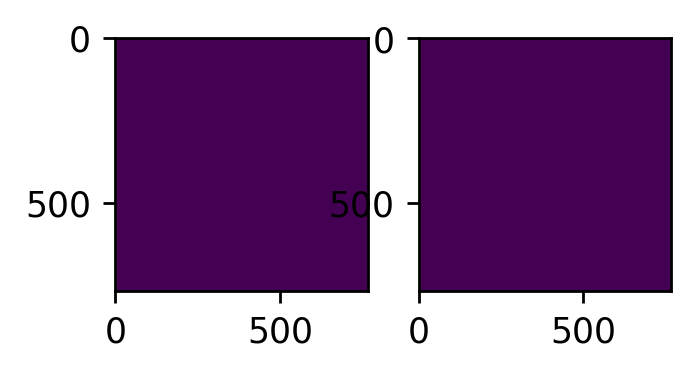

57


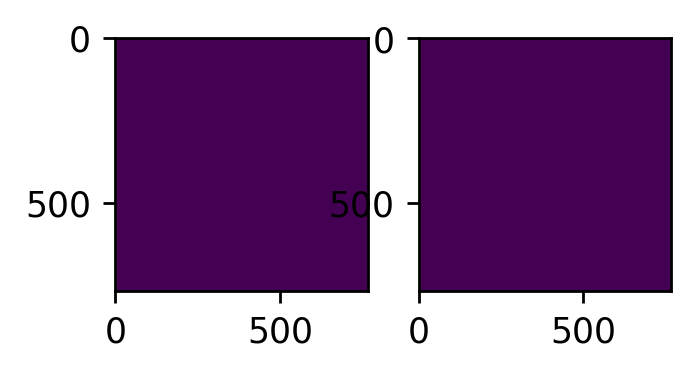

58


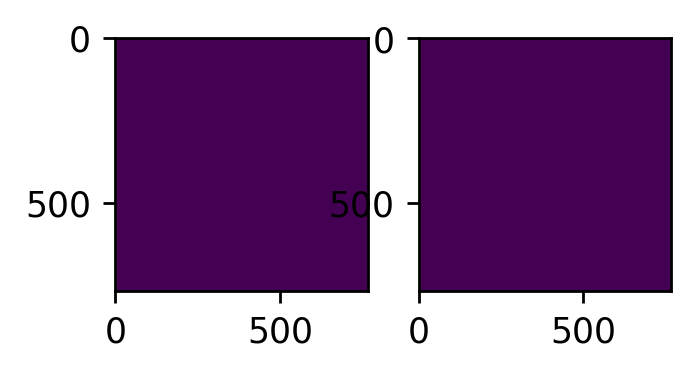

59


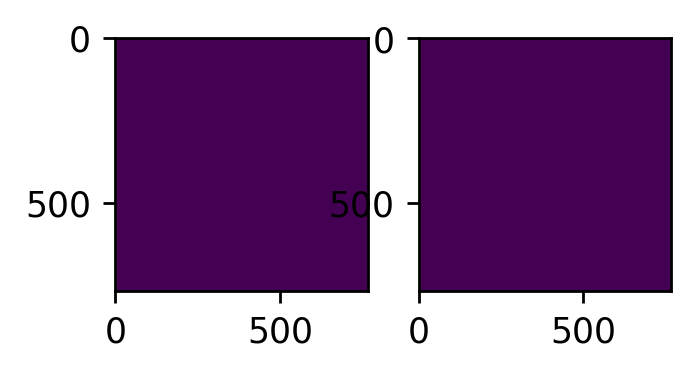

60


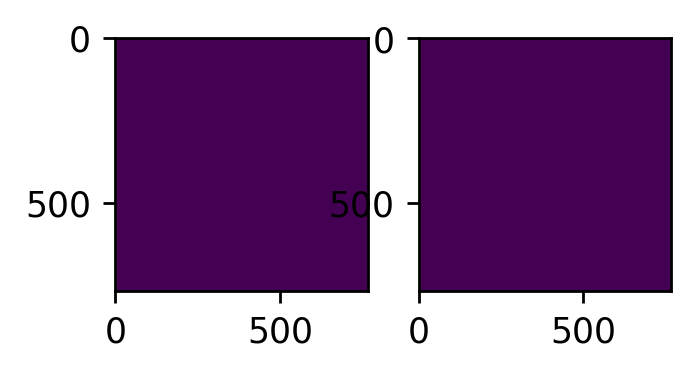

61


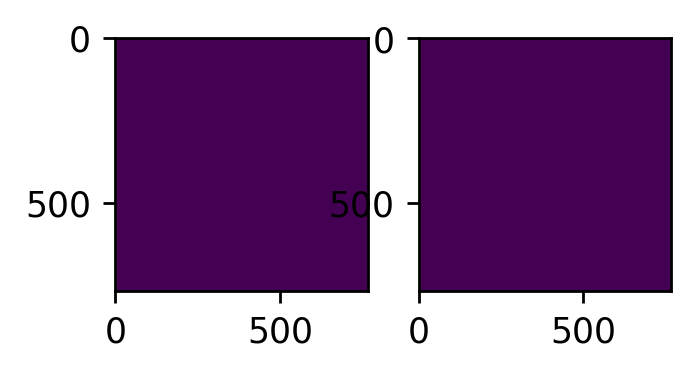

62


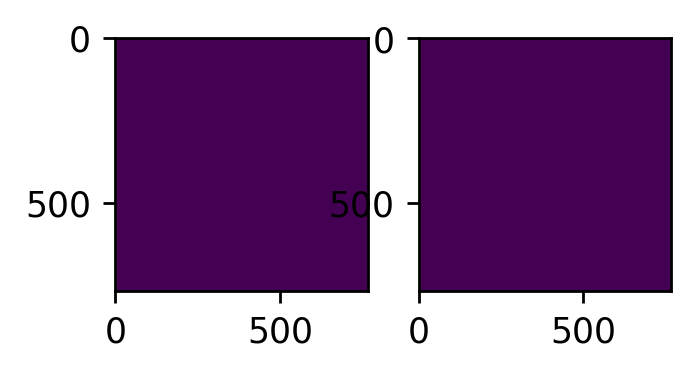

63


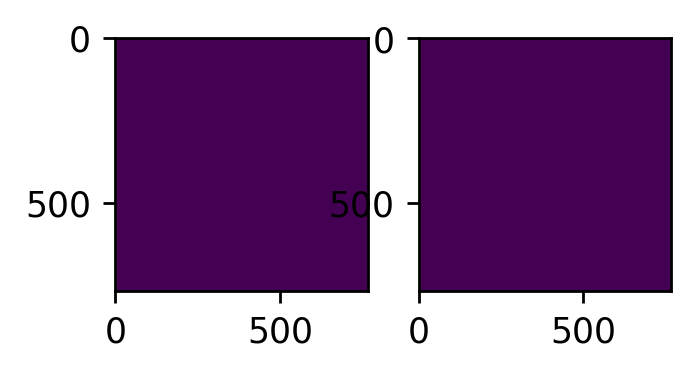

64


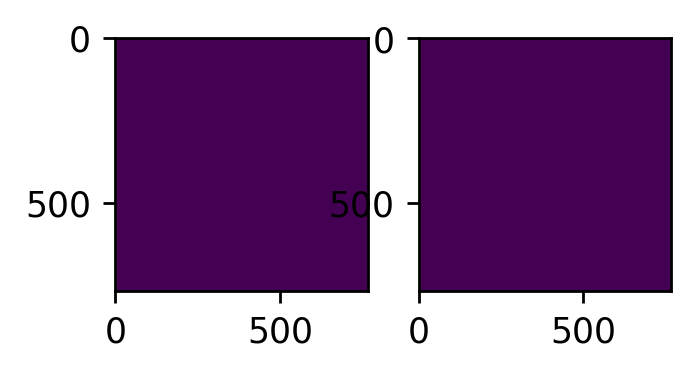

65


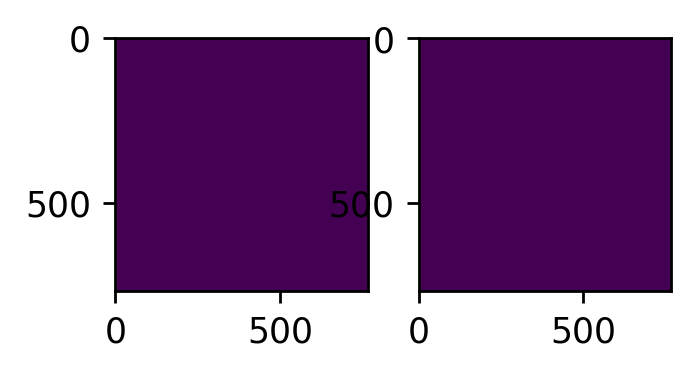

66


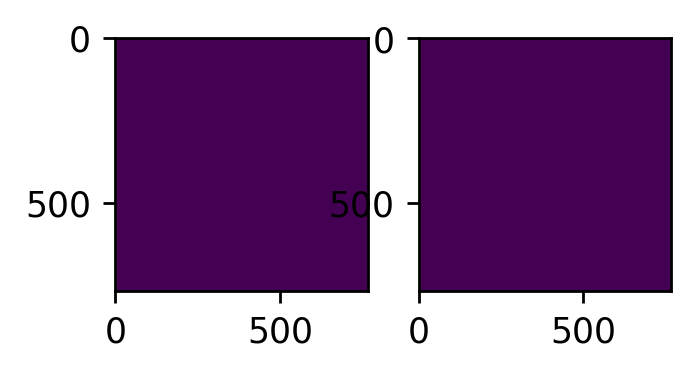

67


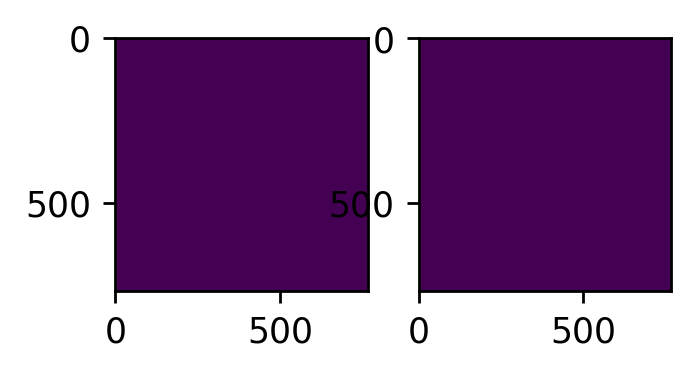

68


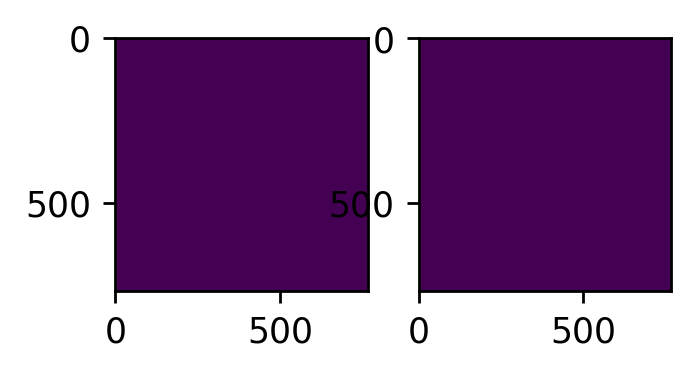

69


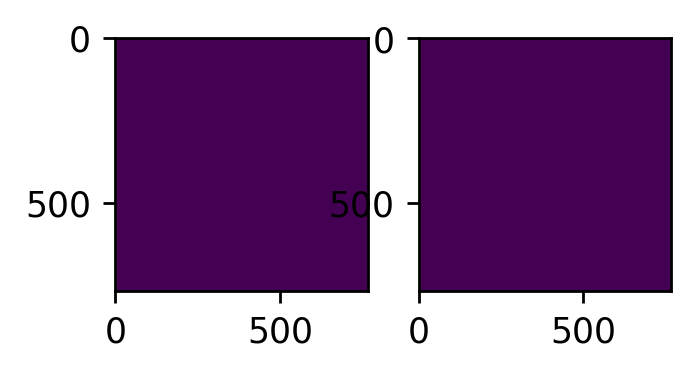

70


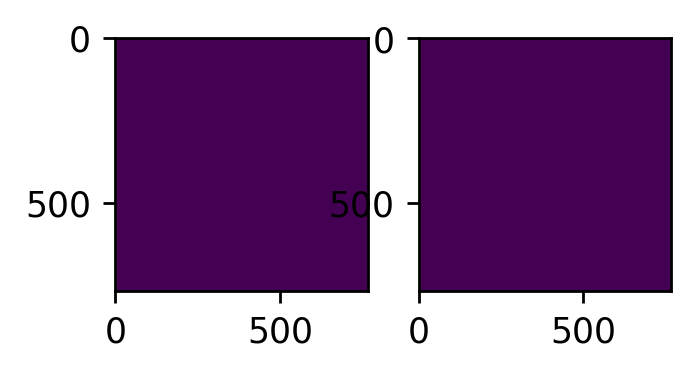

71


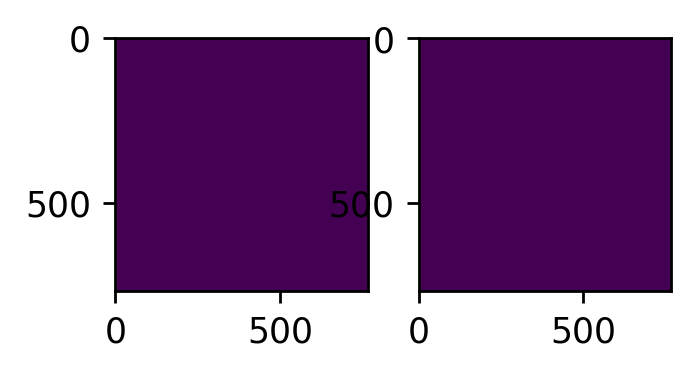

72


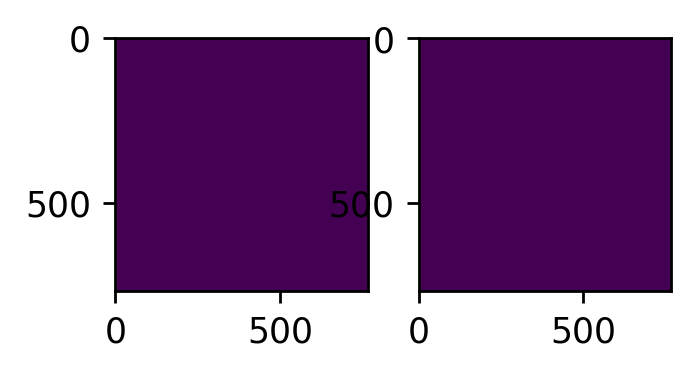

73


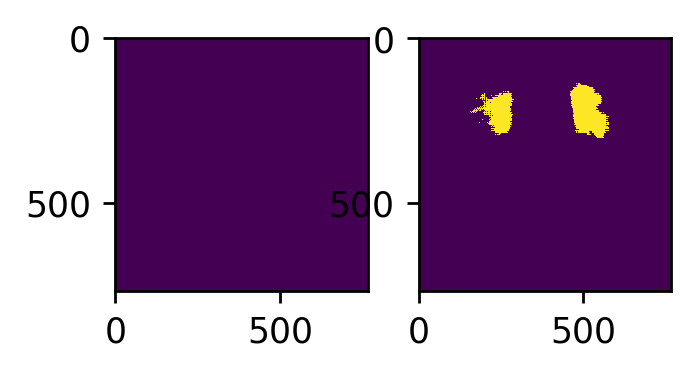

74


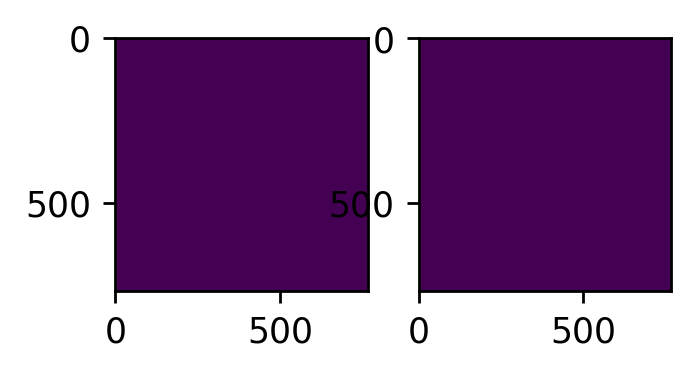

75


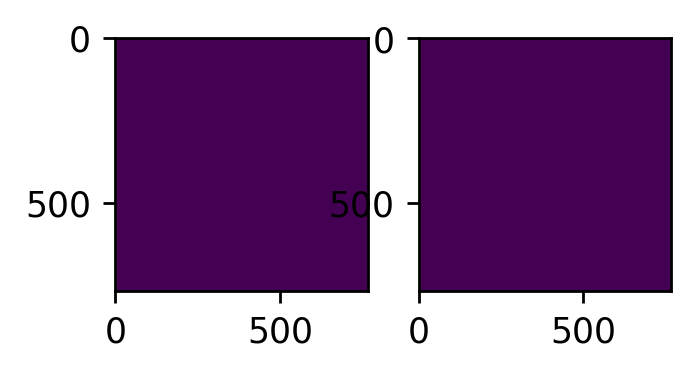

76


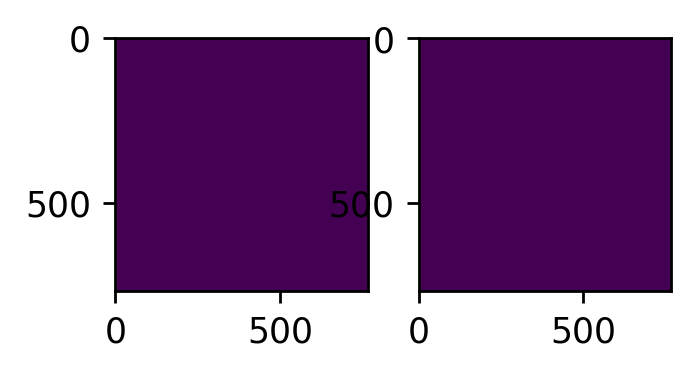

77


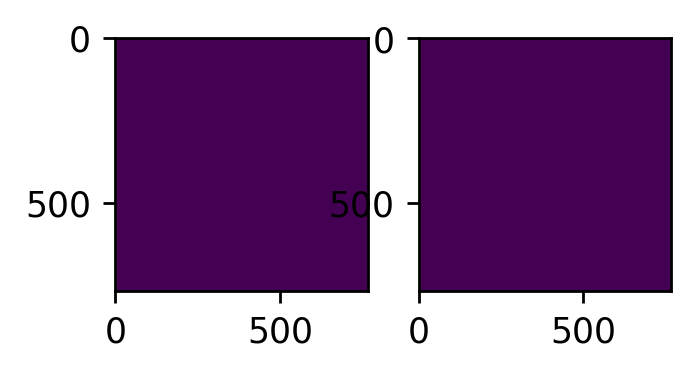

78


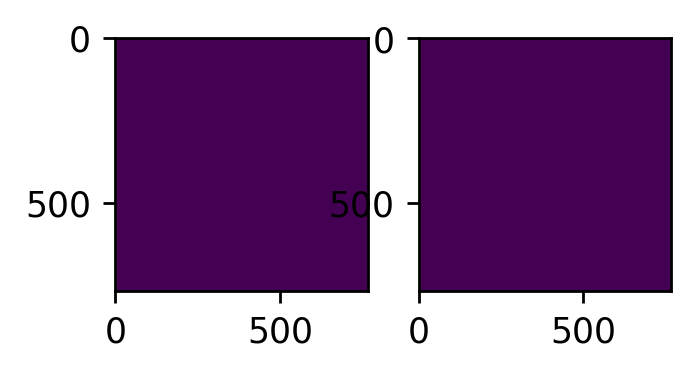

79


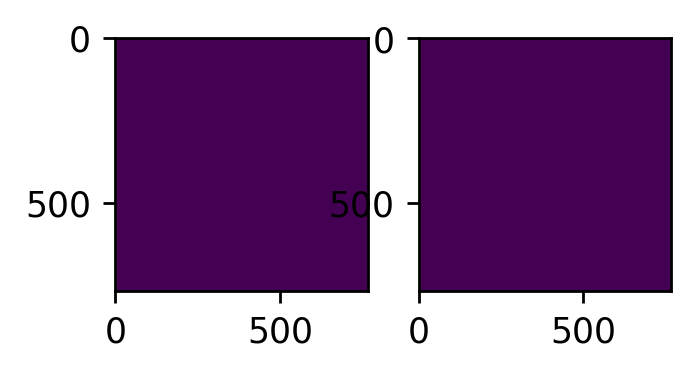

80


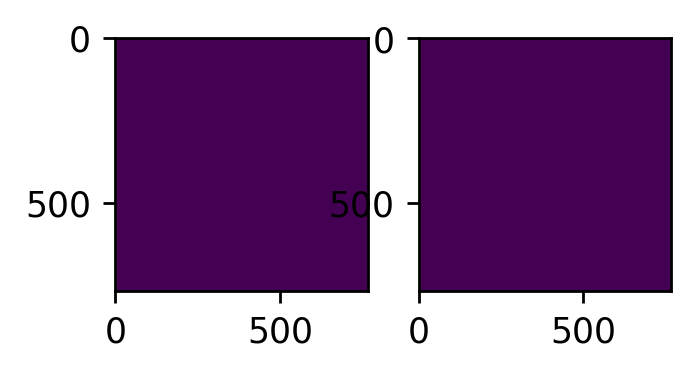

81


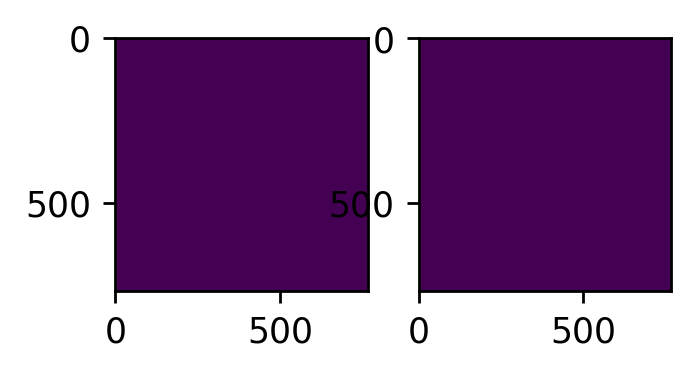

82


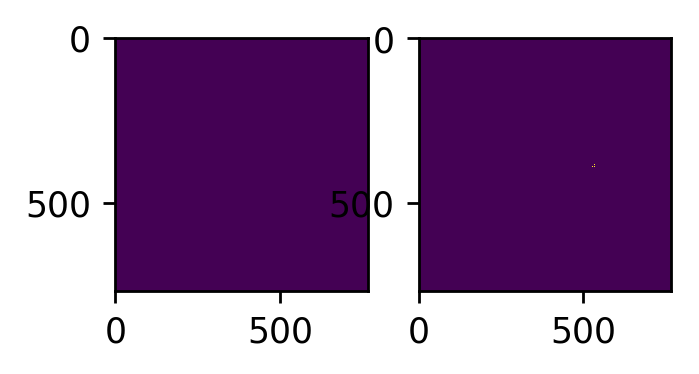

83


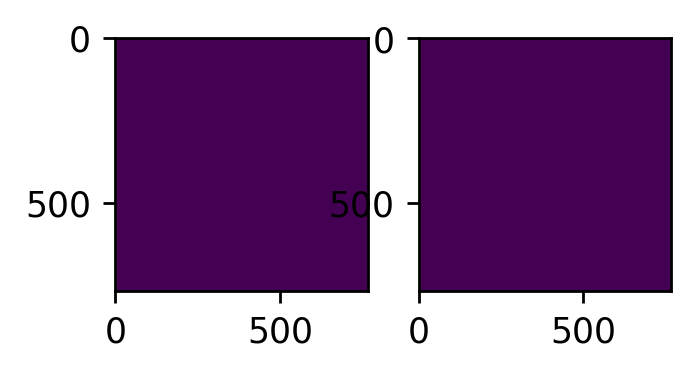

84


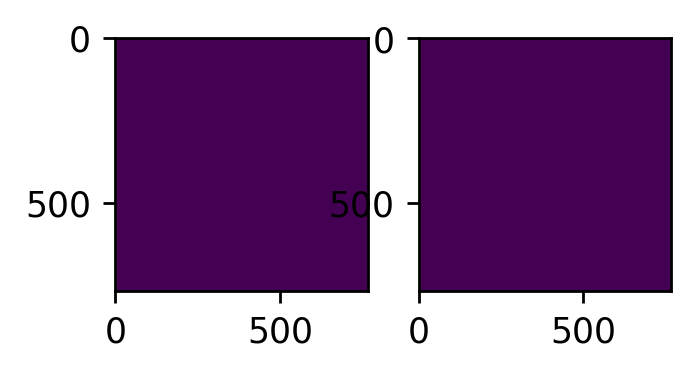

85


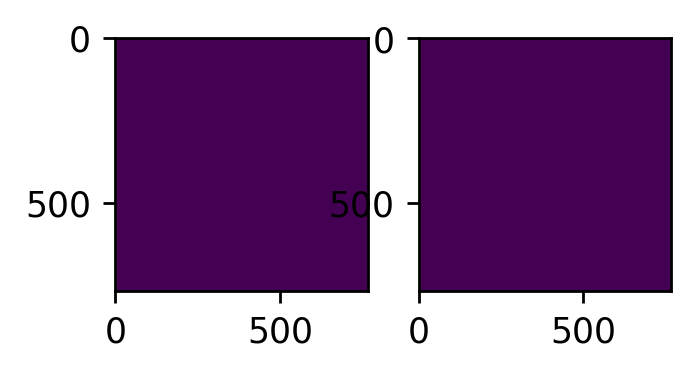

86


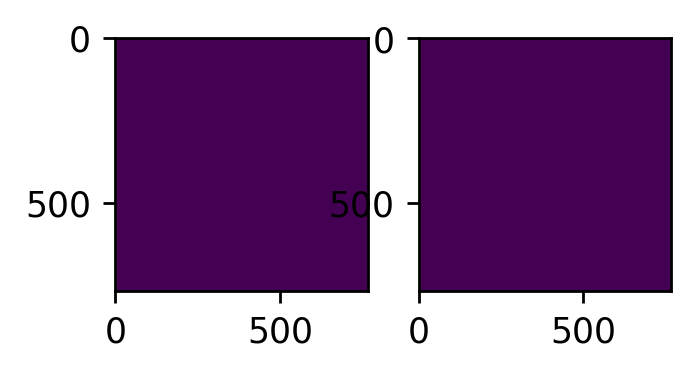

87


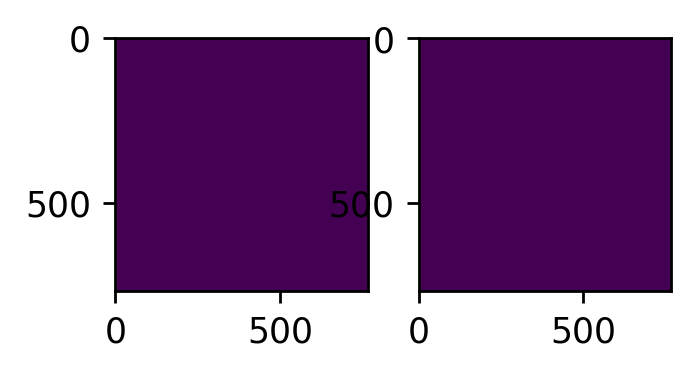

88


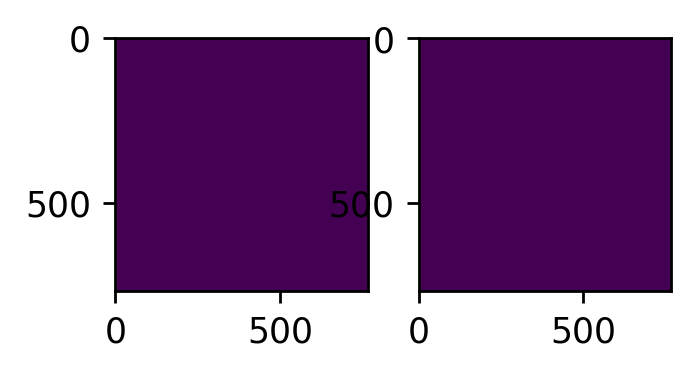

89


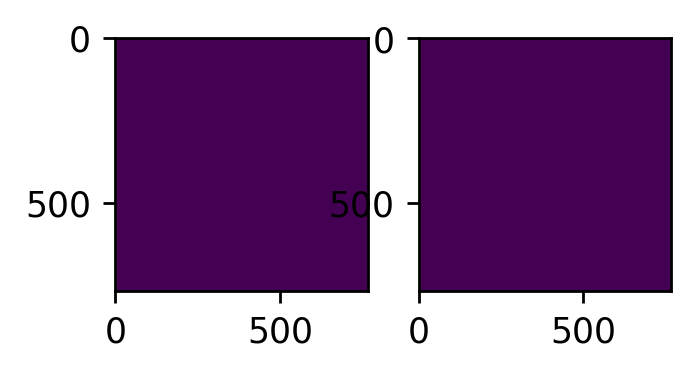

90


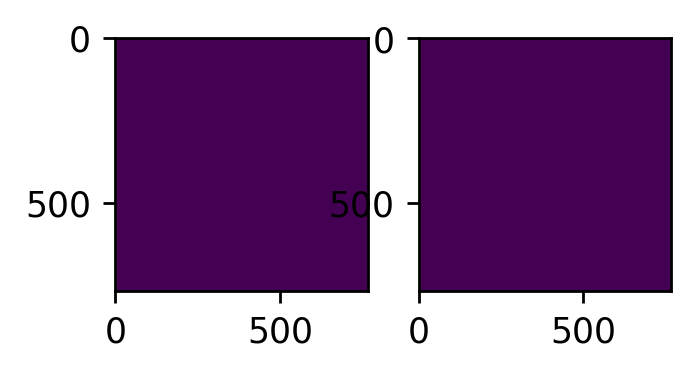

91


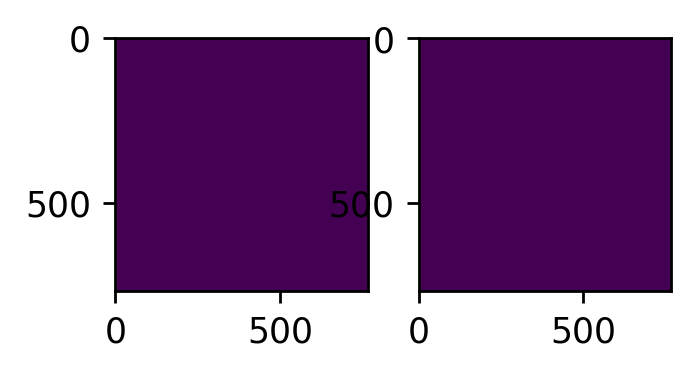

92


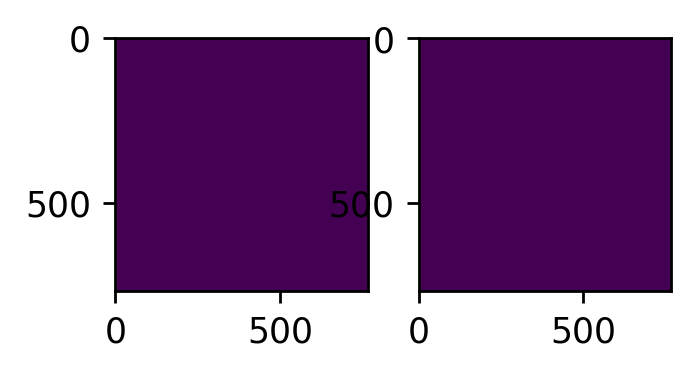

93


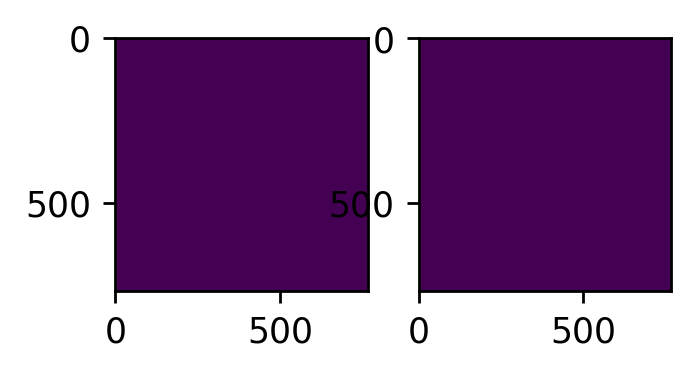

94


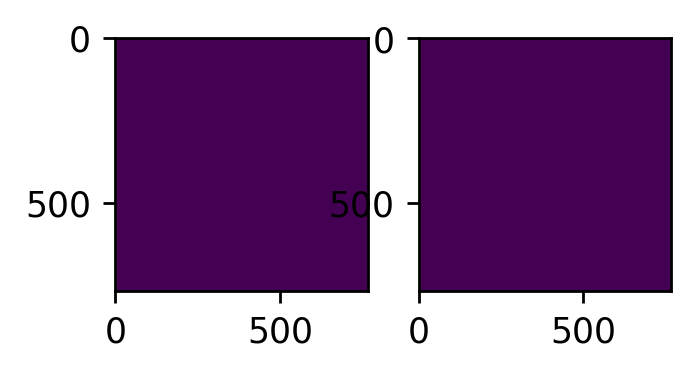

95


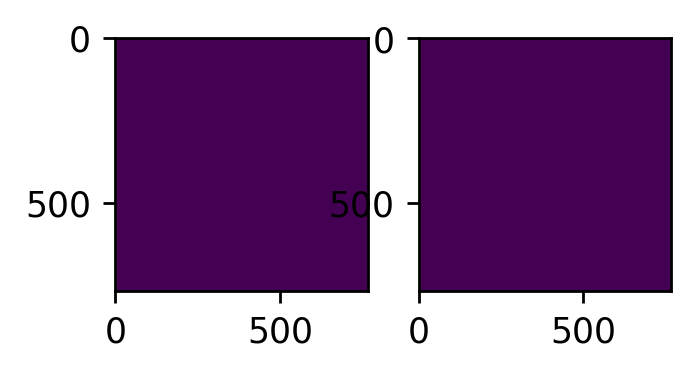

96


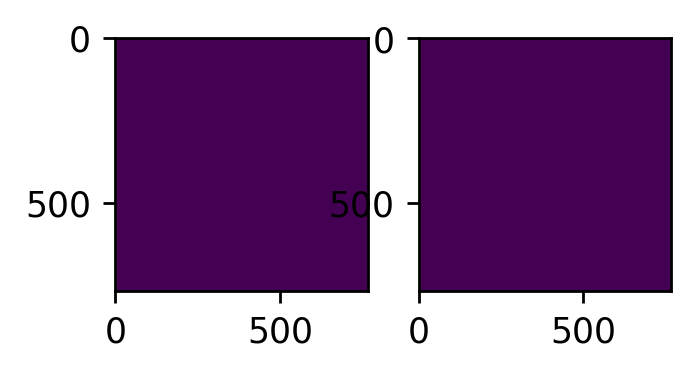

97


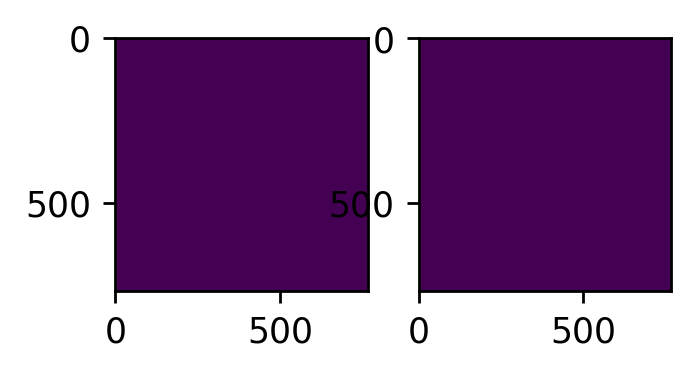

98


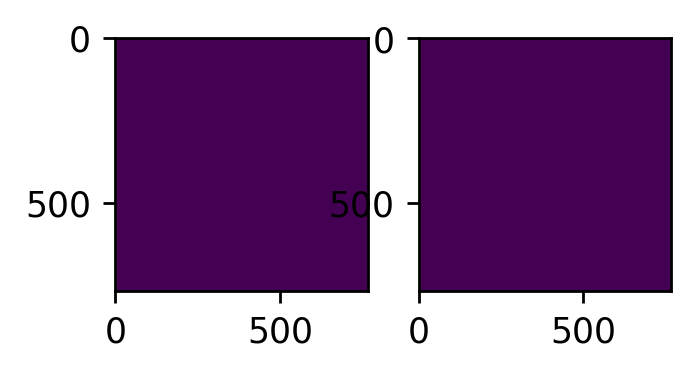

99


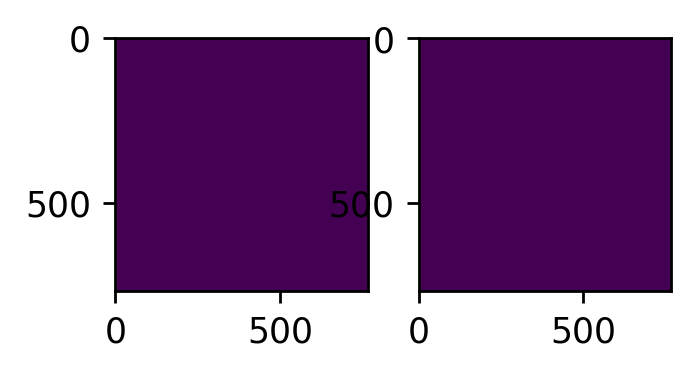

100


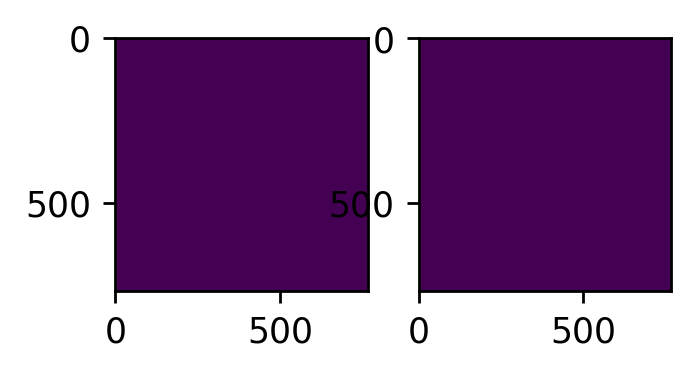

101


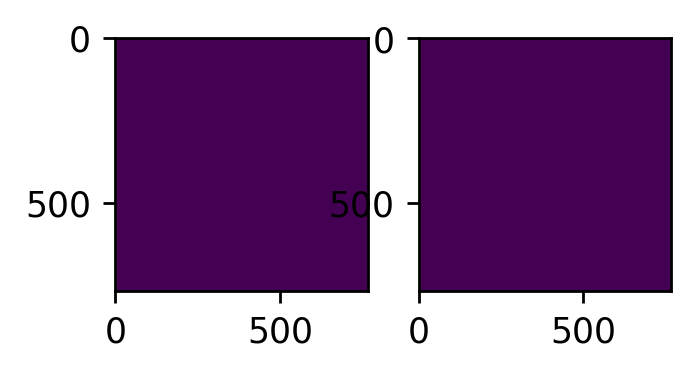

102


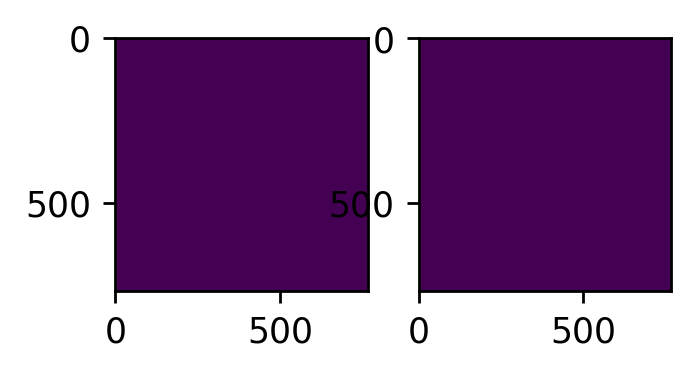

103


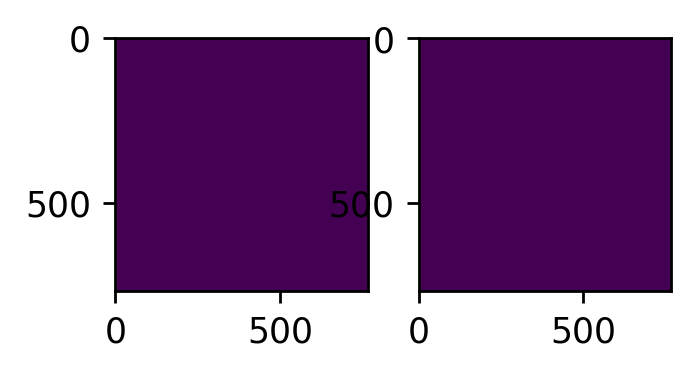

104


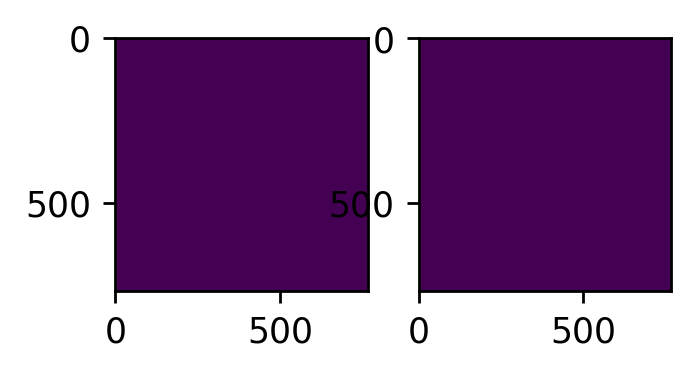

105


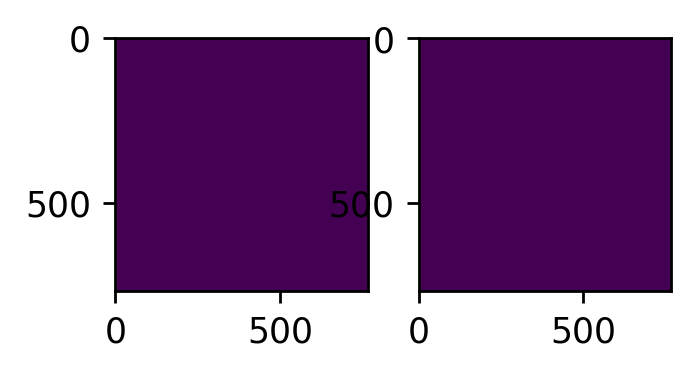

106


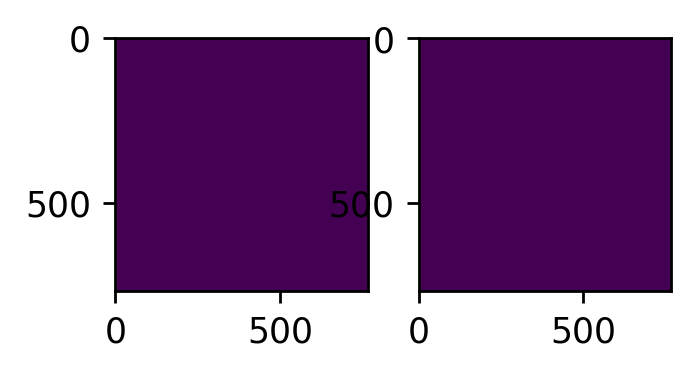

107


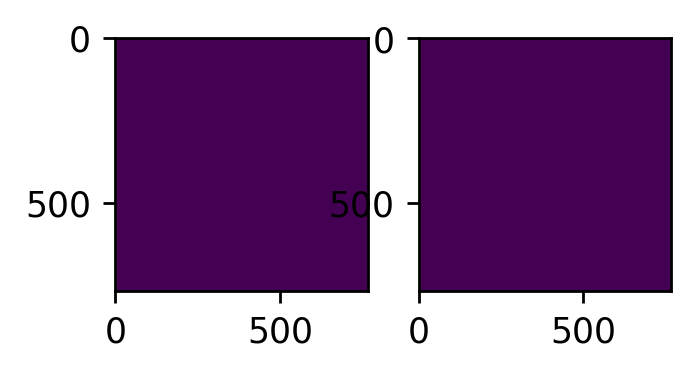

108


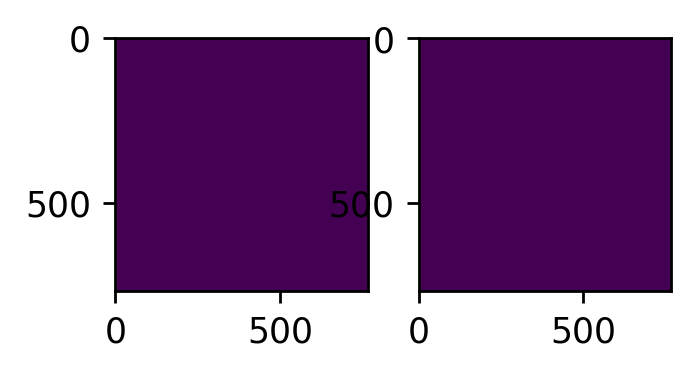

109


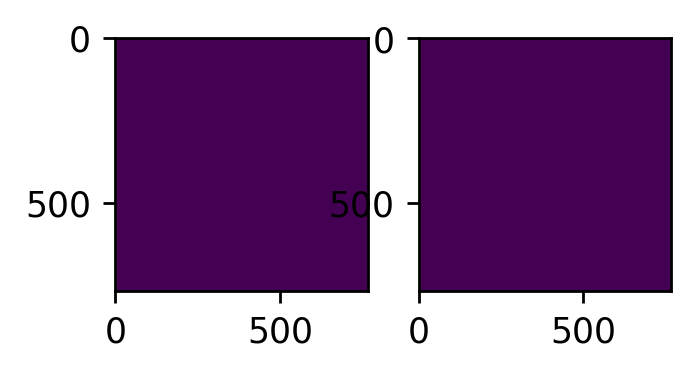

110


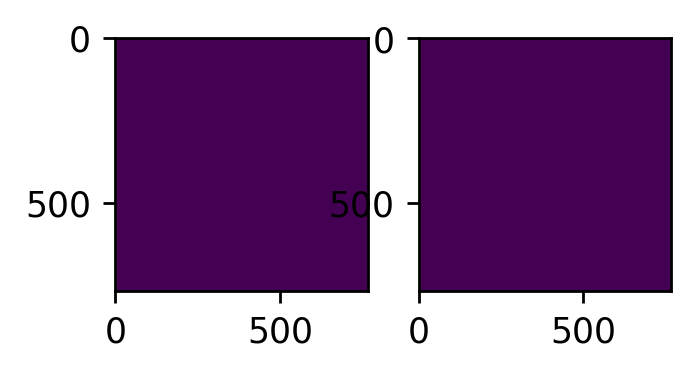

111


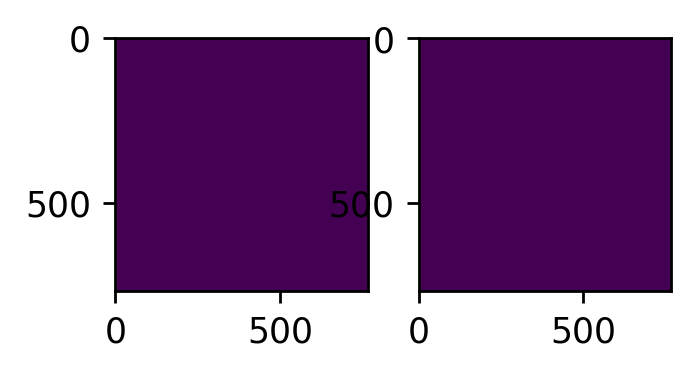

112


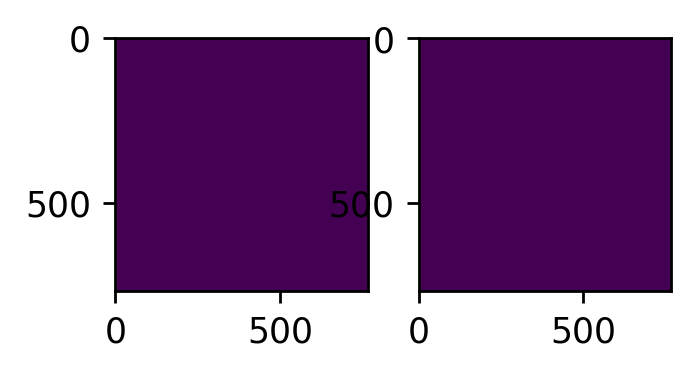

113


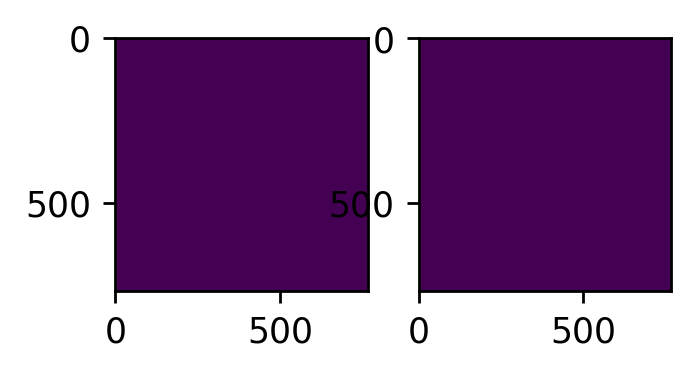

114


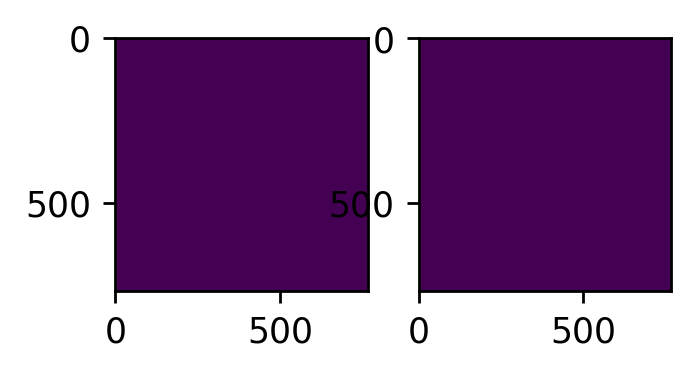

115


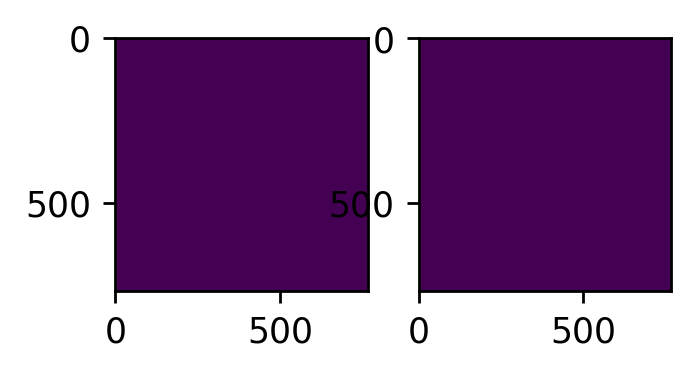

116


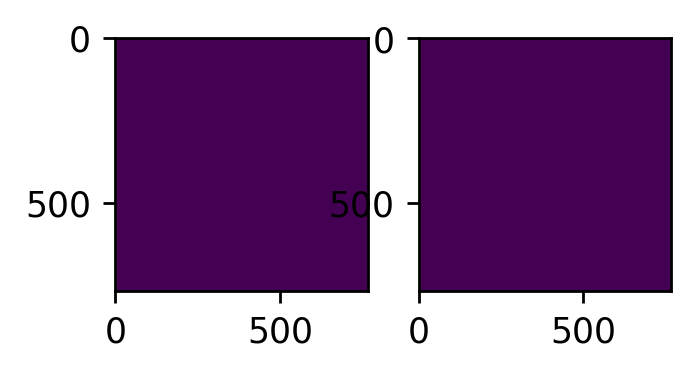

117


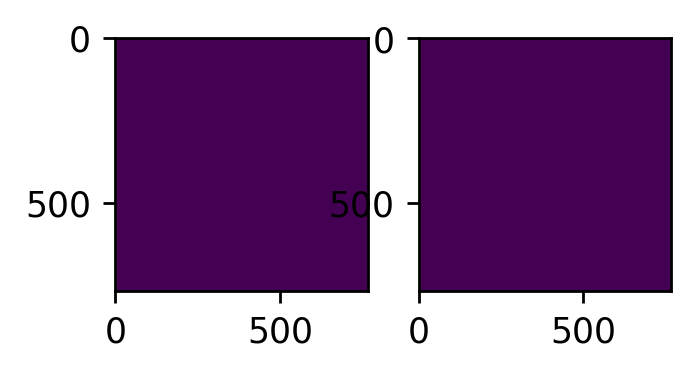

118


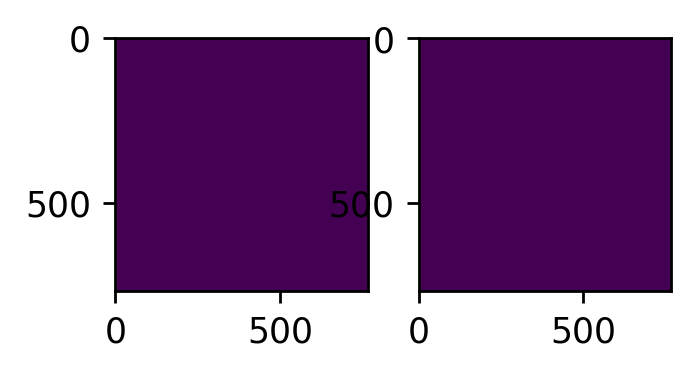

119


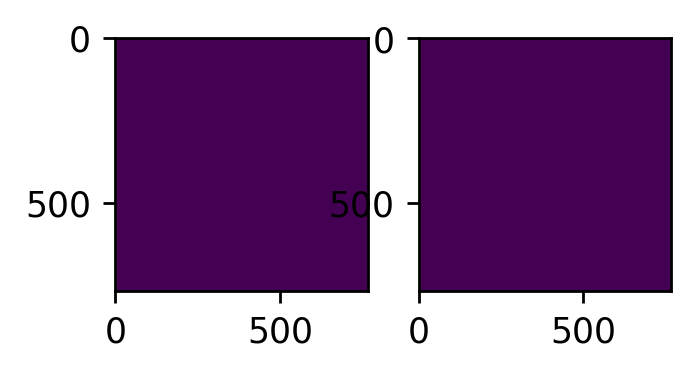

120


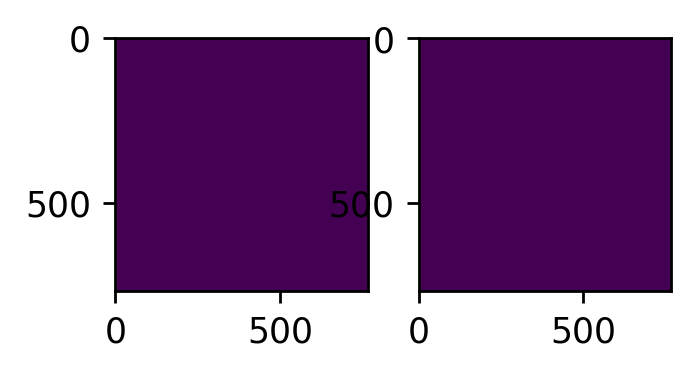

121


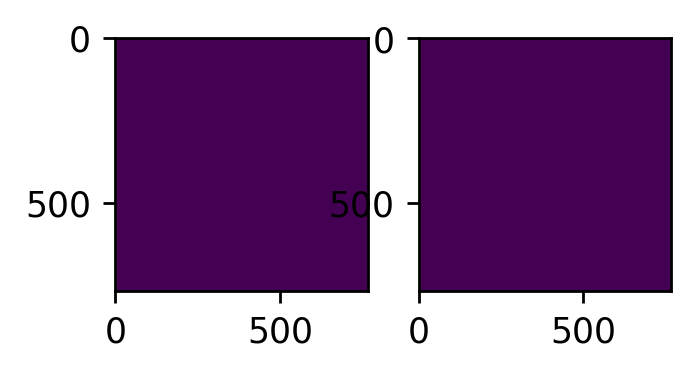

122


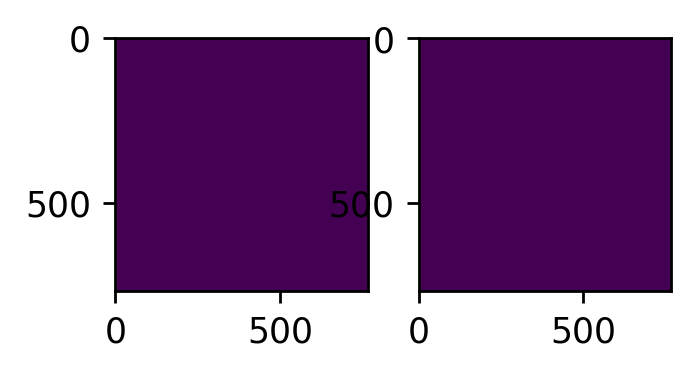

123


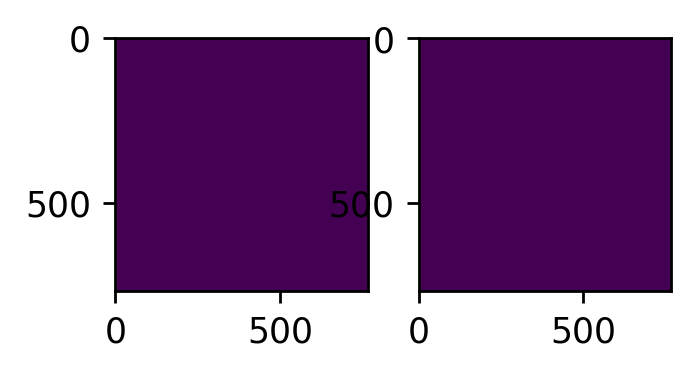

124


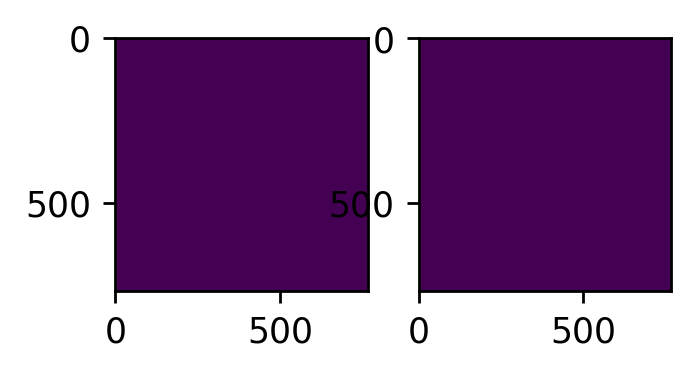

125


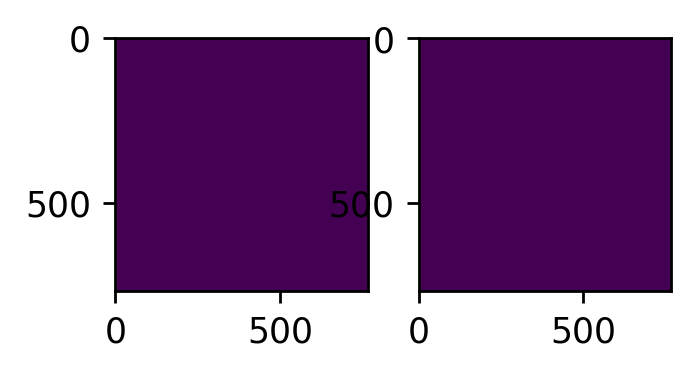

126


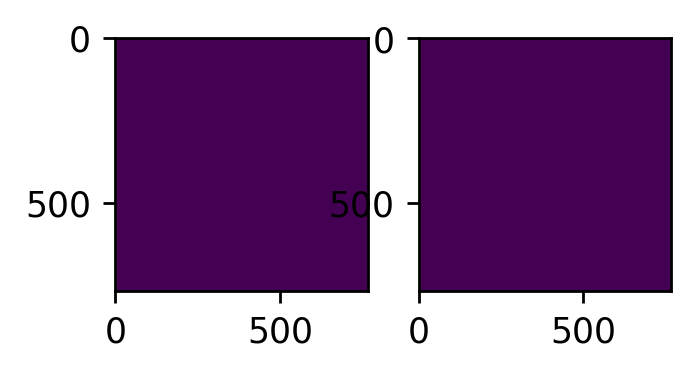

127


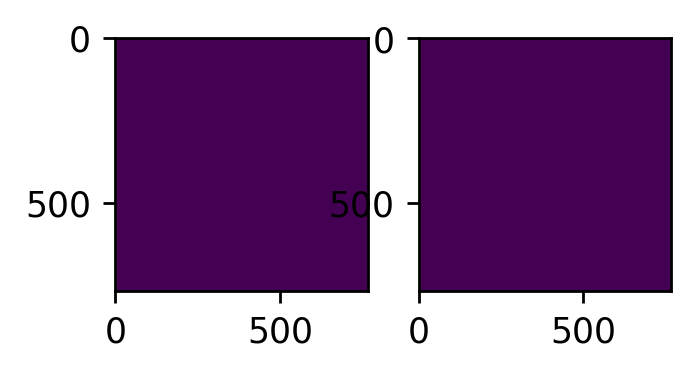

128


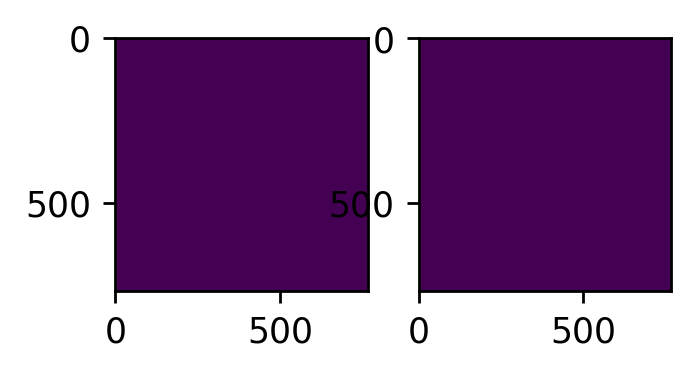

129


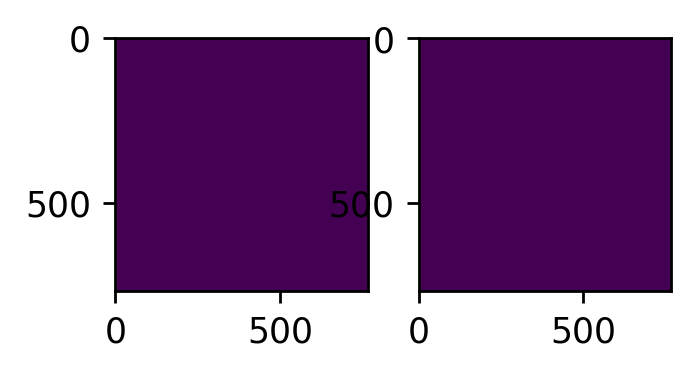

130


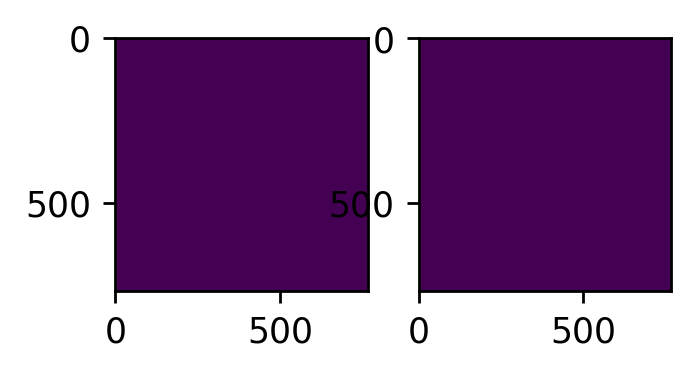

131


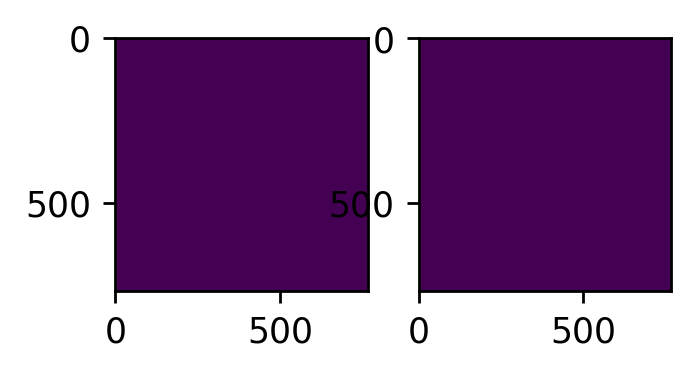

132


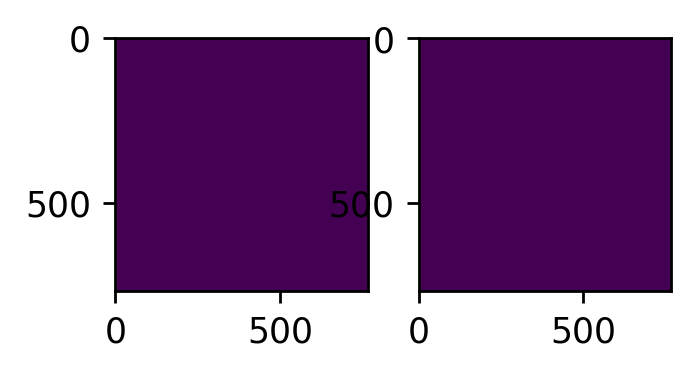

133


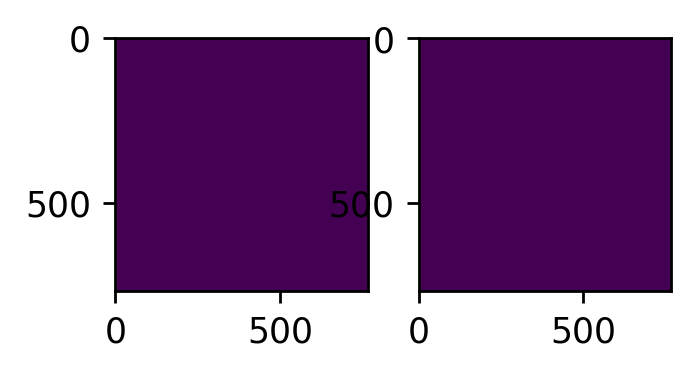

134


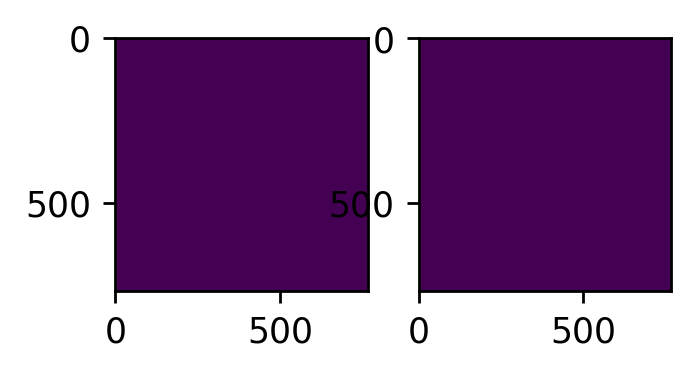

135


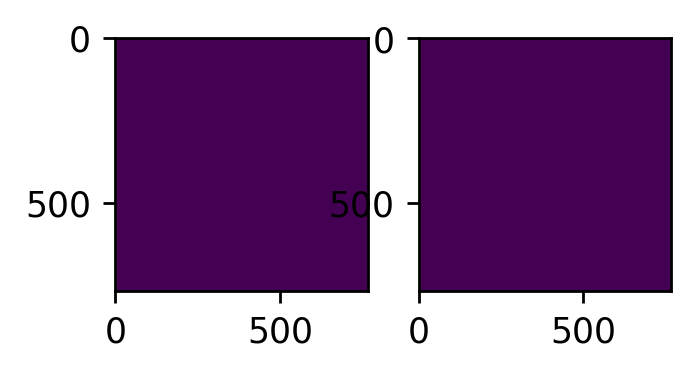

136


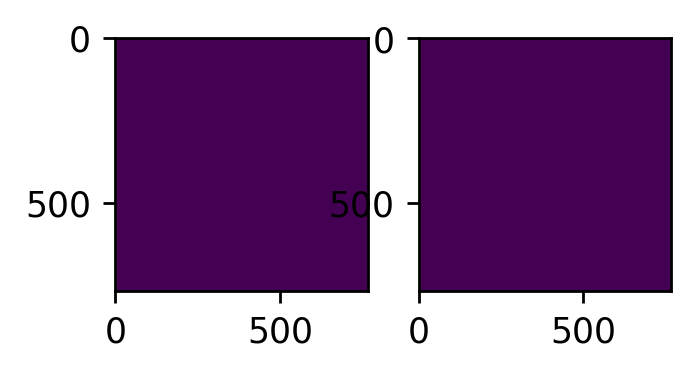

137


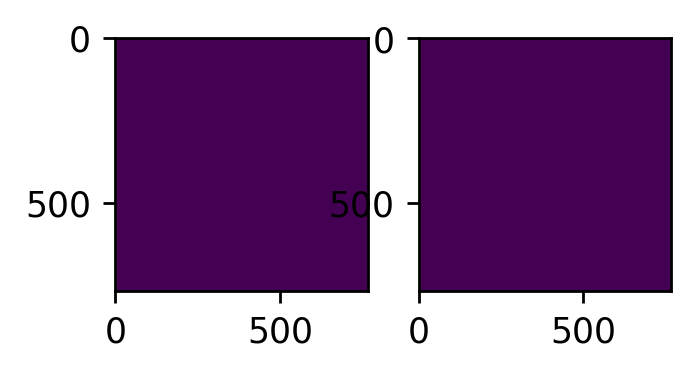

138


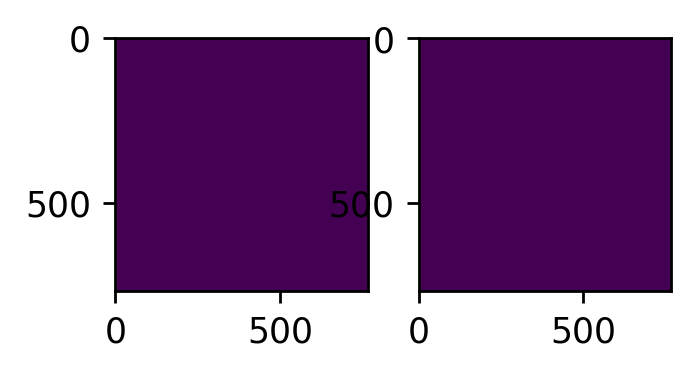

139


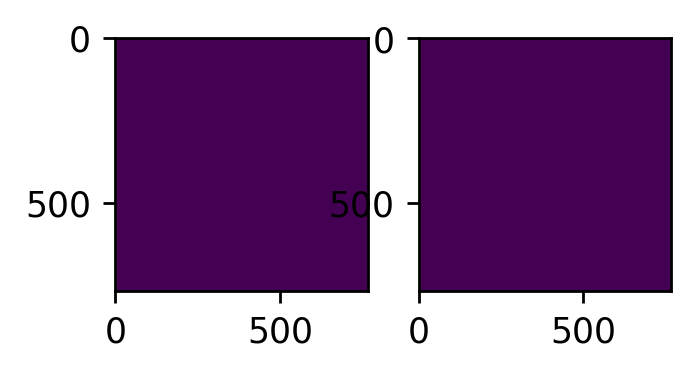

140


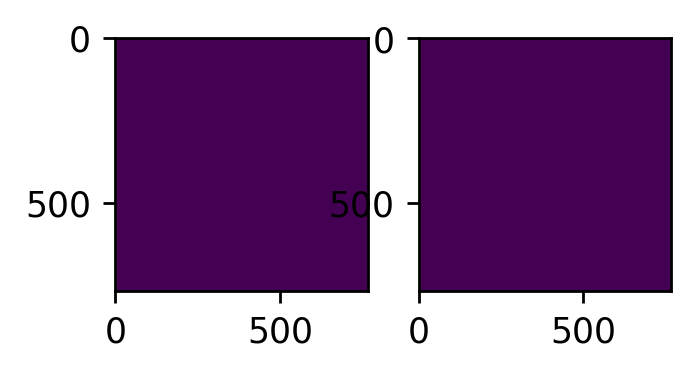

141


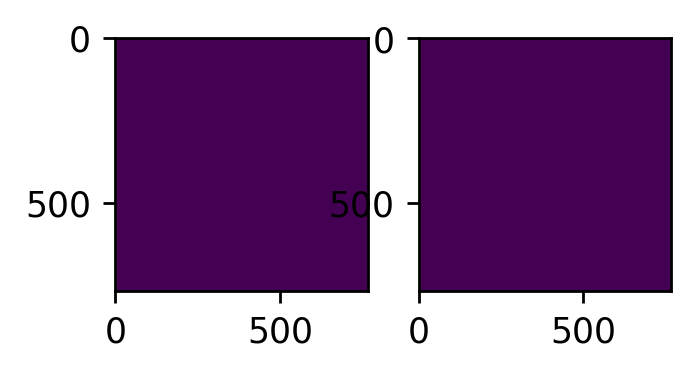

142


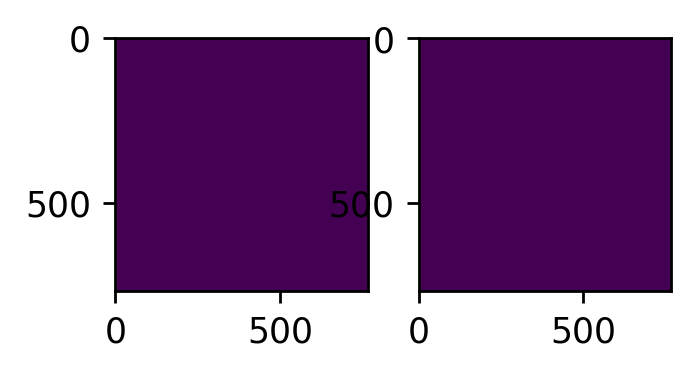

143


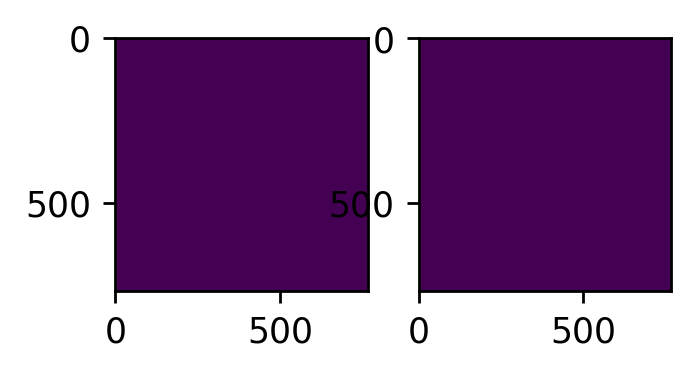

144


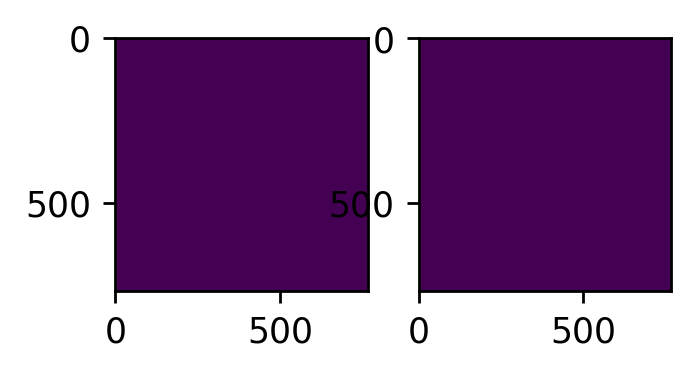

145


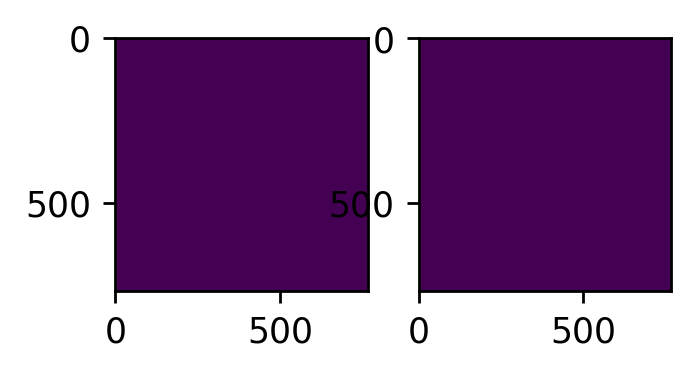

146


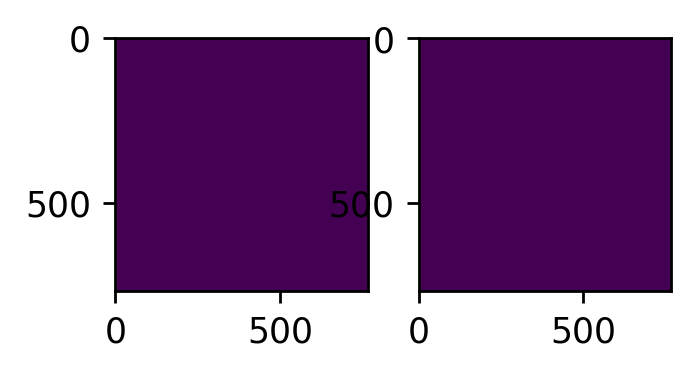

147


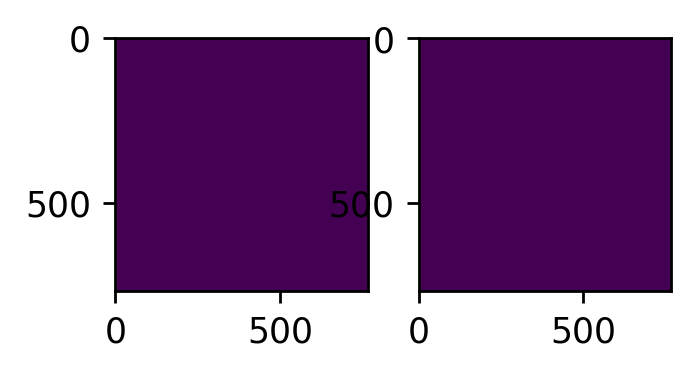

148


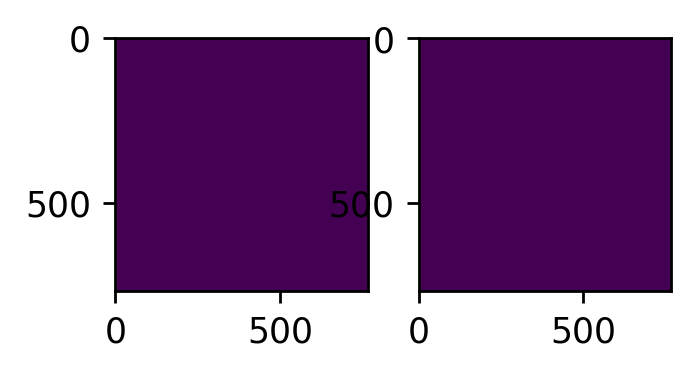

149


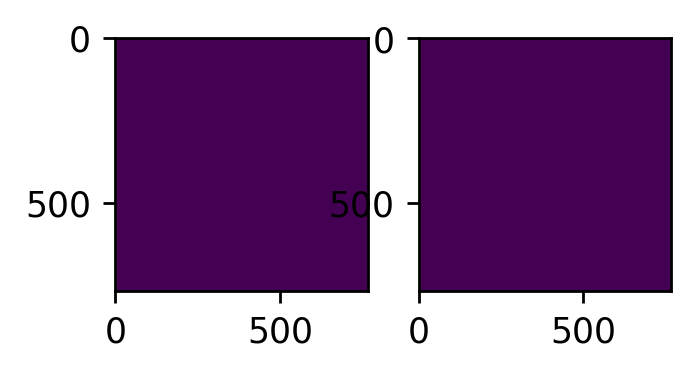

150


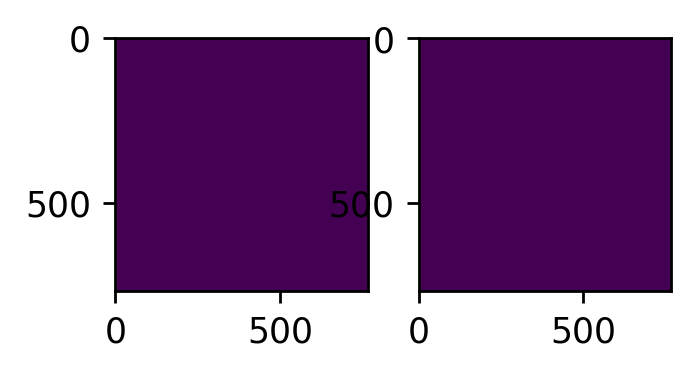

151


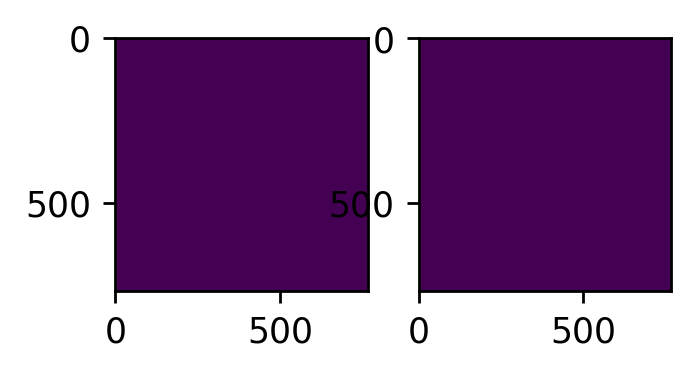

152


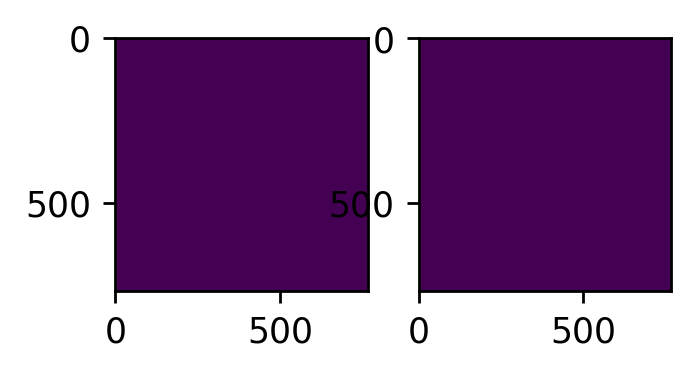

153


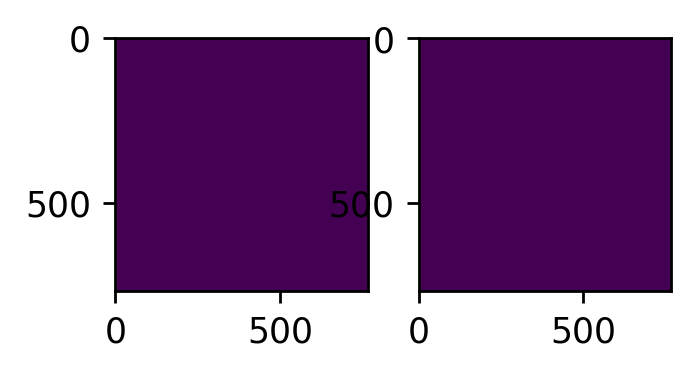

154


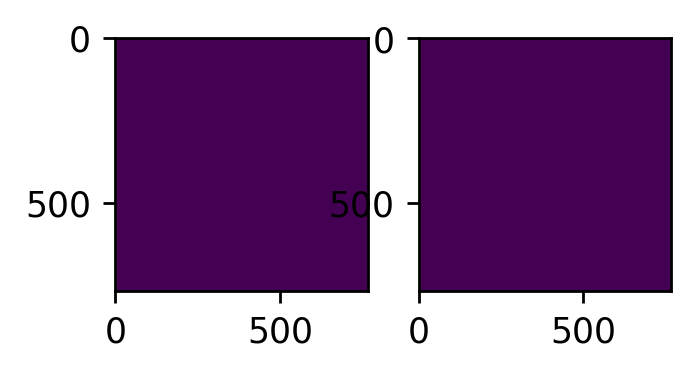

155


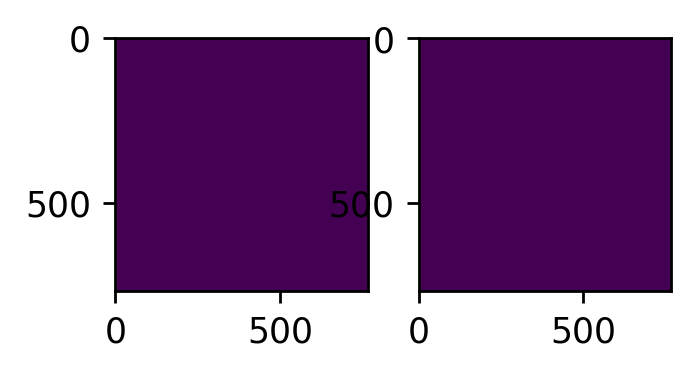

156


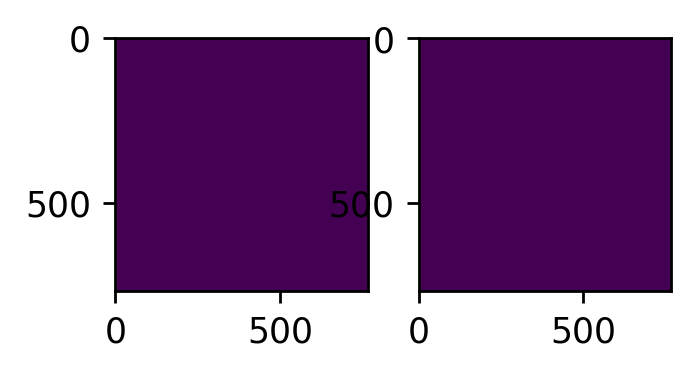

157


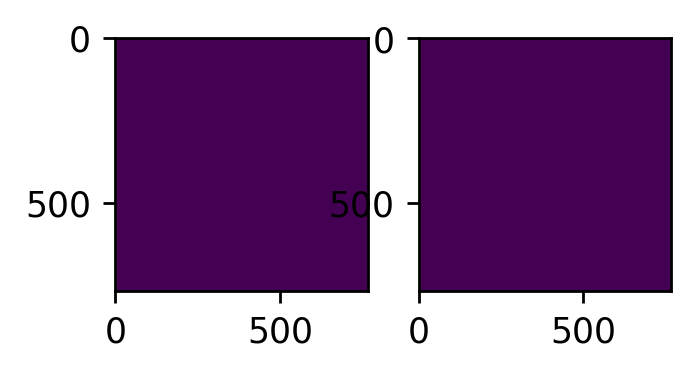

158


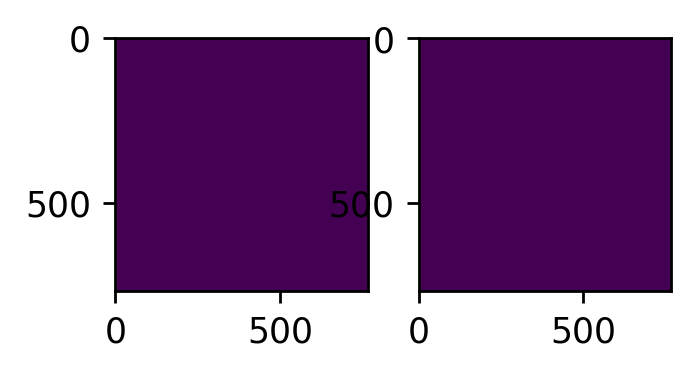

159


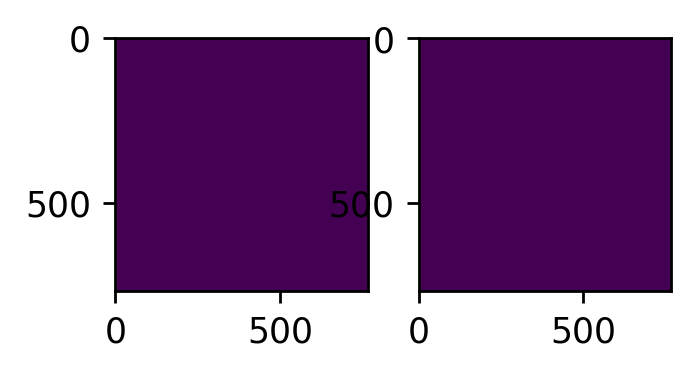

160


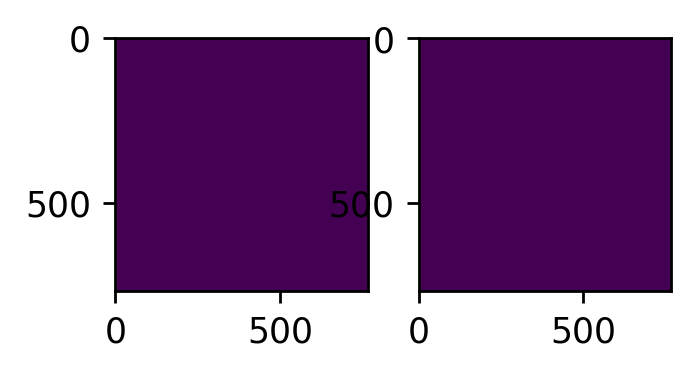

161


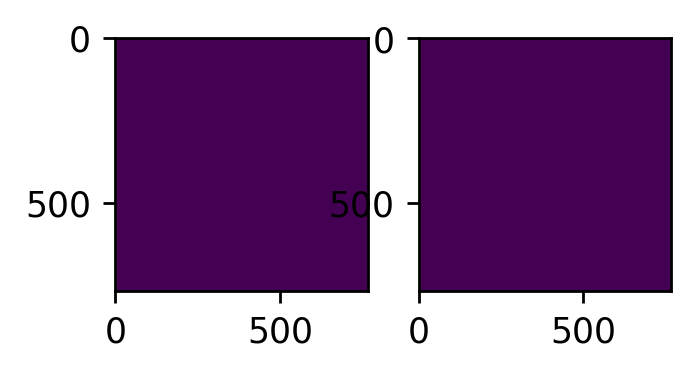

162


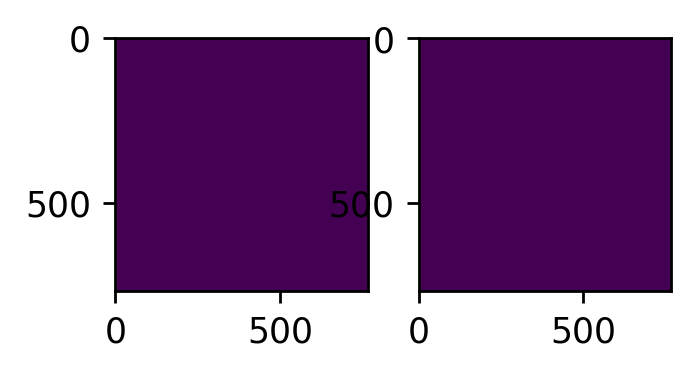

163


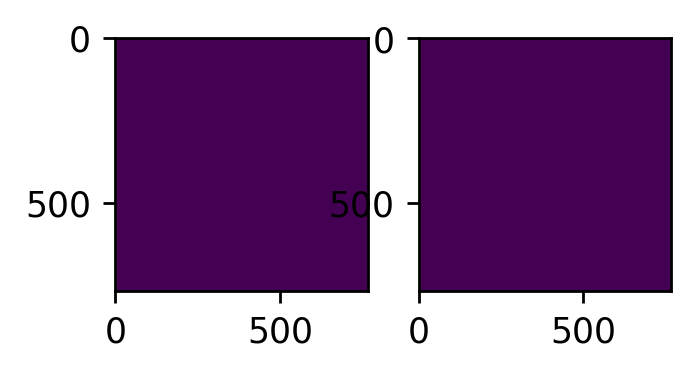

164


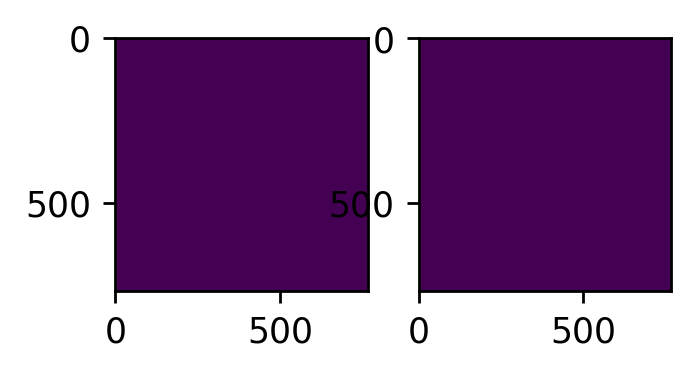

165


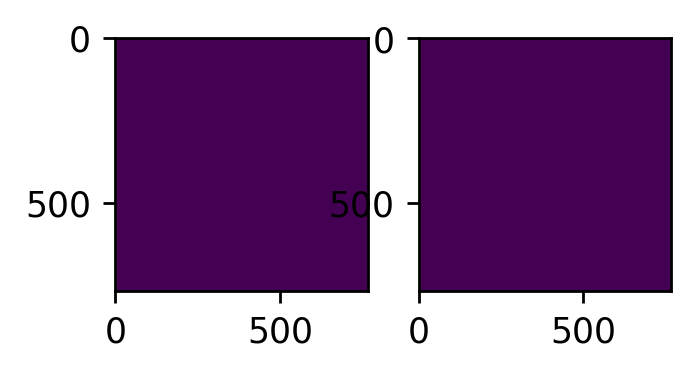

166


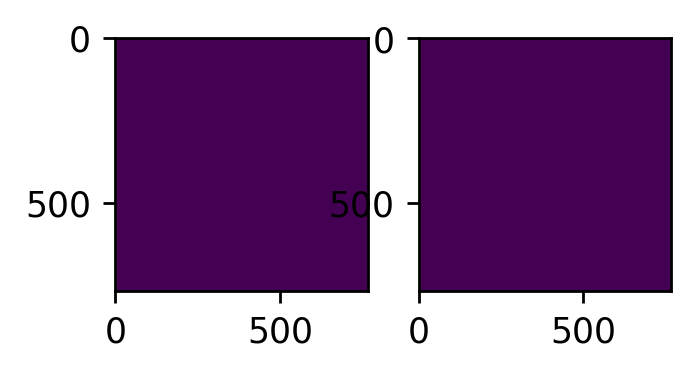

167


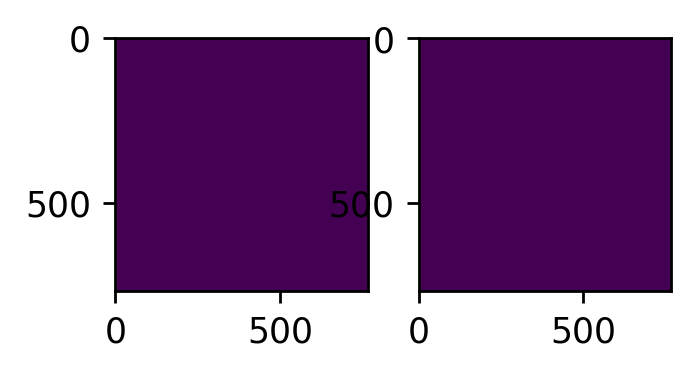

168


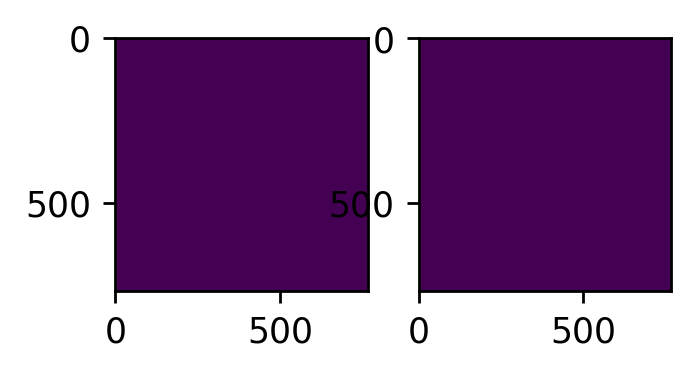

169


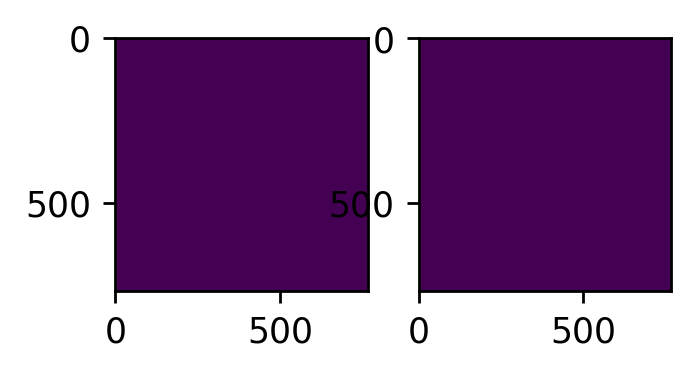

170


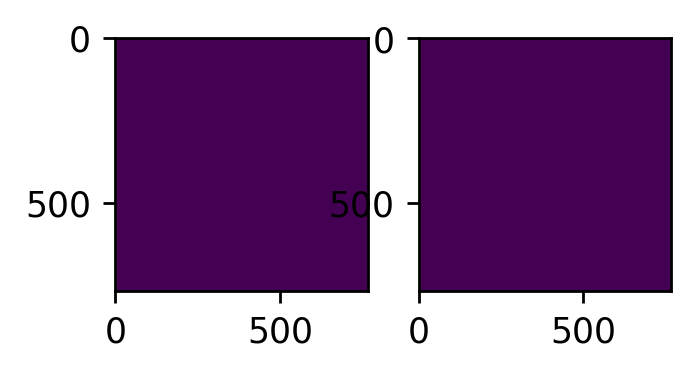

171


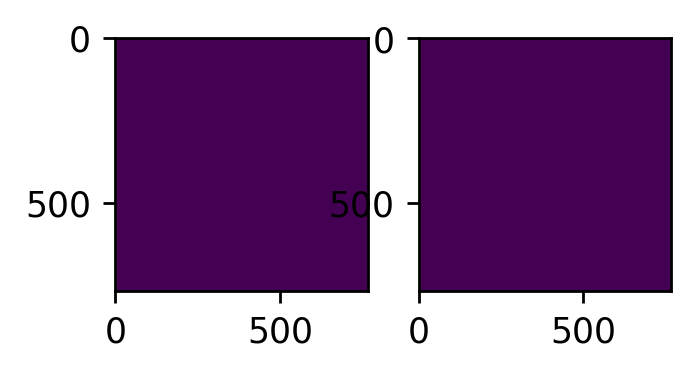

172


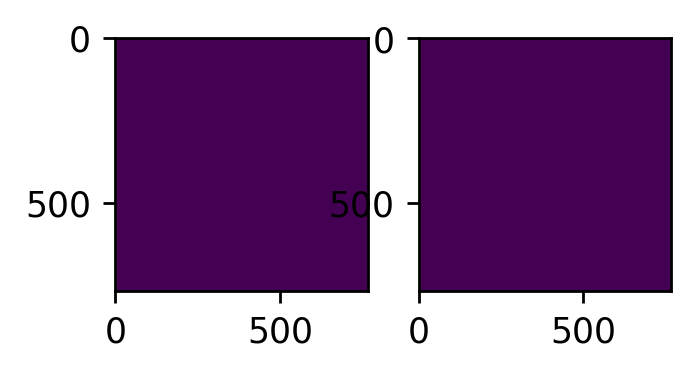

173


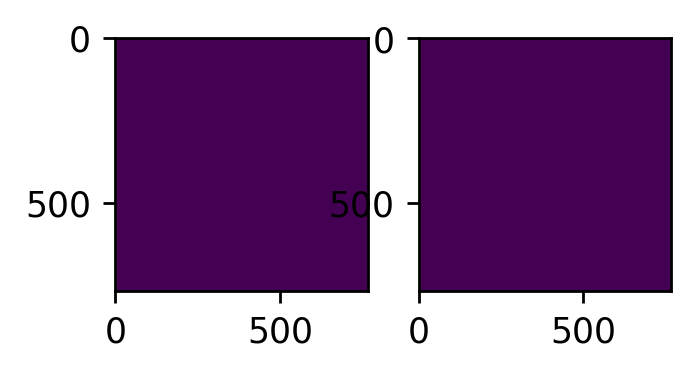

174


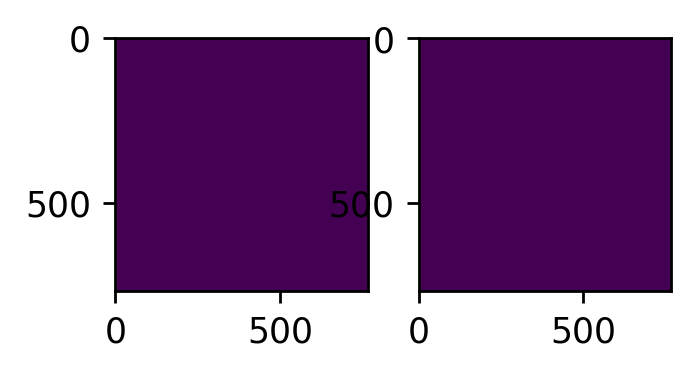

175


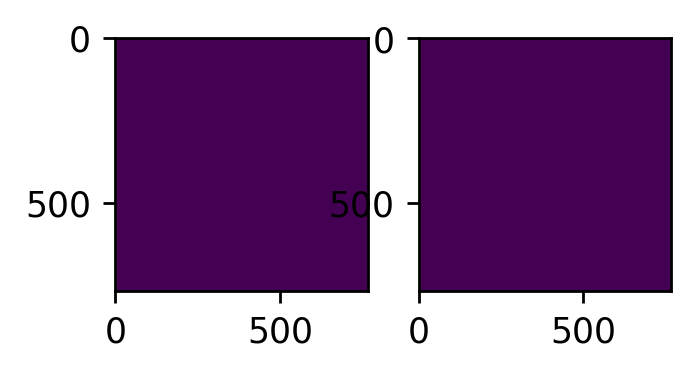

176


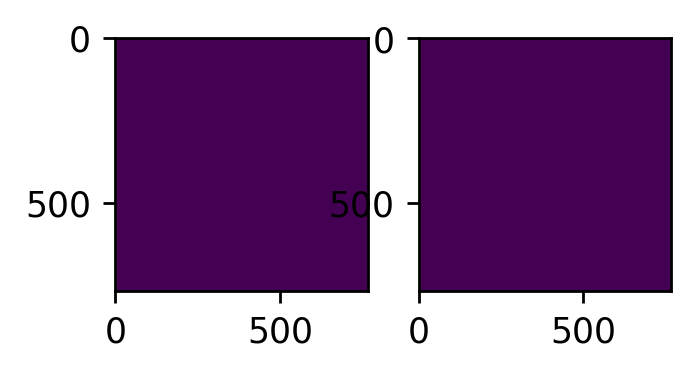

177


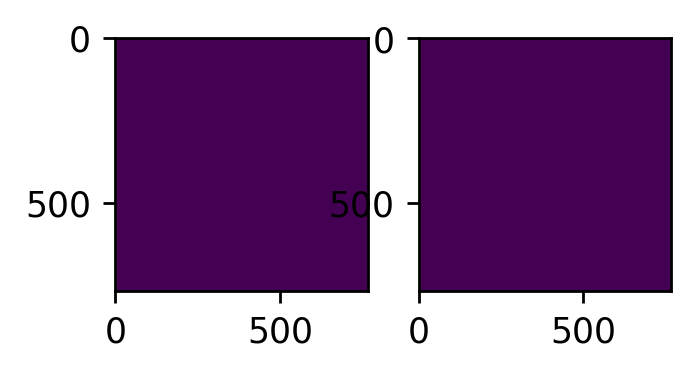

178


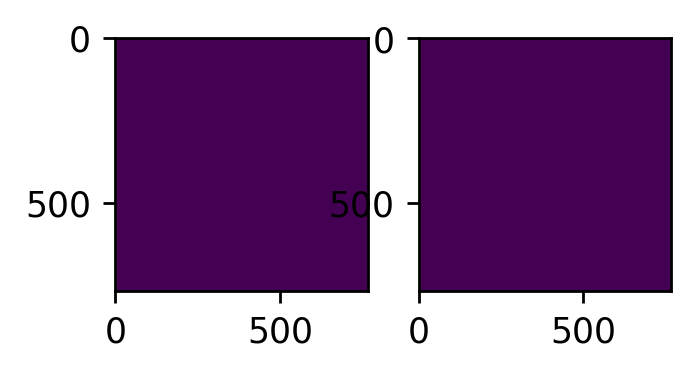

179


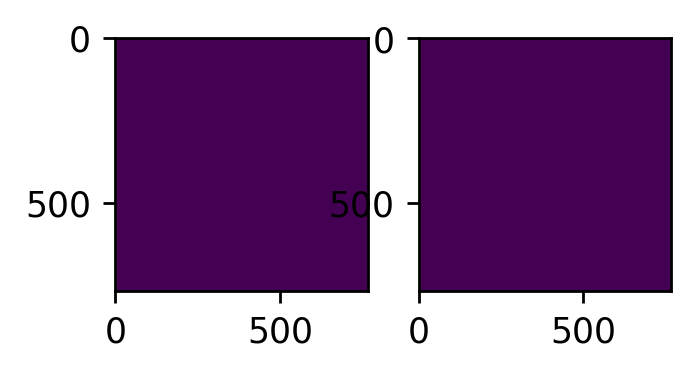

180


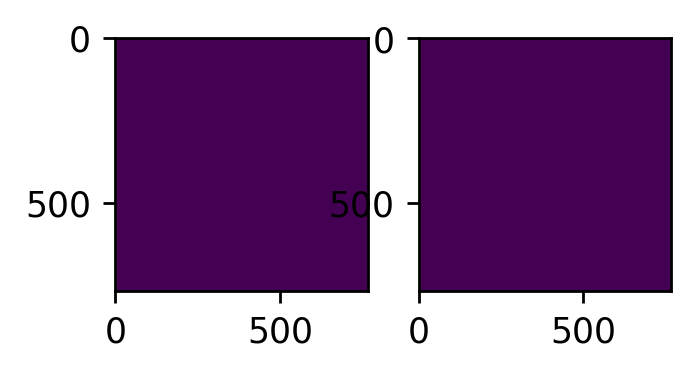

181


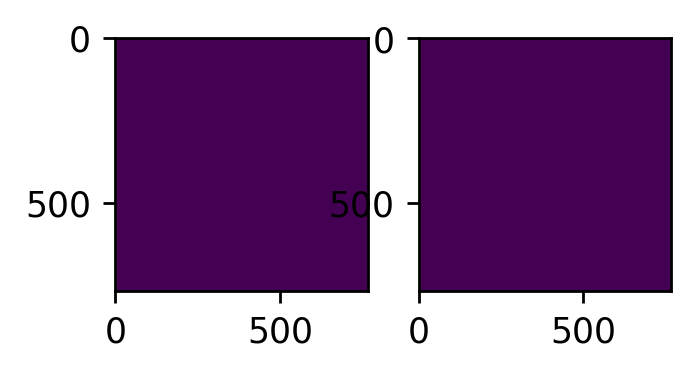

182


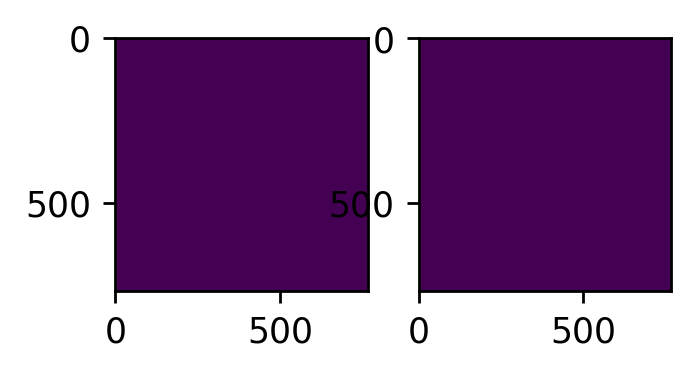

183


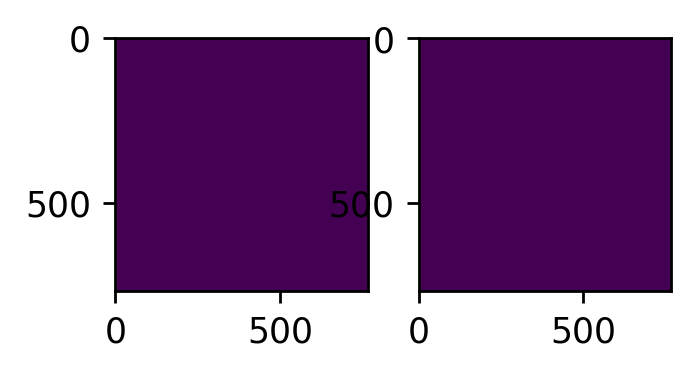

184


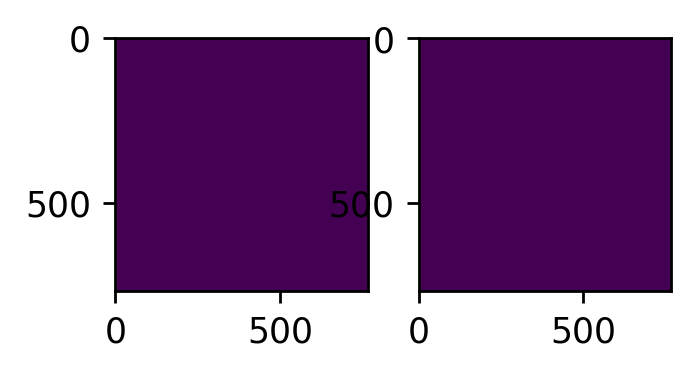

185


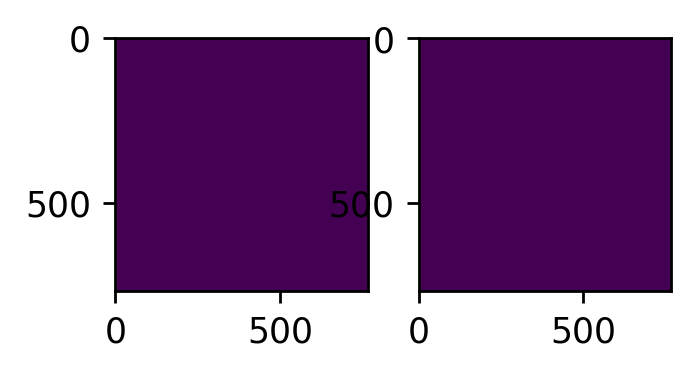

186


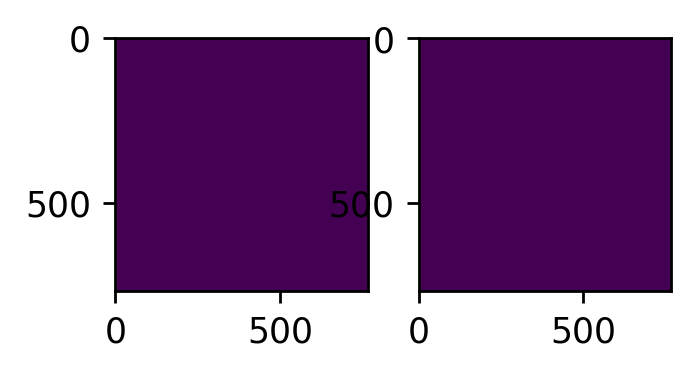

187


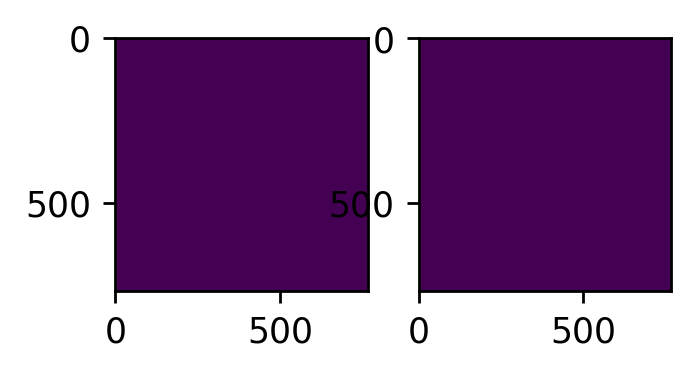

188


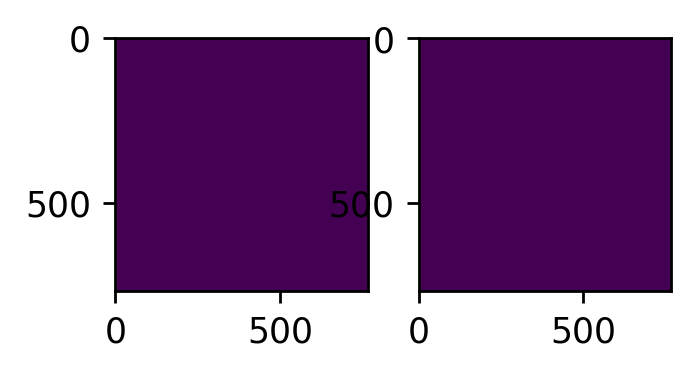

189


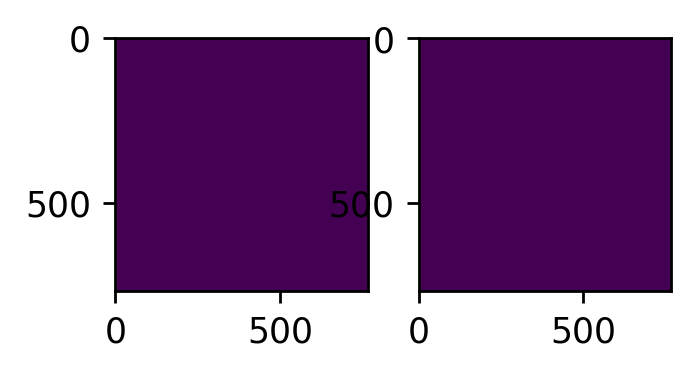

190


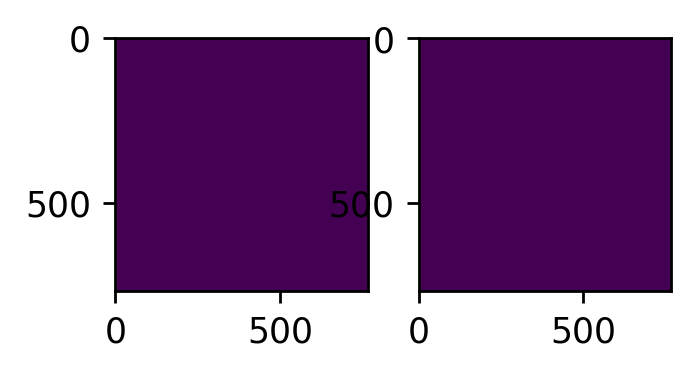

191


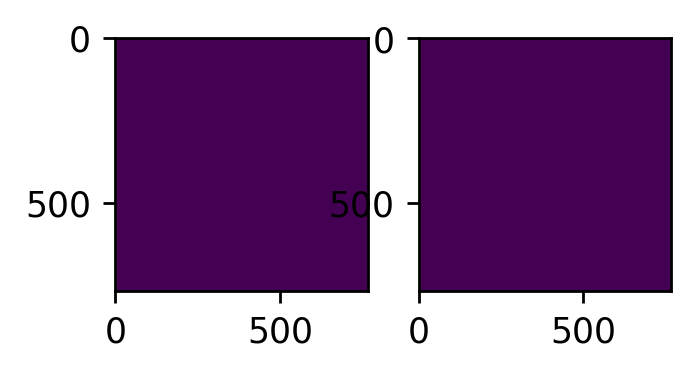

192


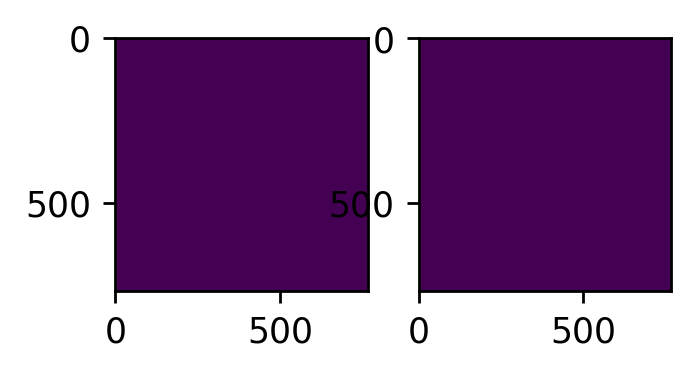

193


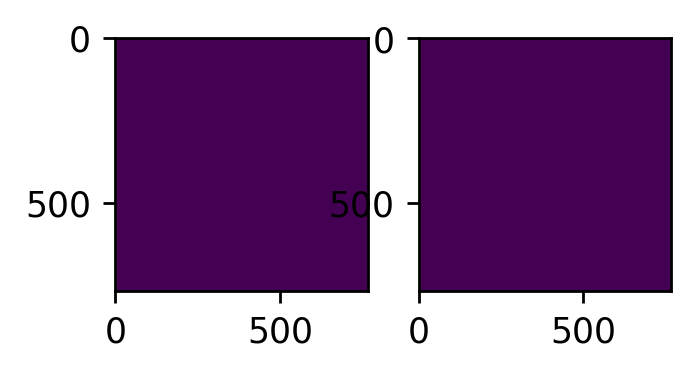

194


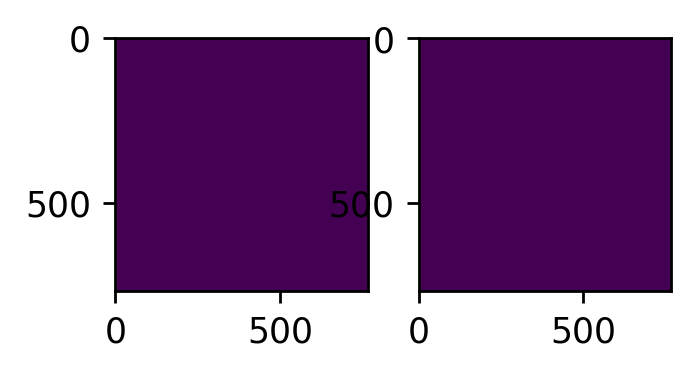

195


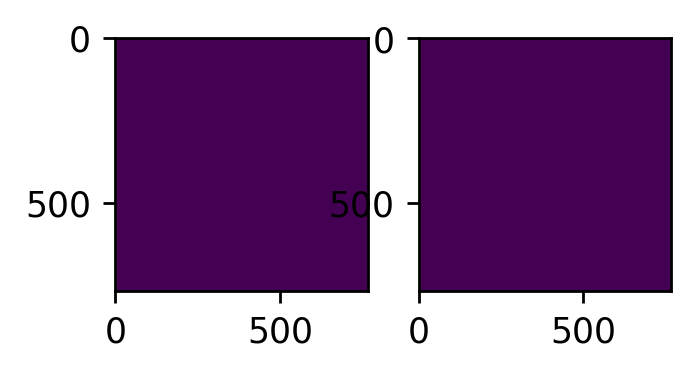

196


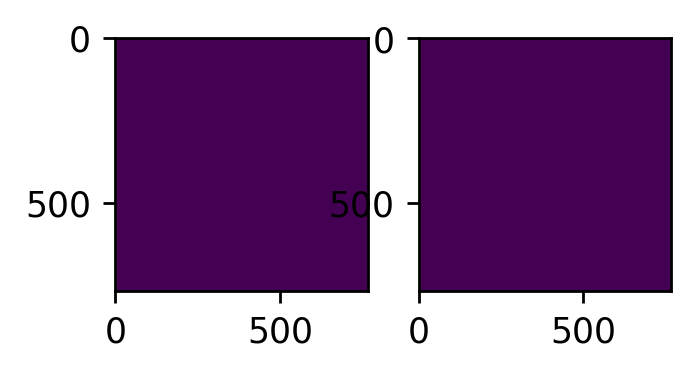

197


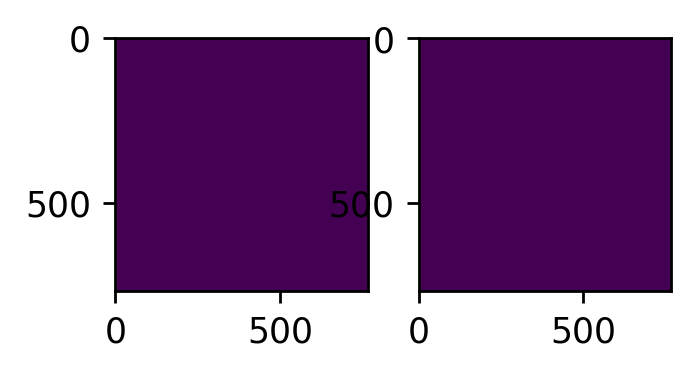

198


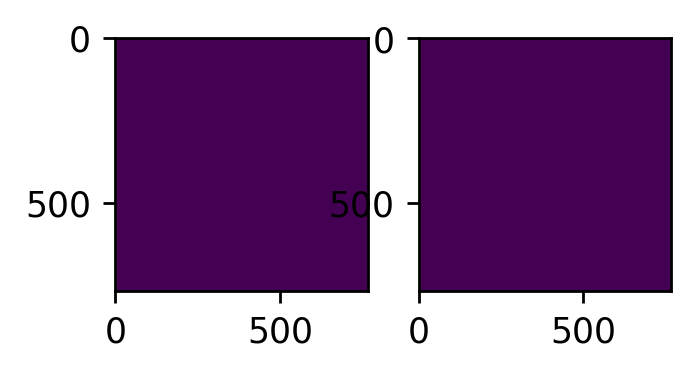

199


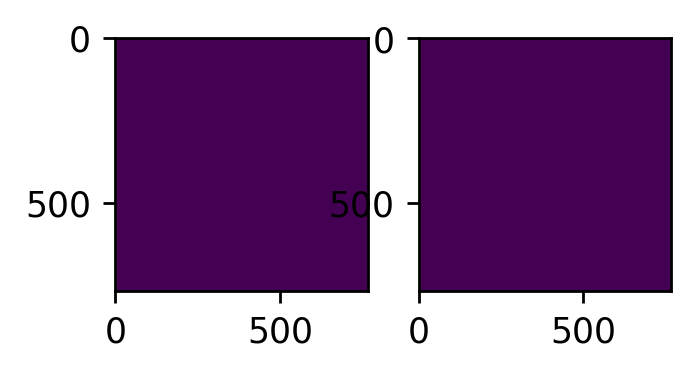

200


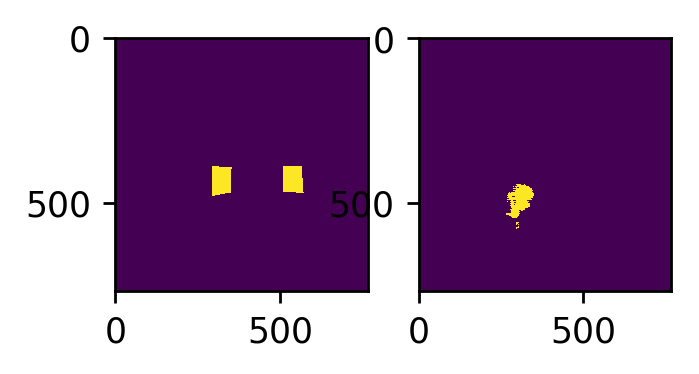

201


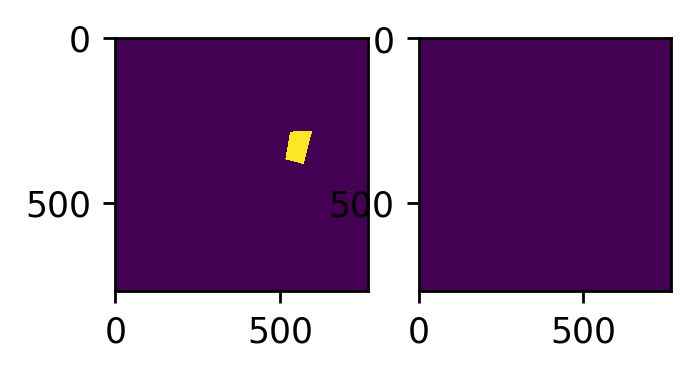

202


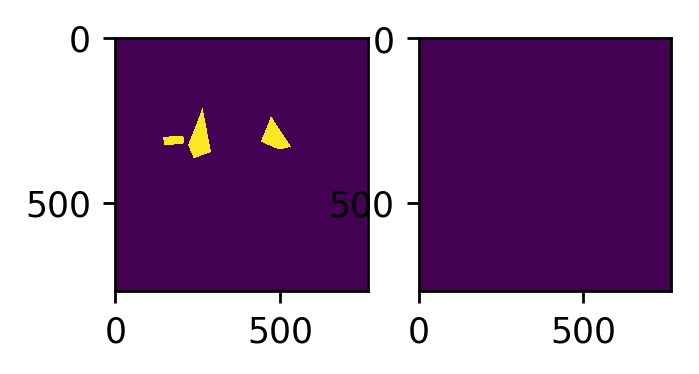

203


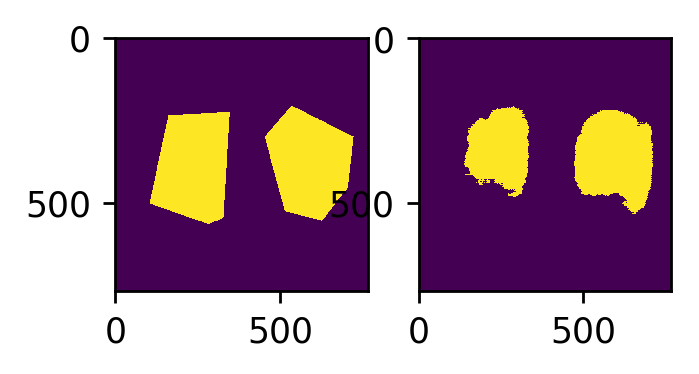

204


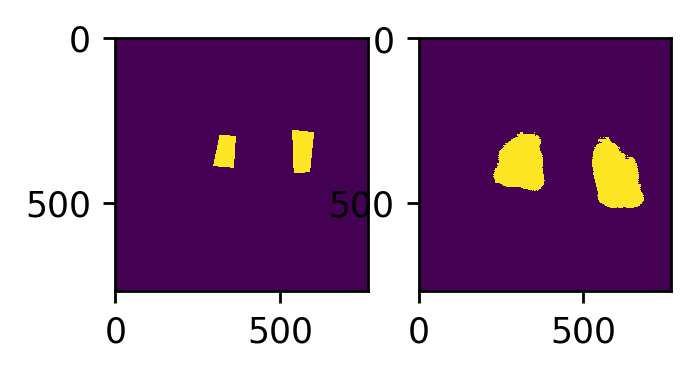

205


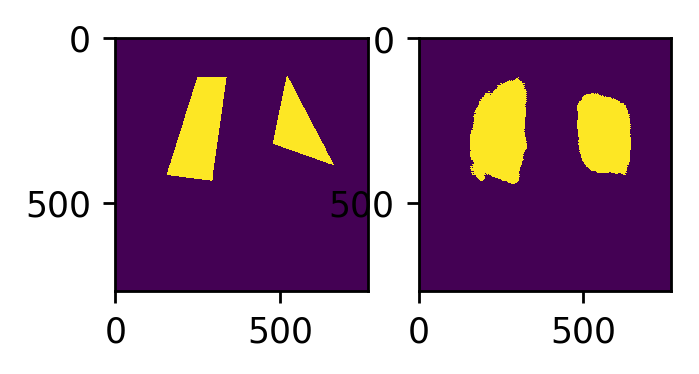

206


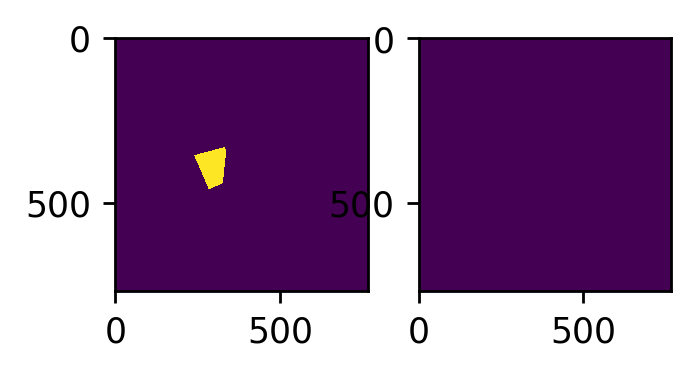

207


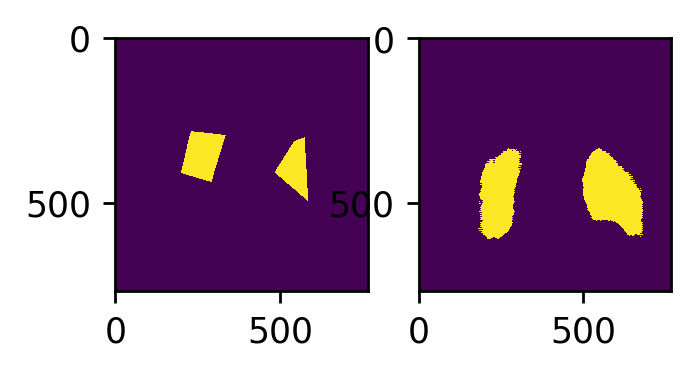

208


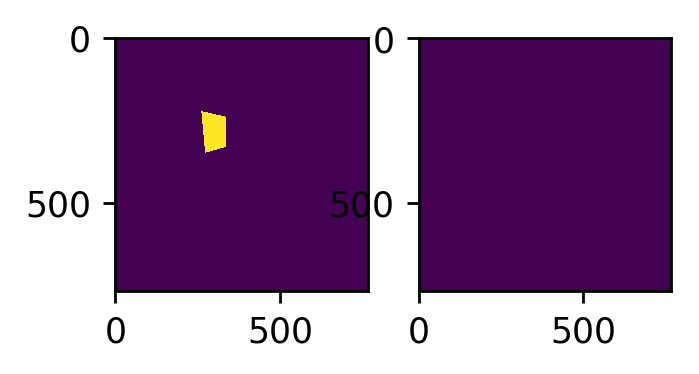

209


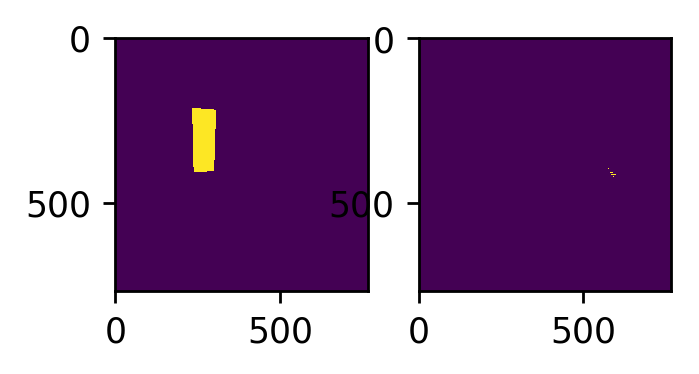

210


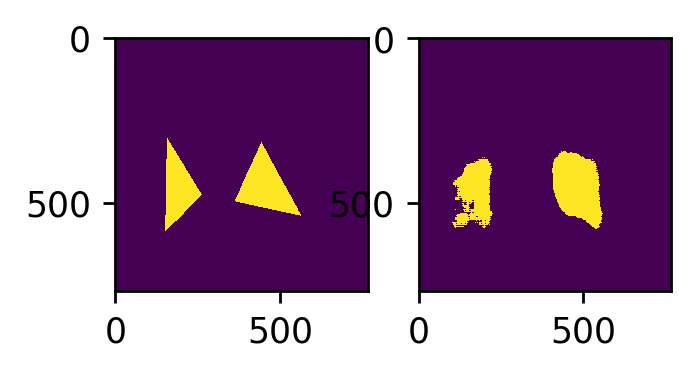

211


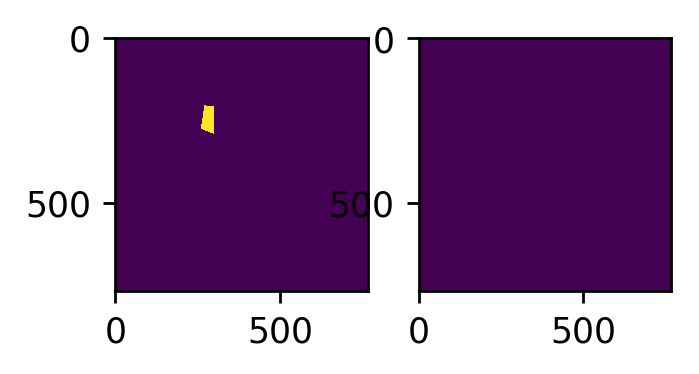

212


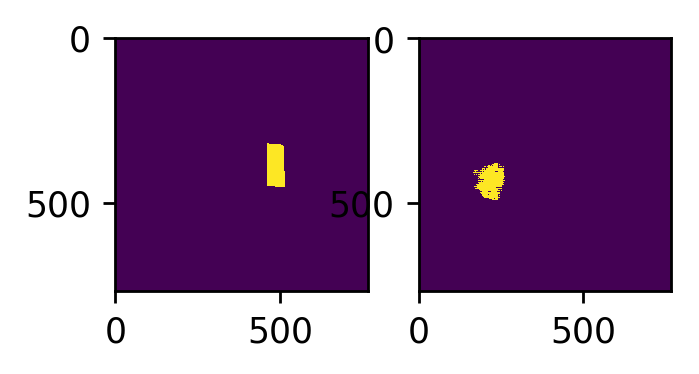

213


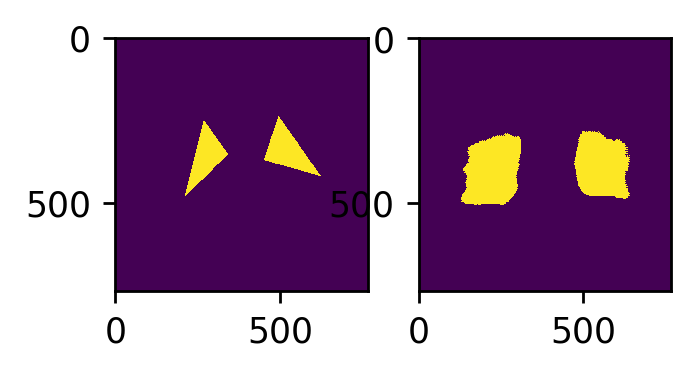

214


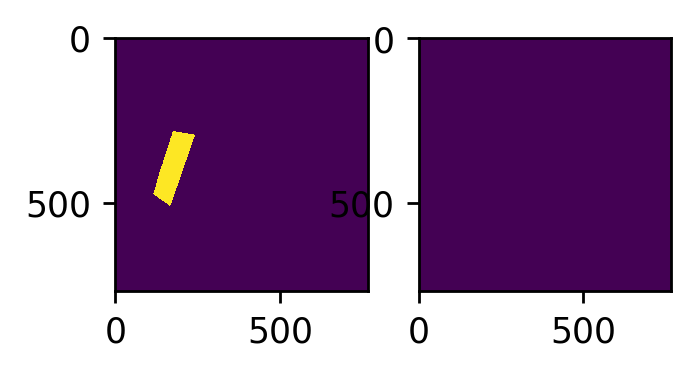

215


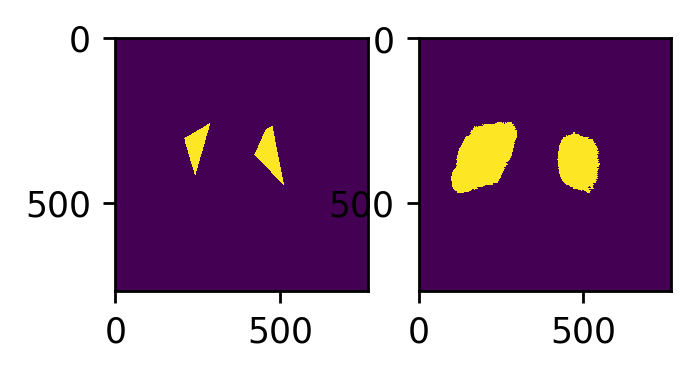

216


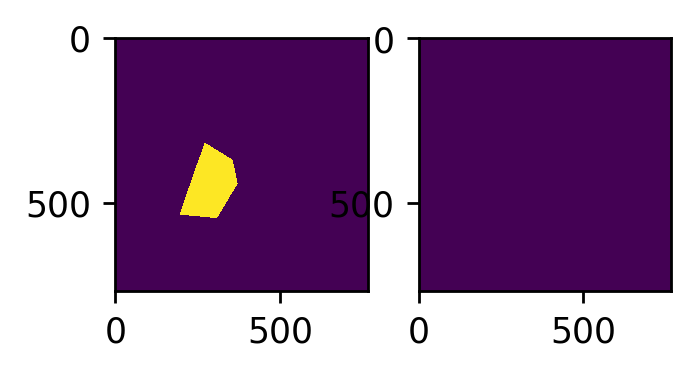

217


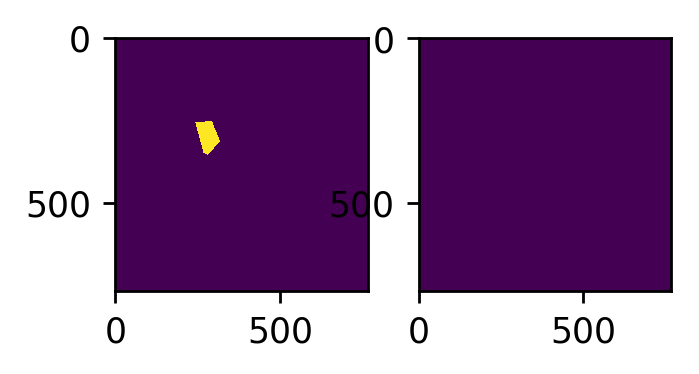

218


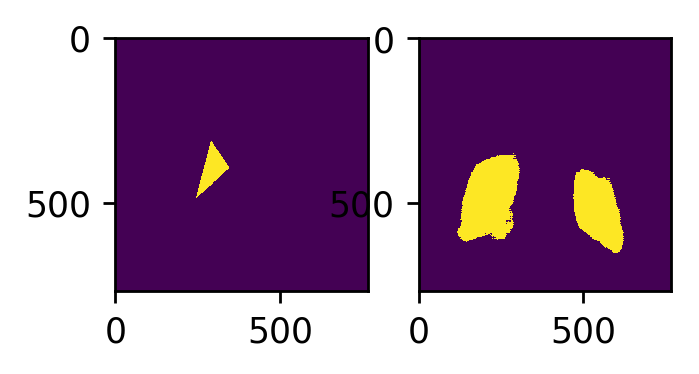

219


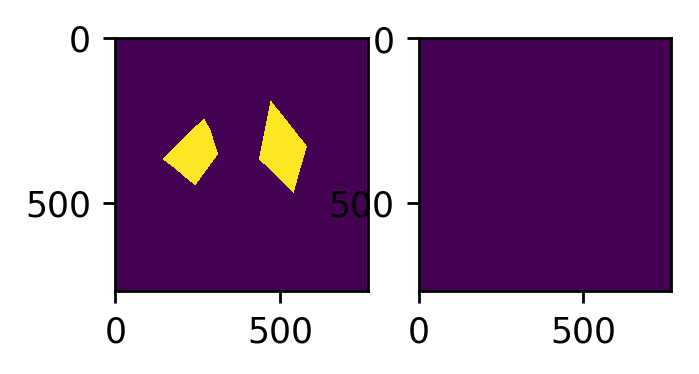

220


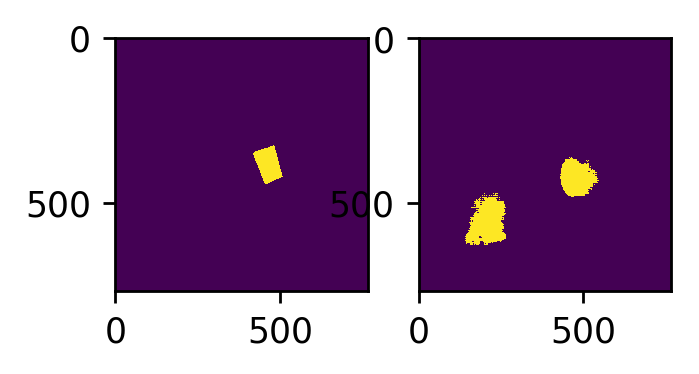

221


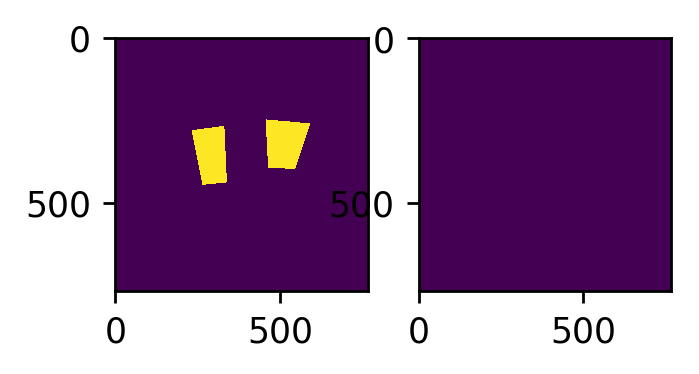

222


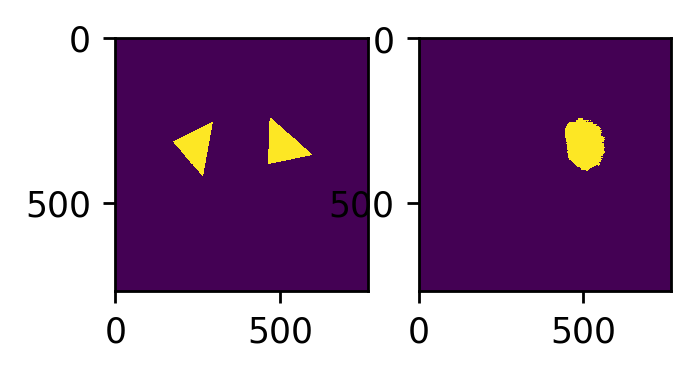

223


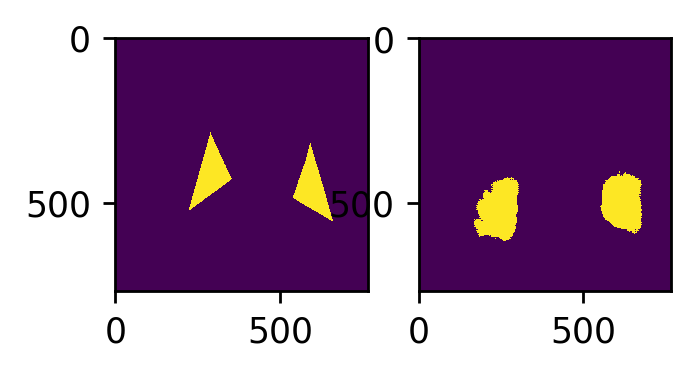

224


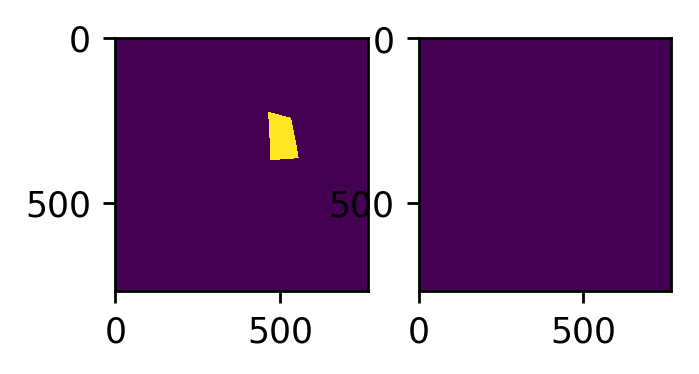

225


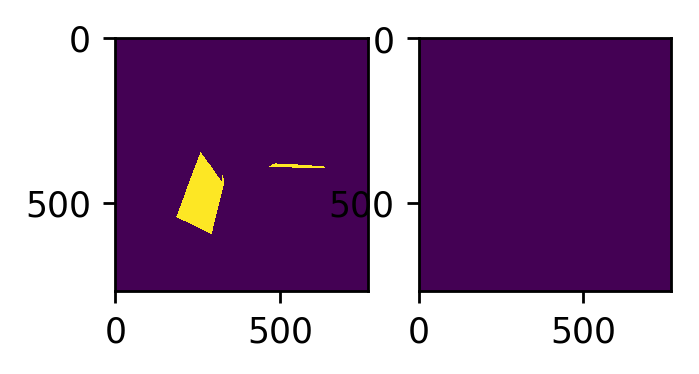

226


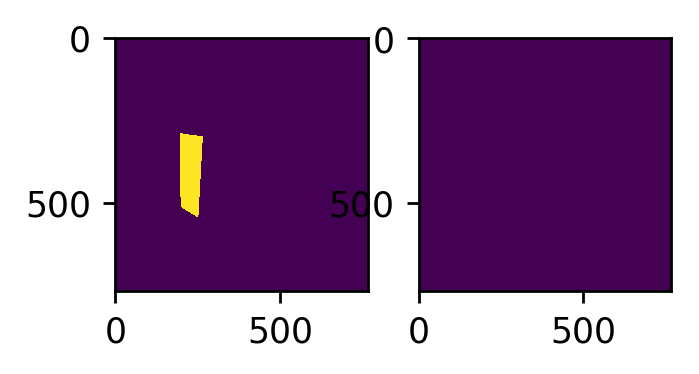

227


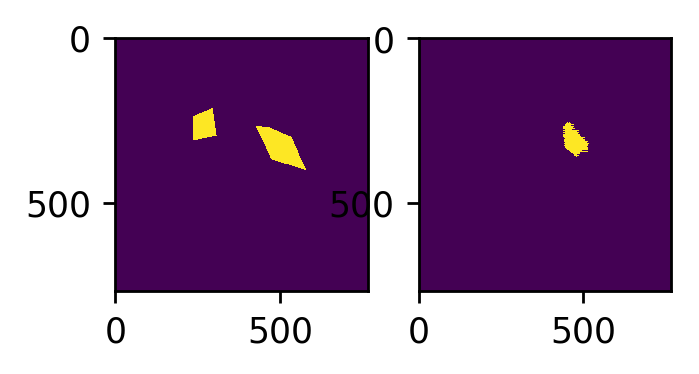

228


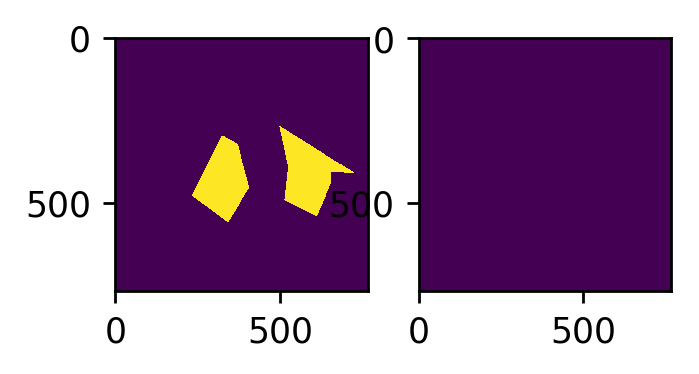

229


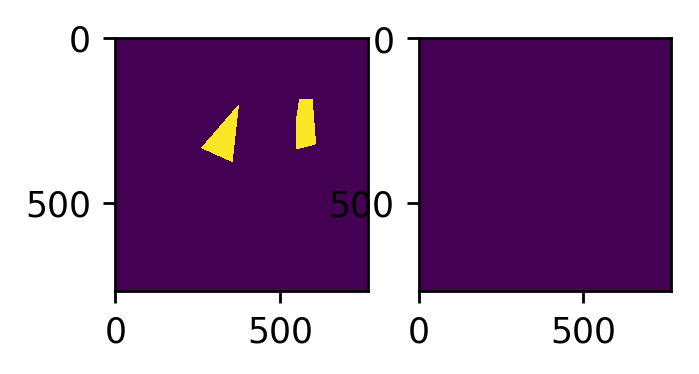

230


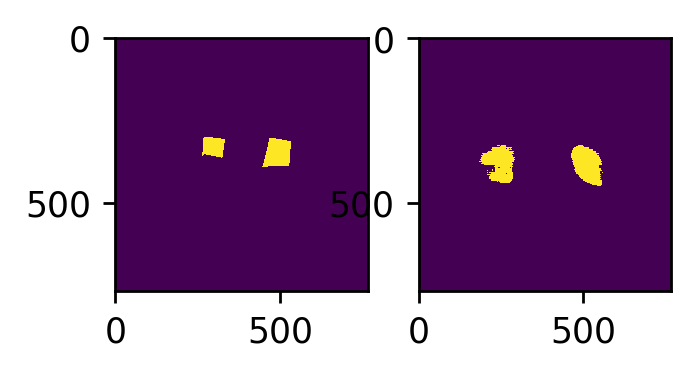

231


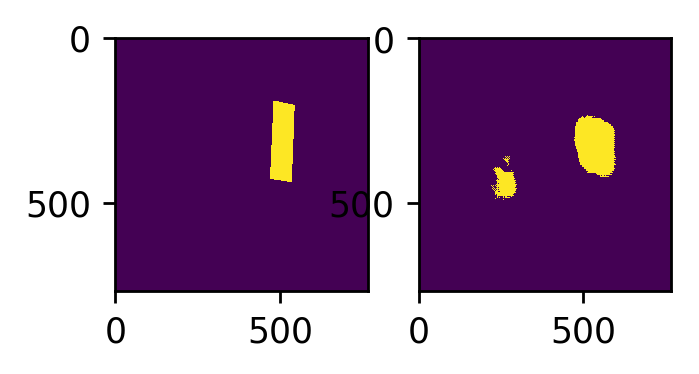

232


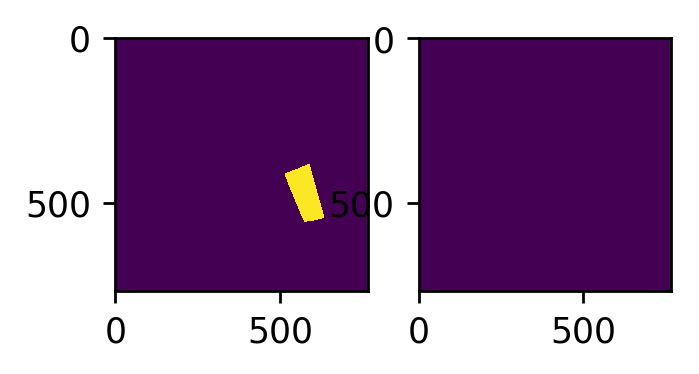

233


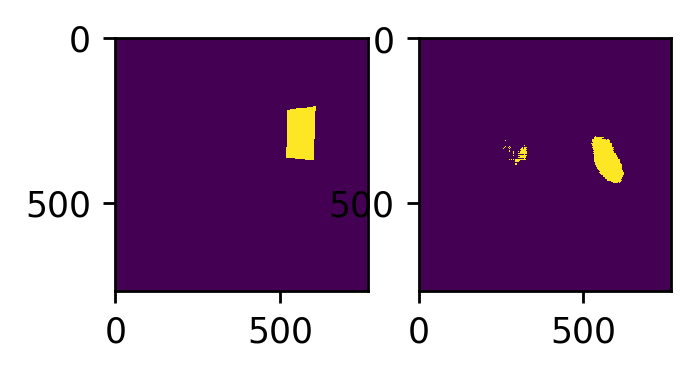

234


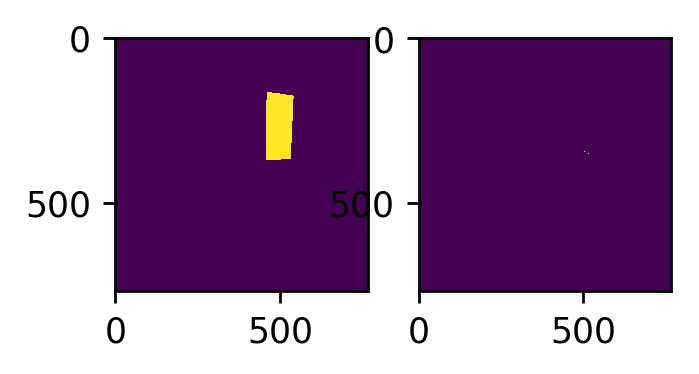

235


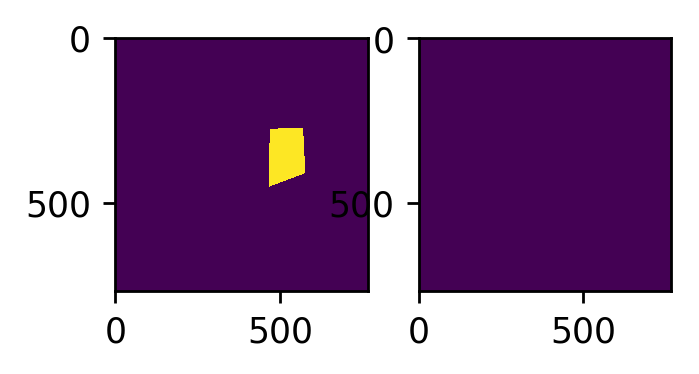

236


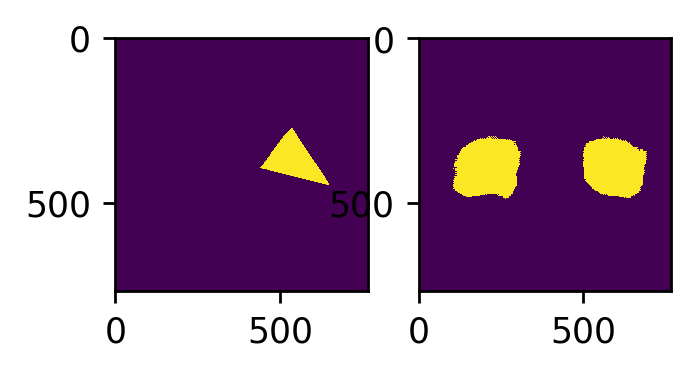

237


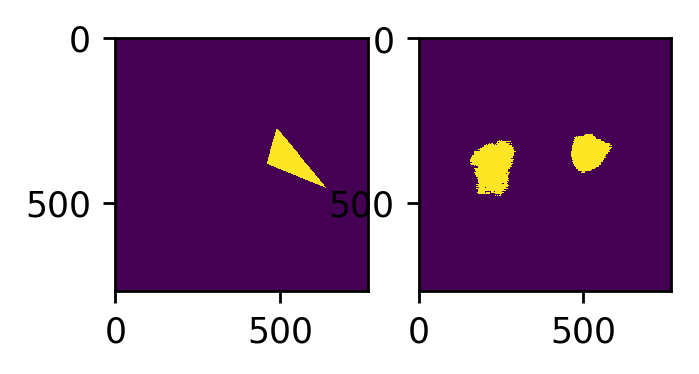

238


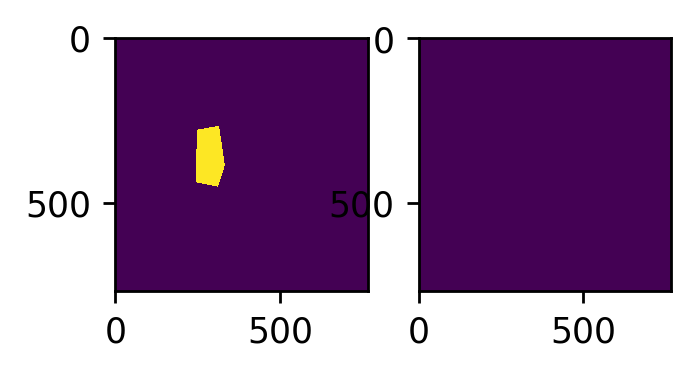

239


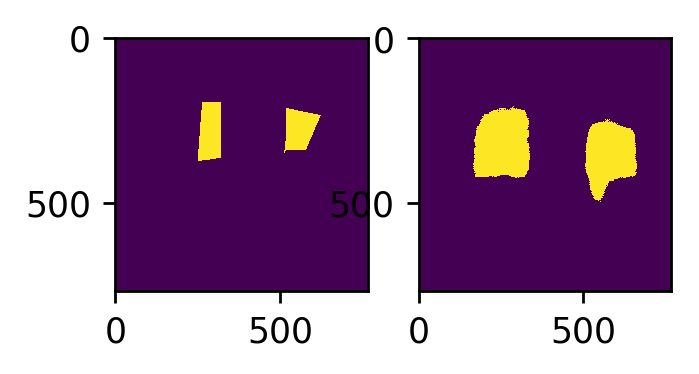

240


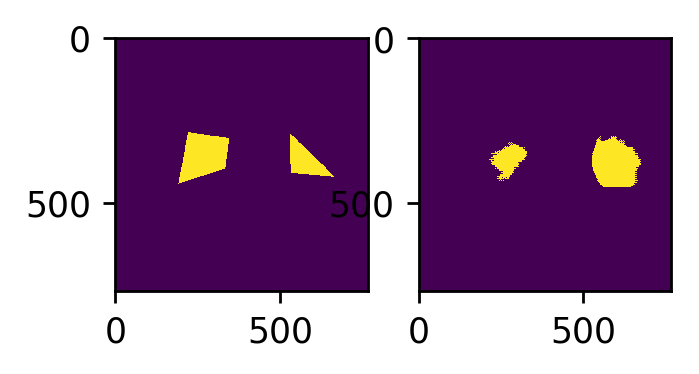

241


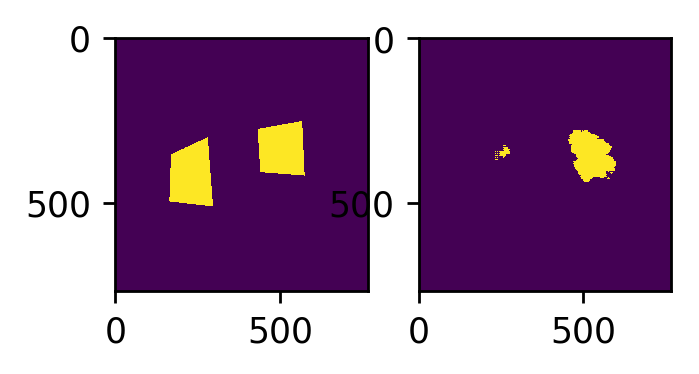

242


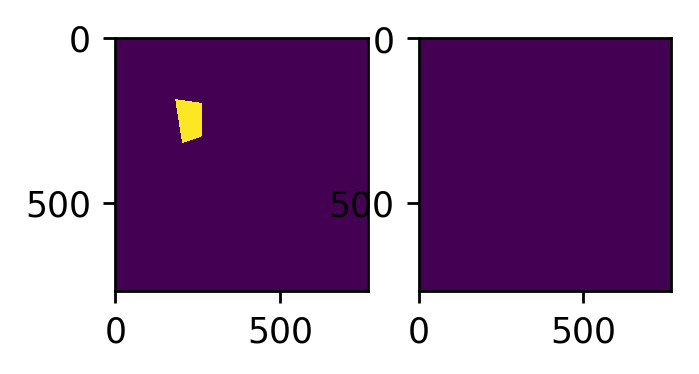

243


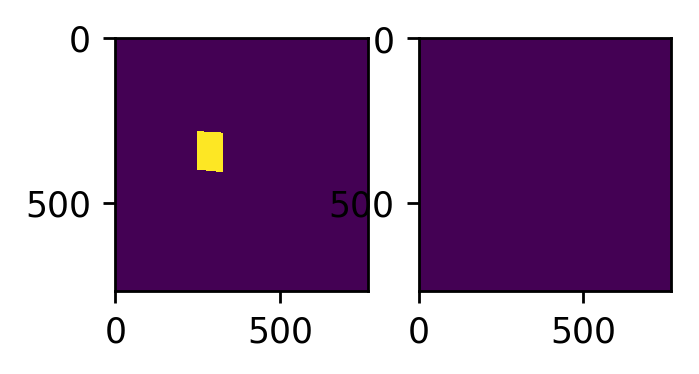

244


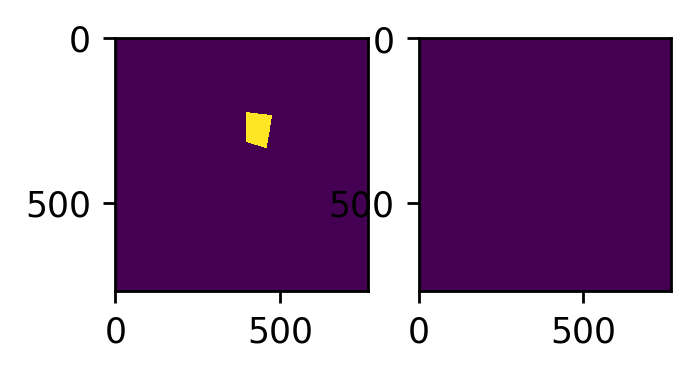

245


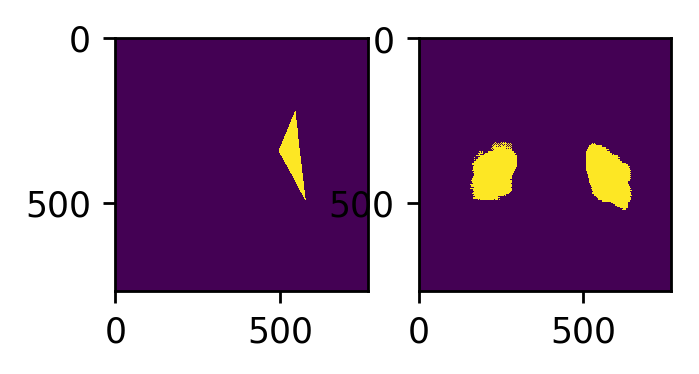

246


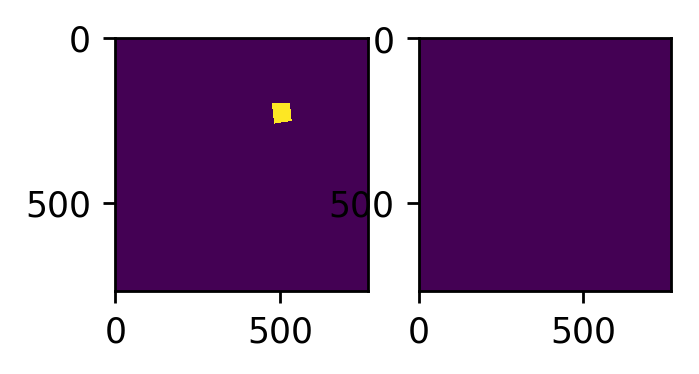

247


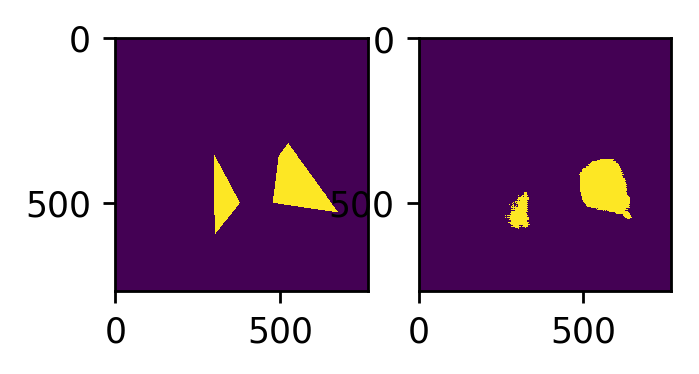

248


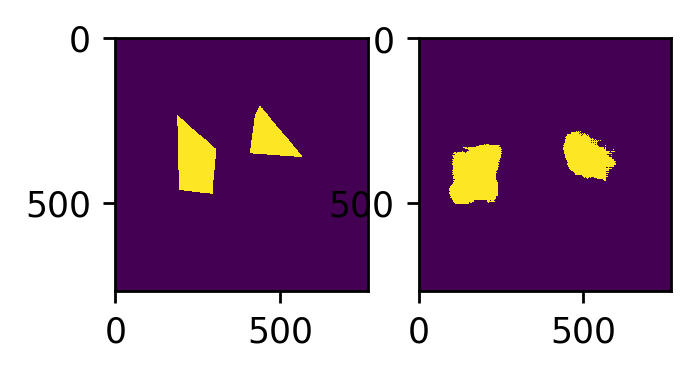

249


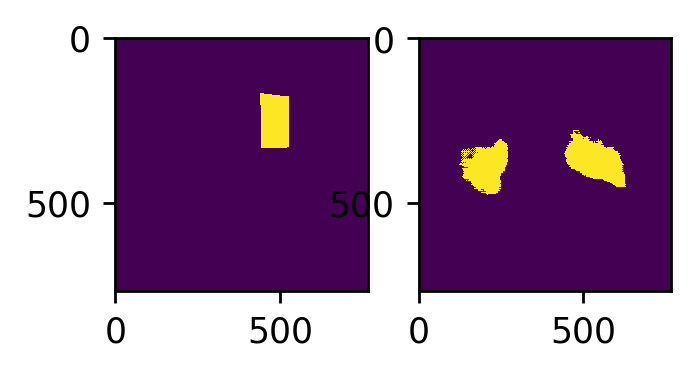

250


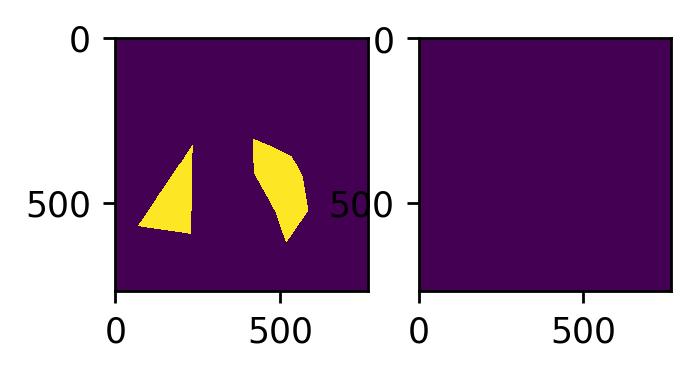

251


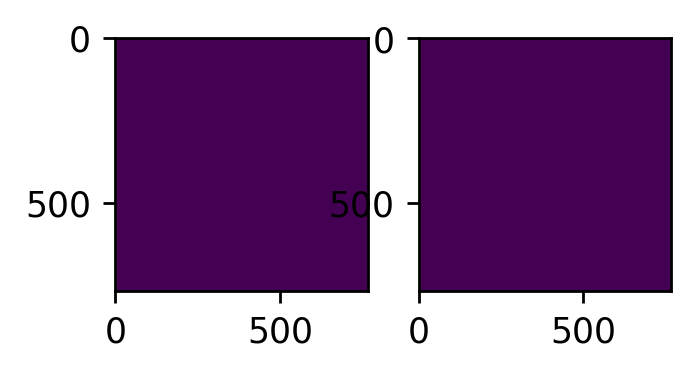

252


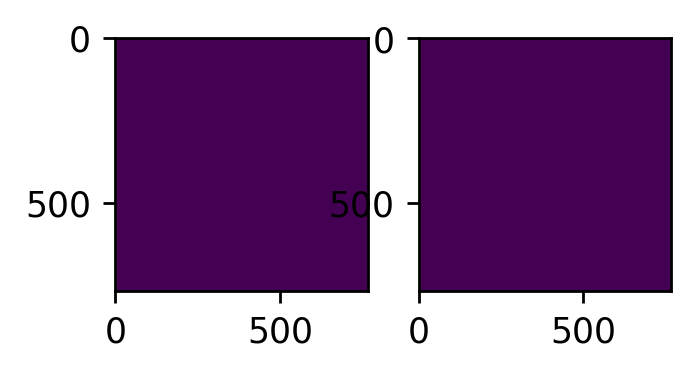

253


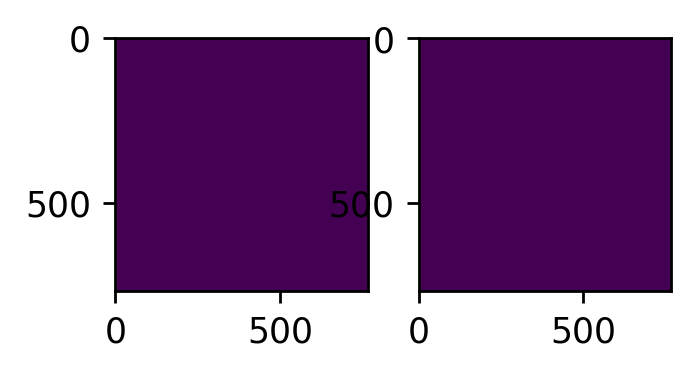

254


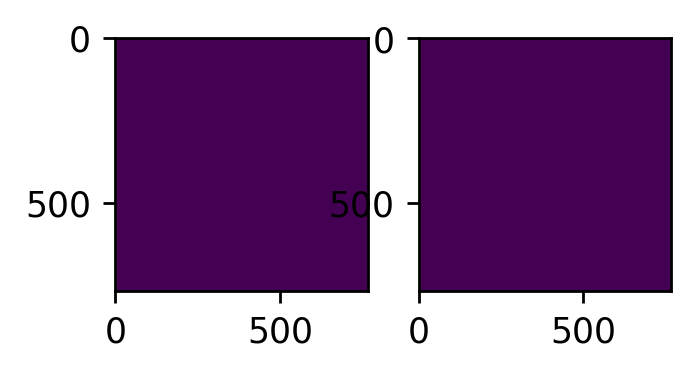

255


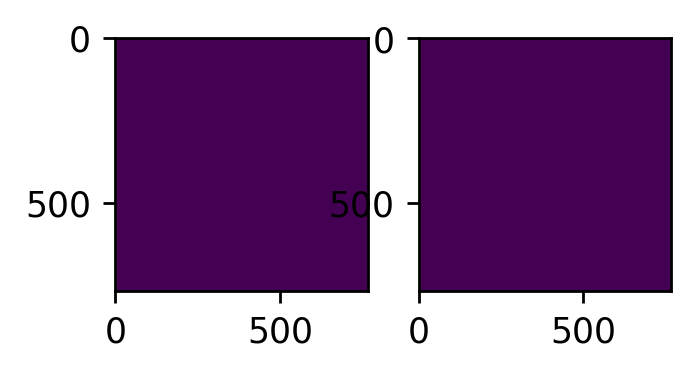

256


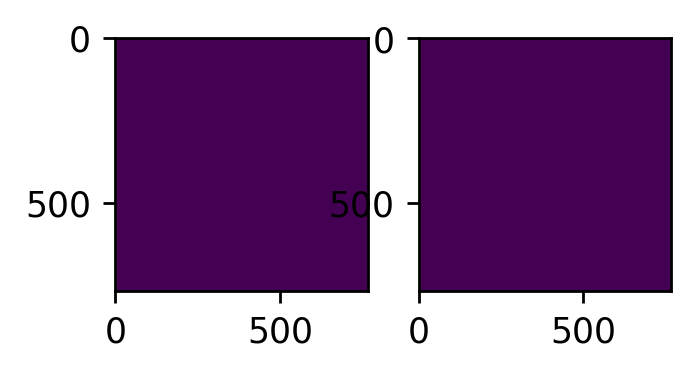

257


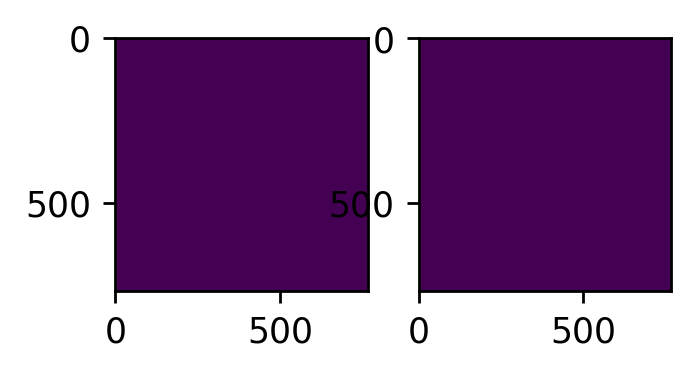

258


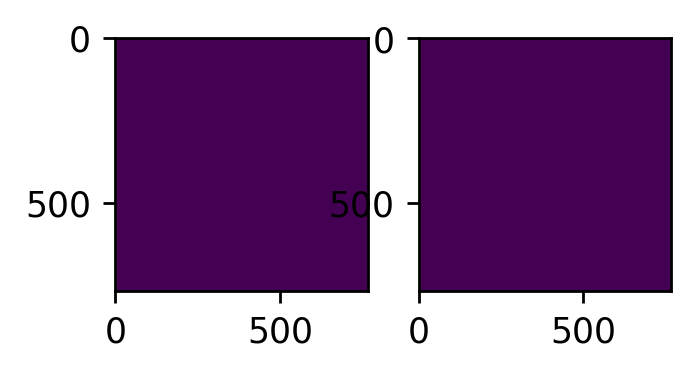

259


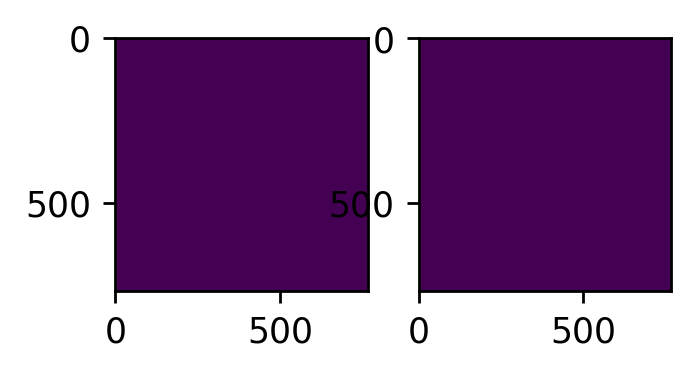

260


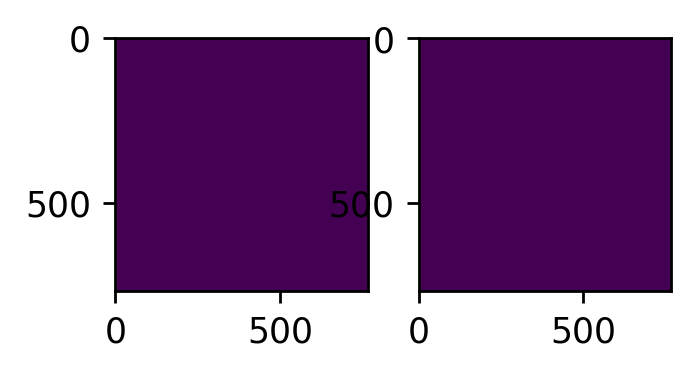

261


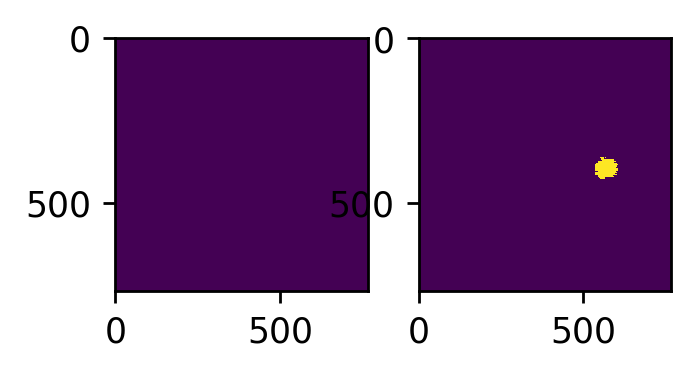

262


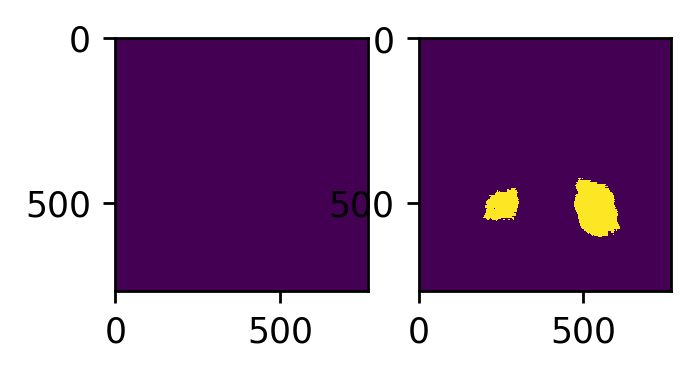

263


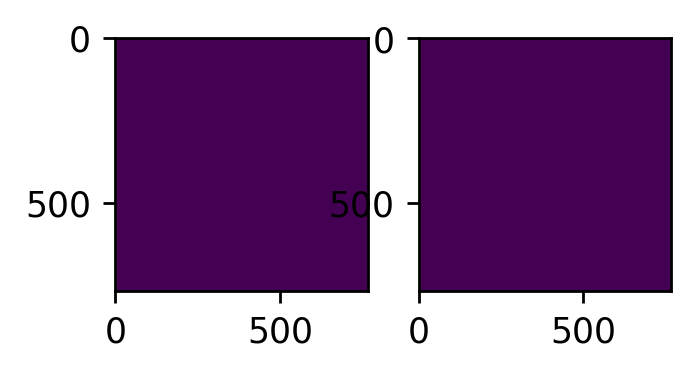

264


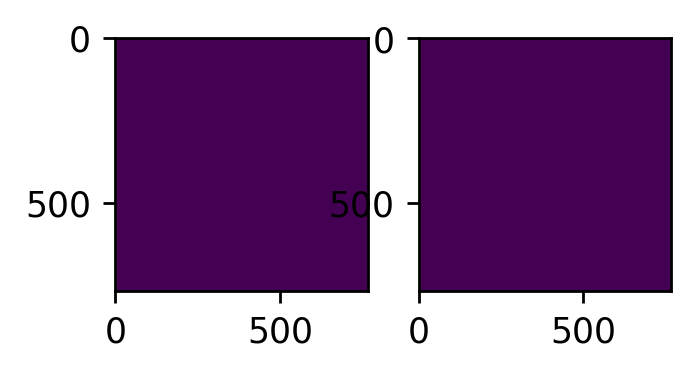

265


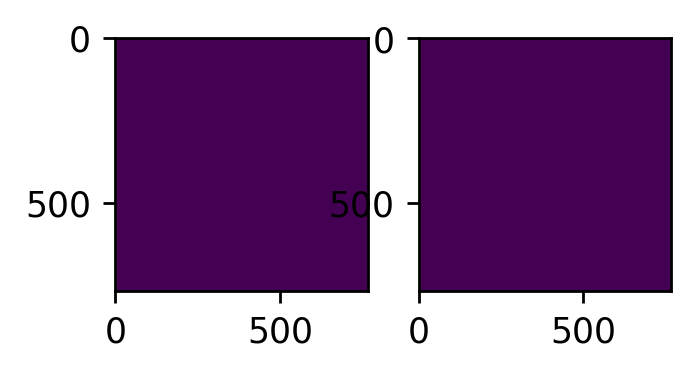

266


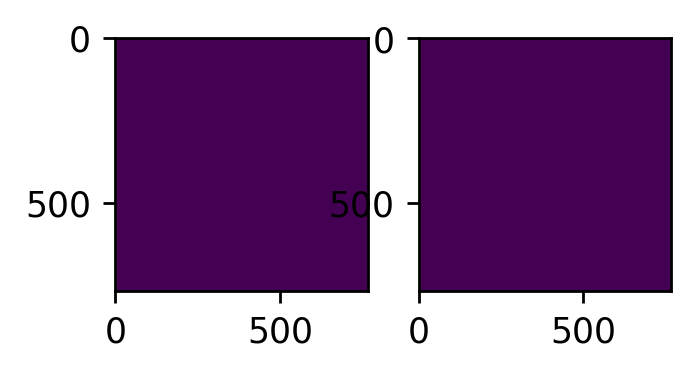

267


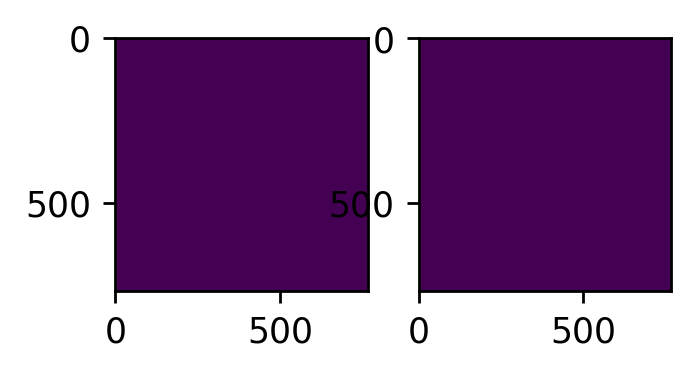

268


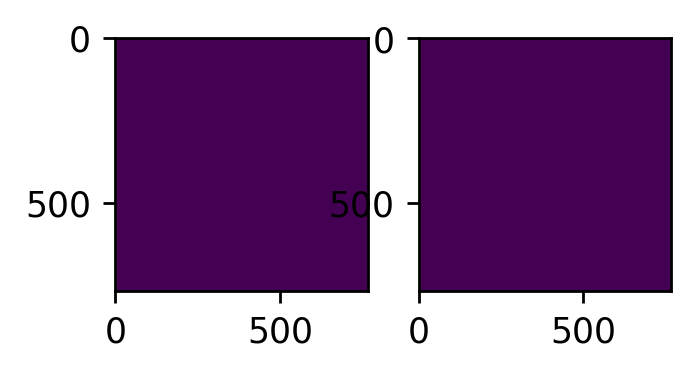

269


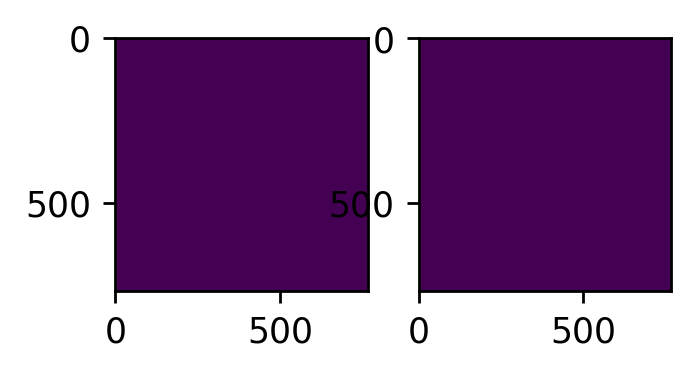

270


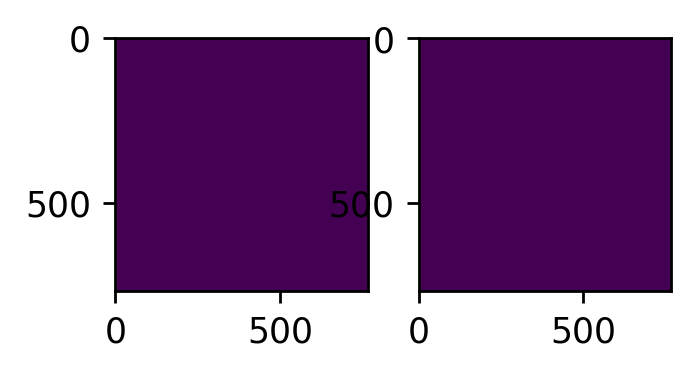

271


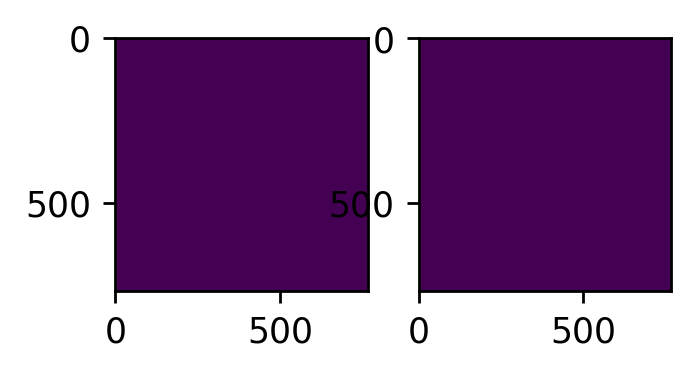

272


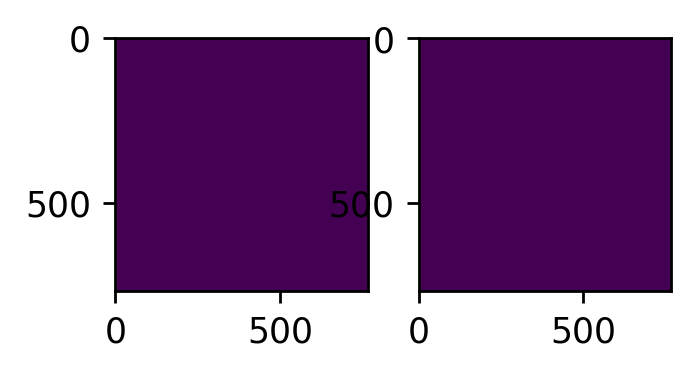

273


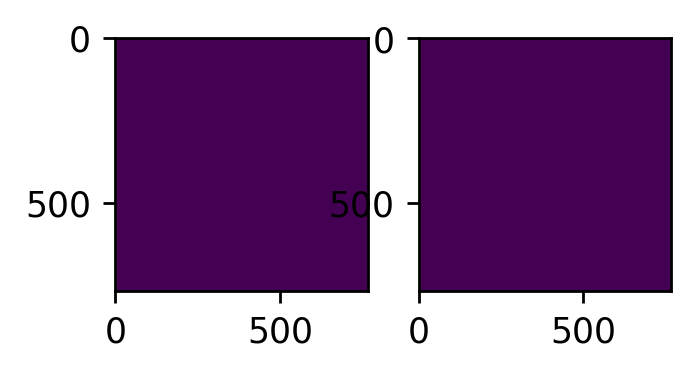

274


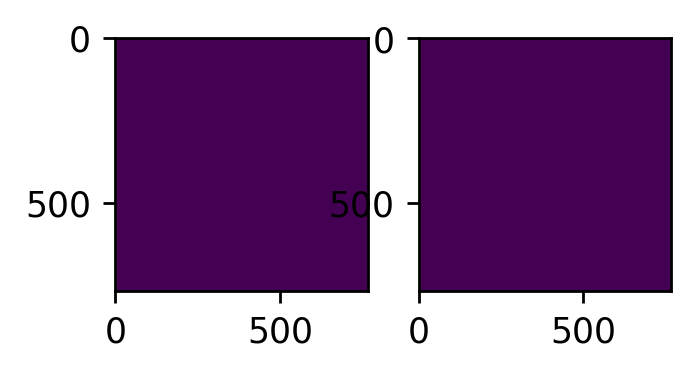

275


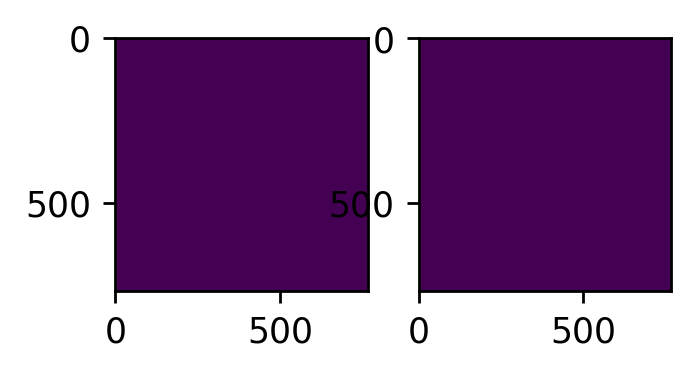

276


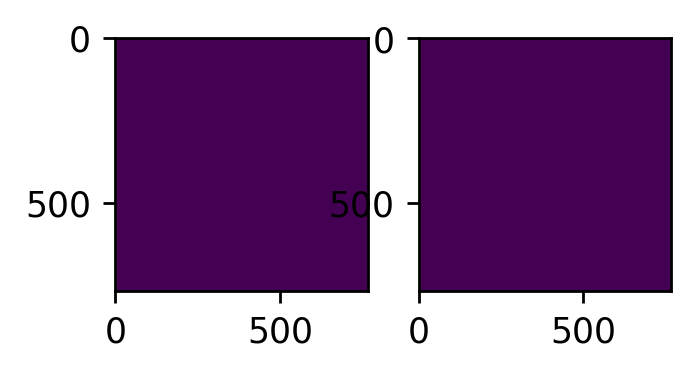

277


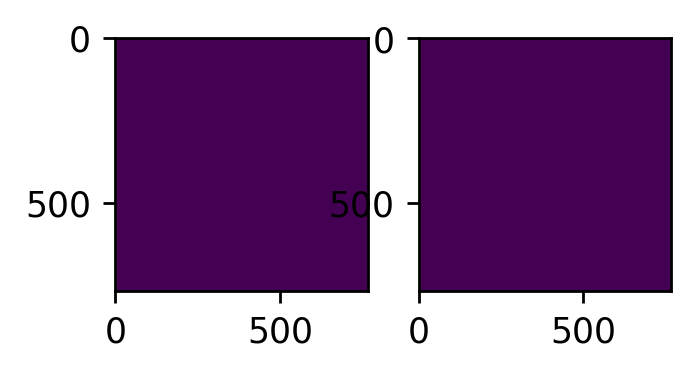

278


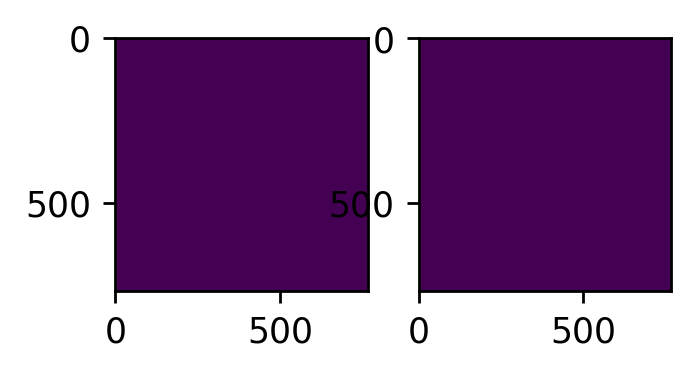

279


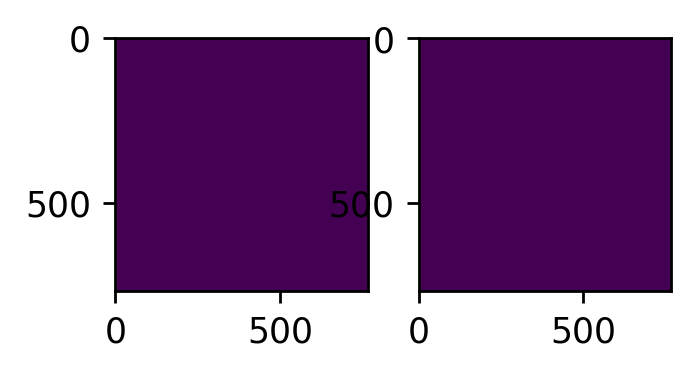

280


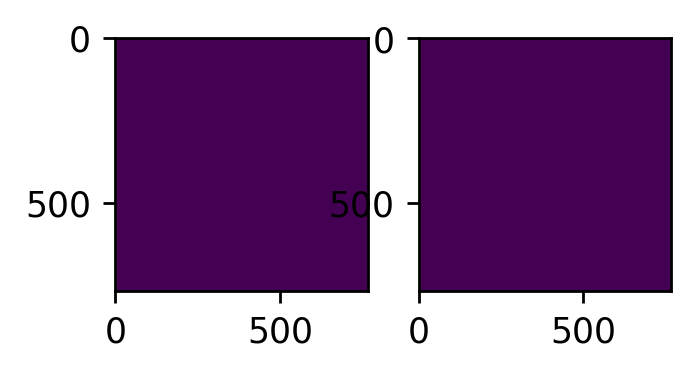

281


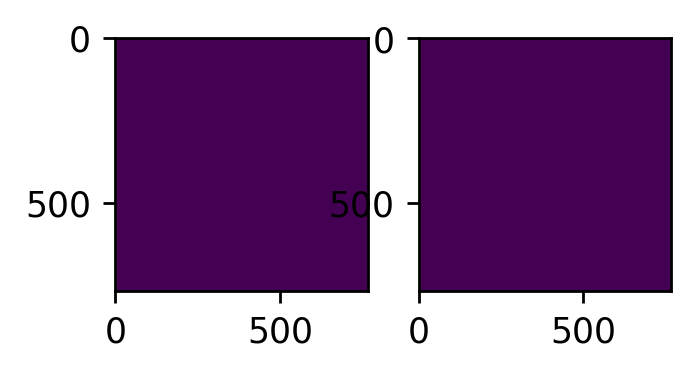

282


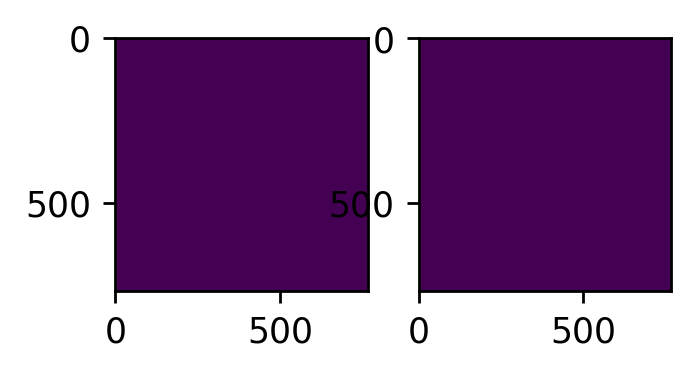

283


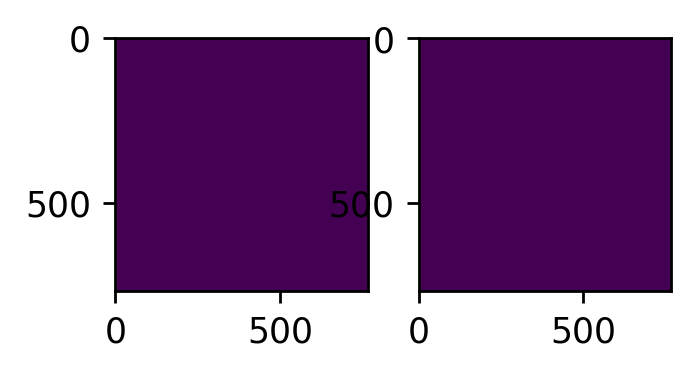

284


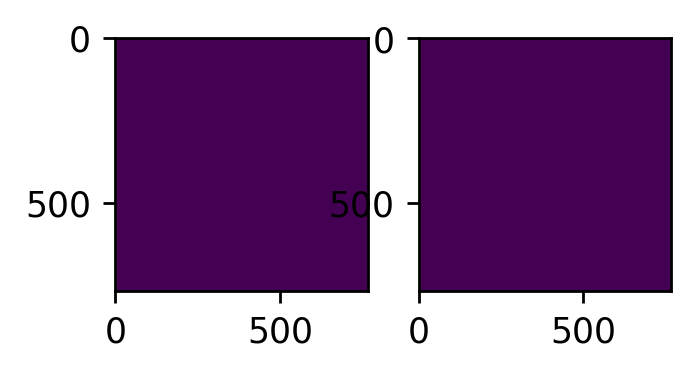

285


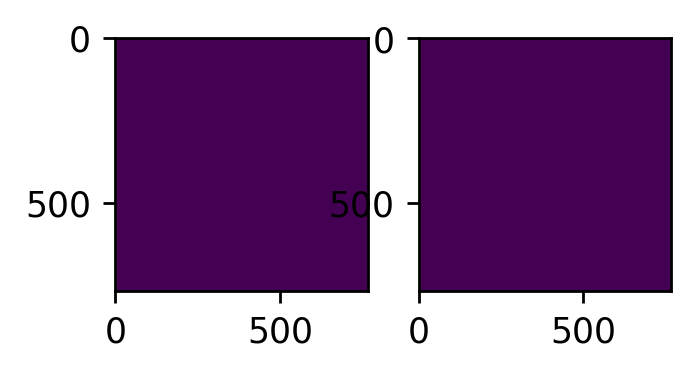

286


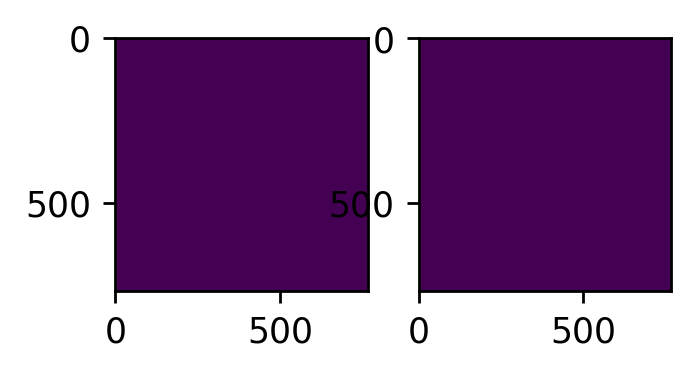

287


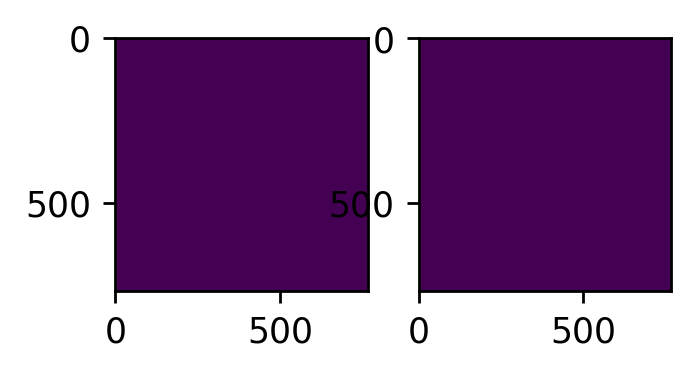

288


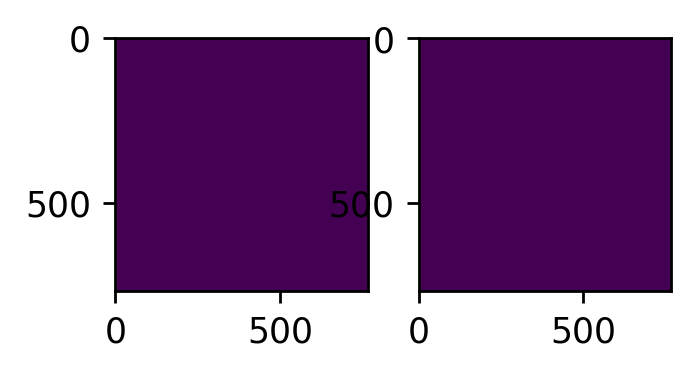

289


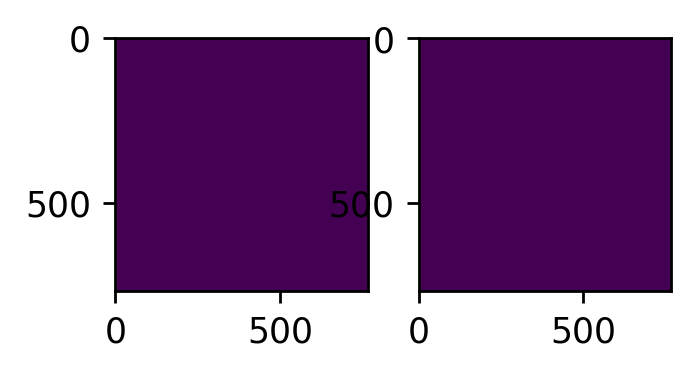

290


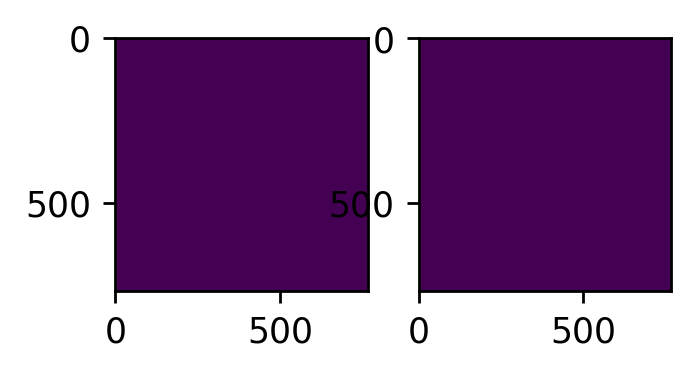

291


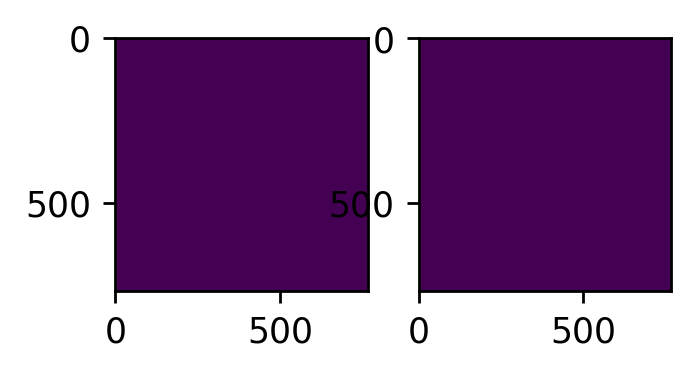

292


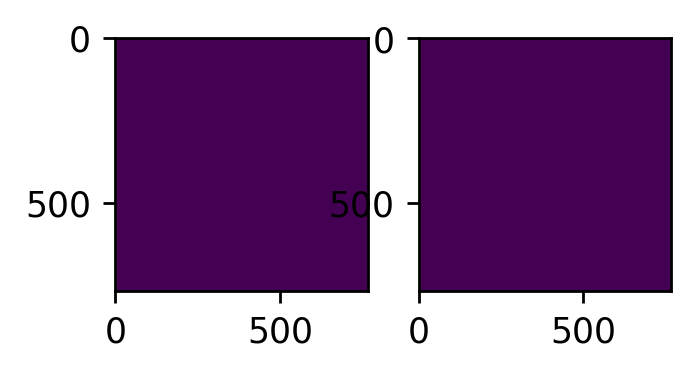

293


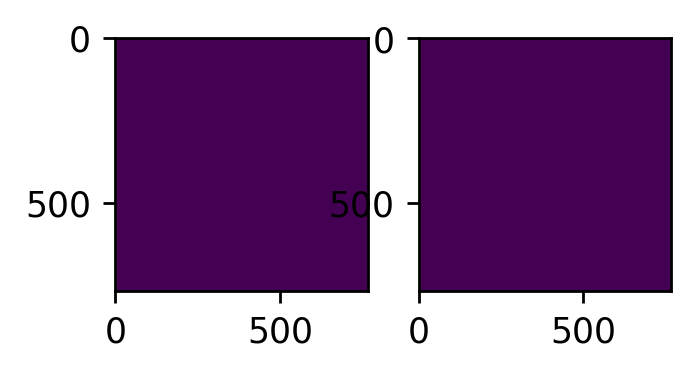

294


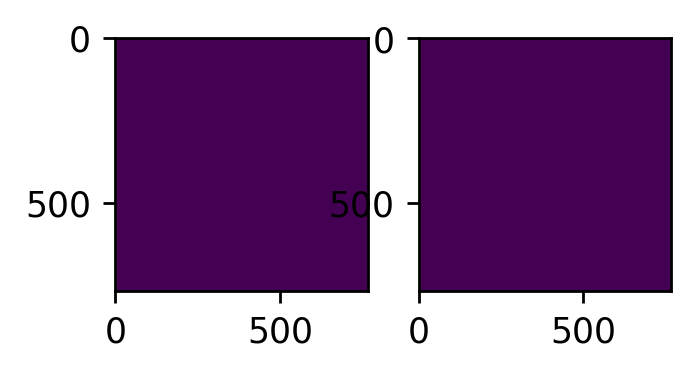

295


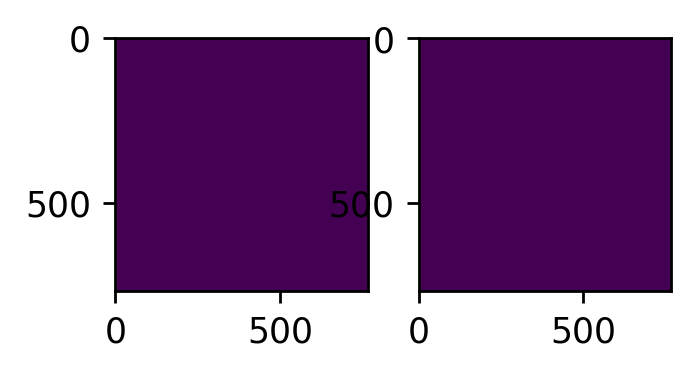

296


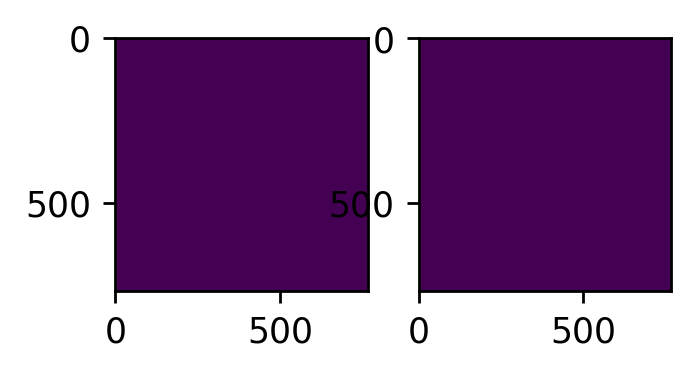

297


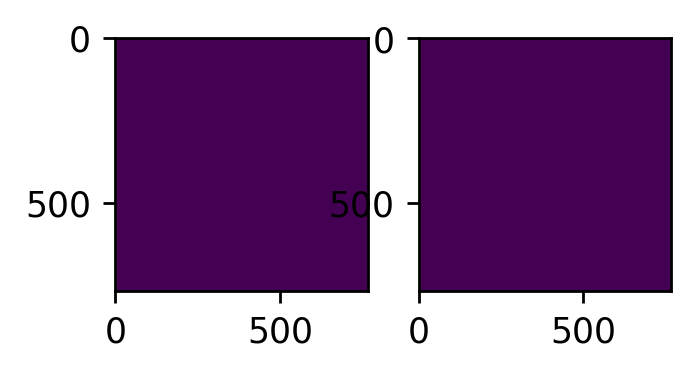

298


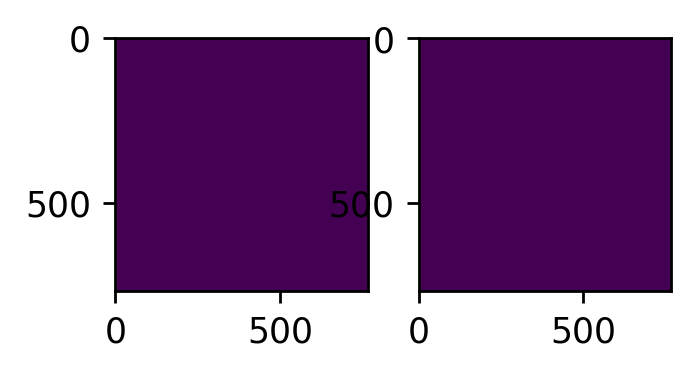

299


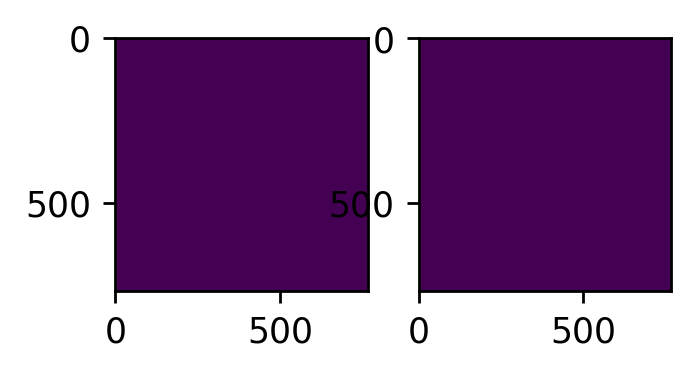

300


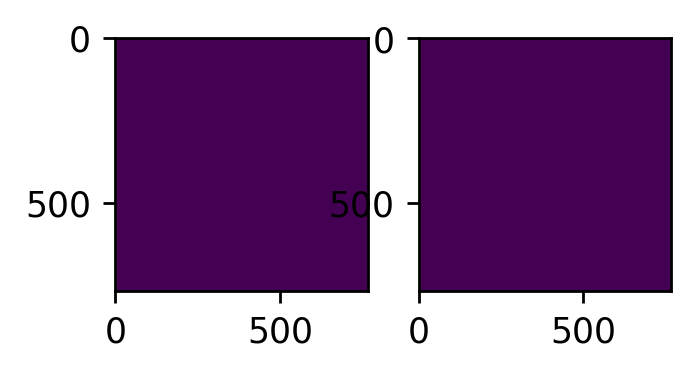

301


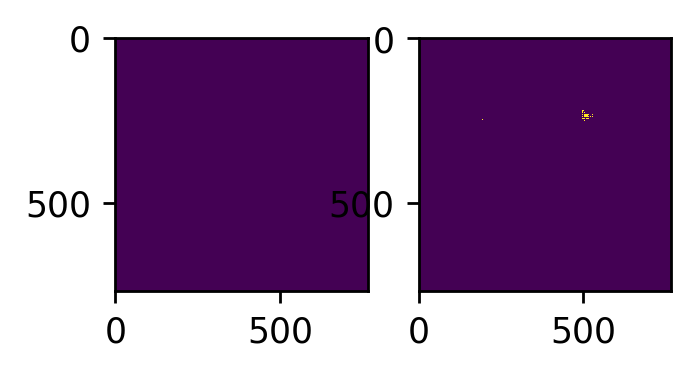

302


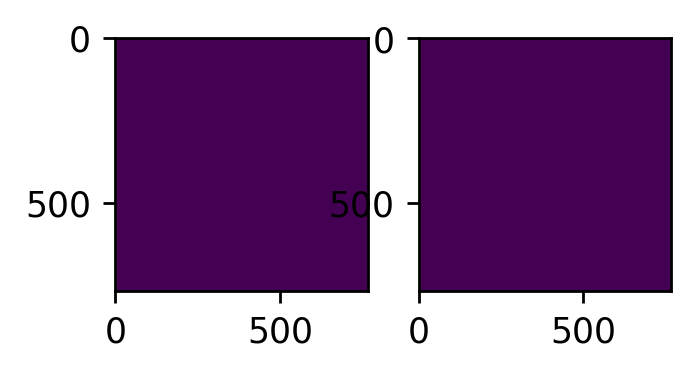

303


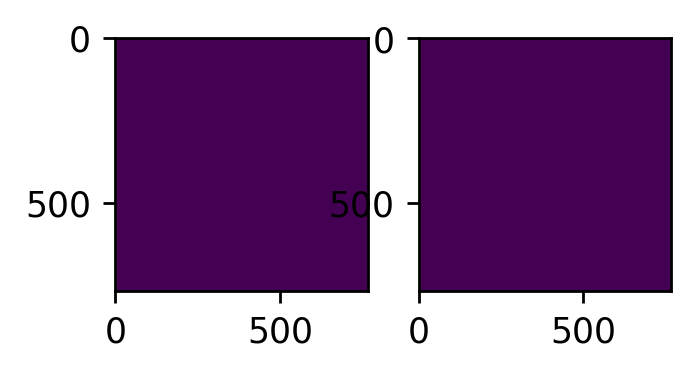

304


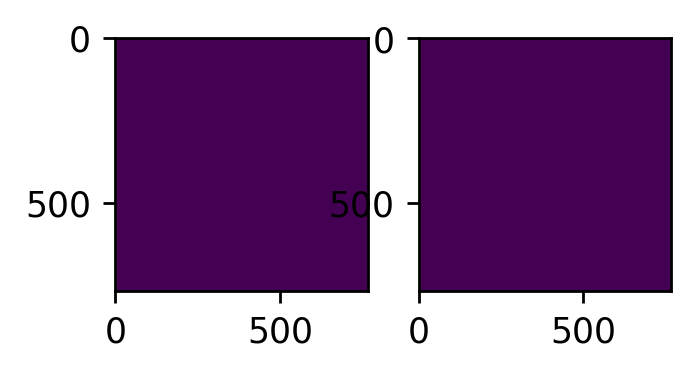

305


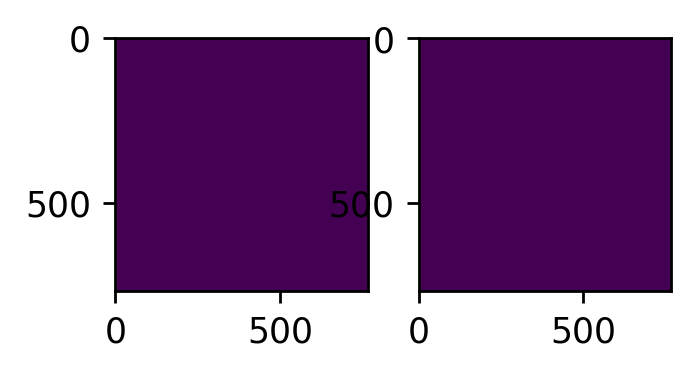

306


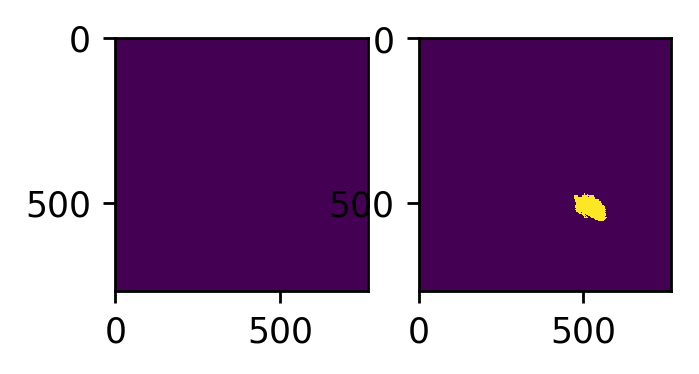

307


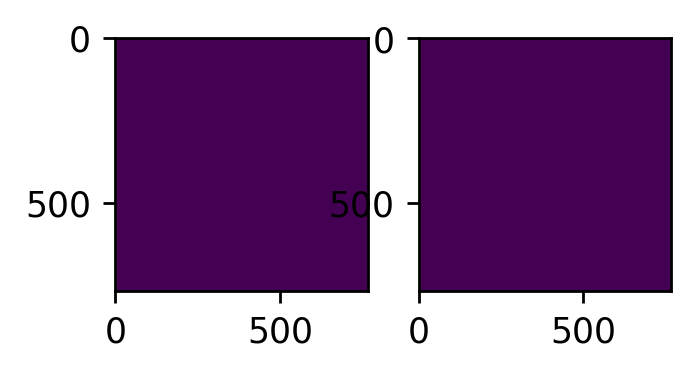

308


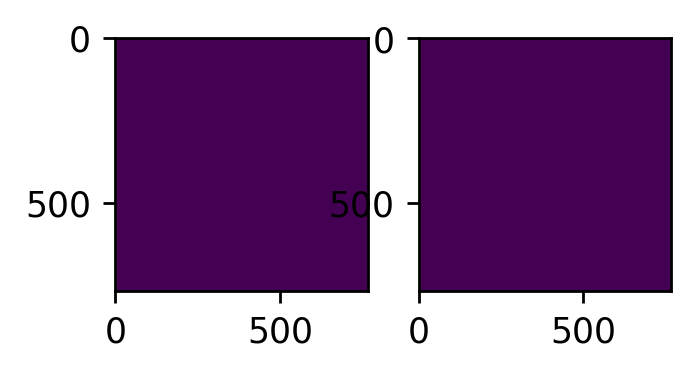

309


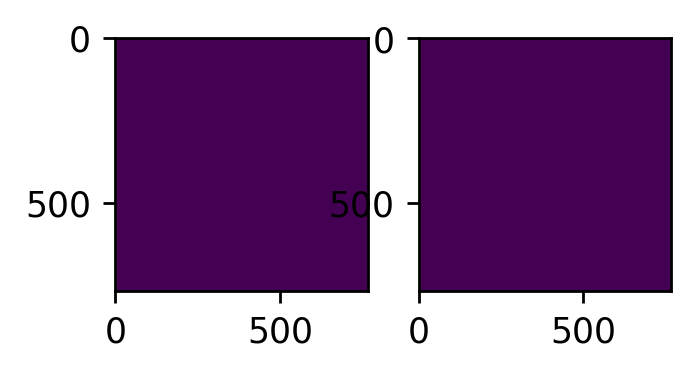

310


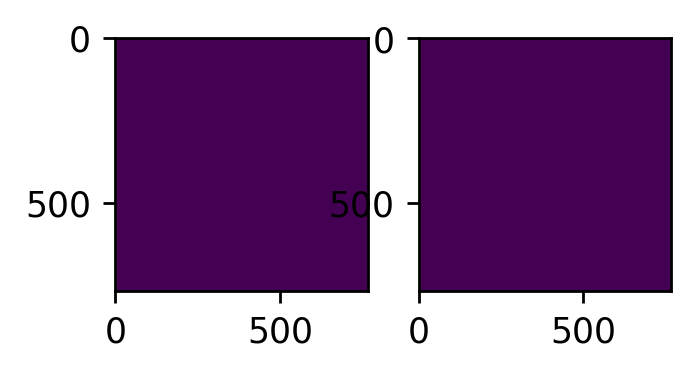

311


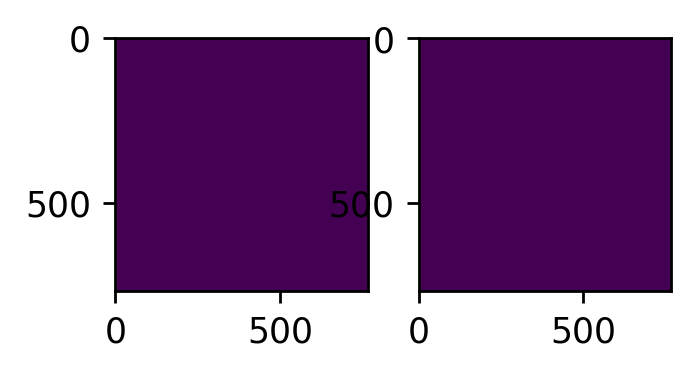

312


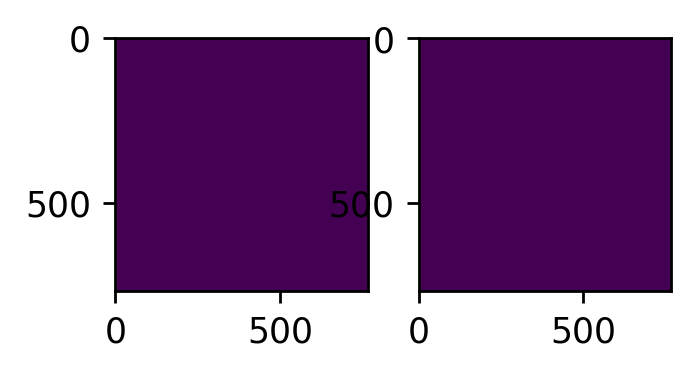

313


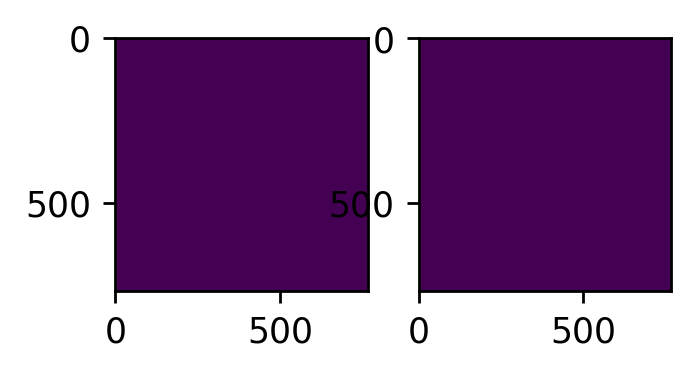

314


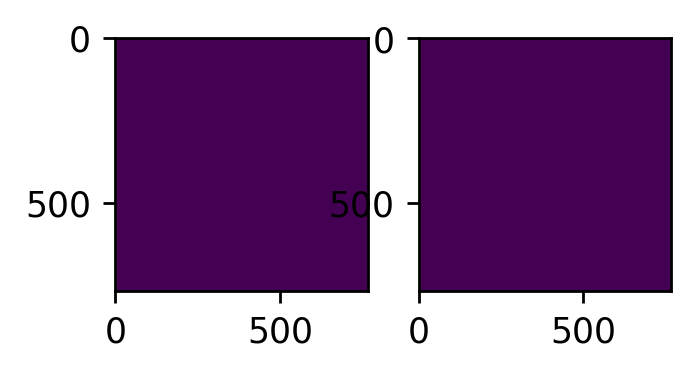

315


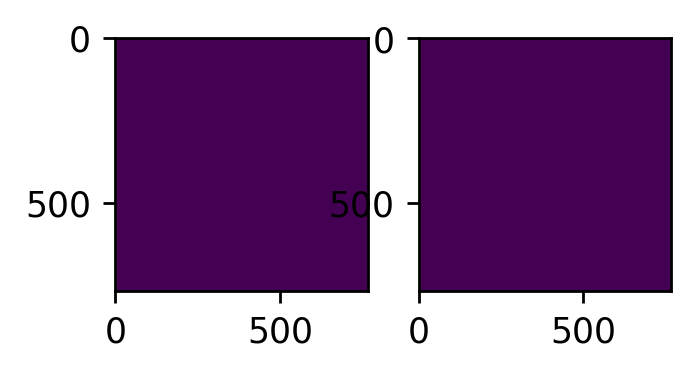

316


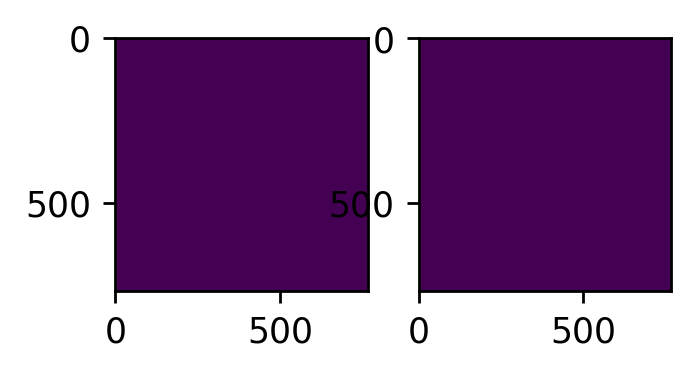

317


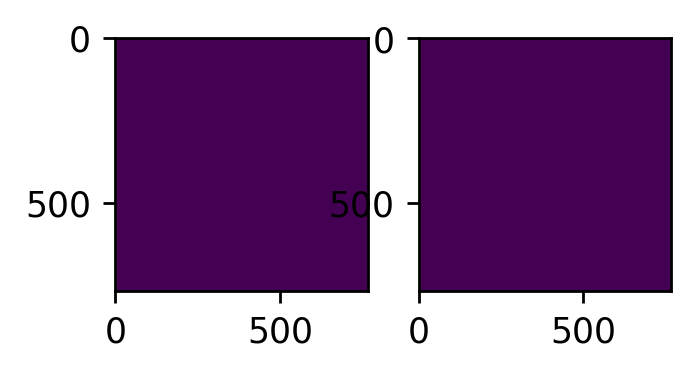

318


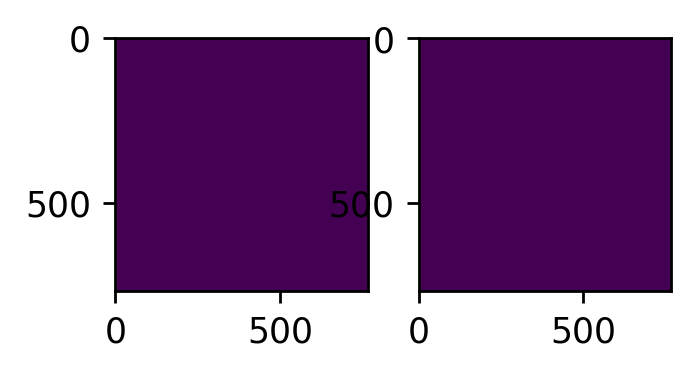

319


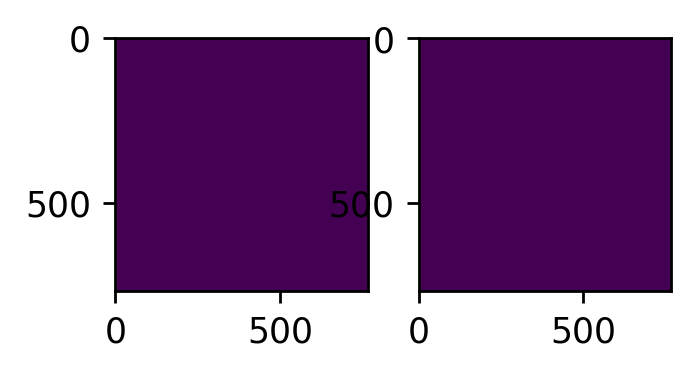

320


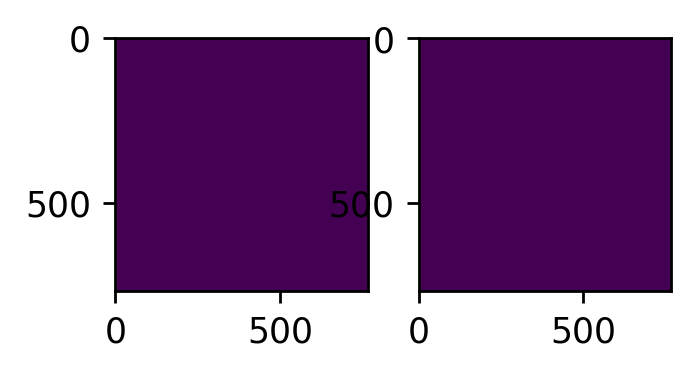

321


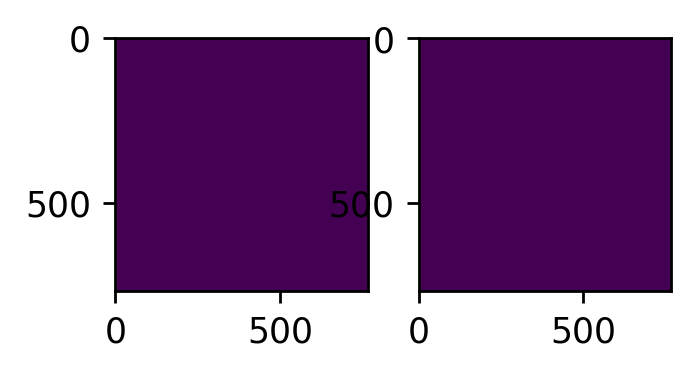

322


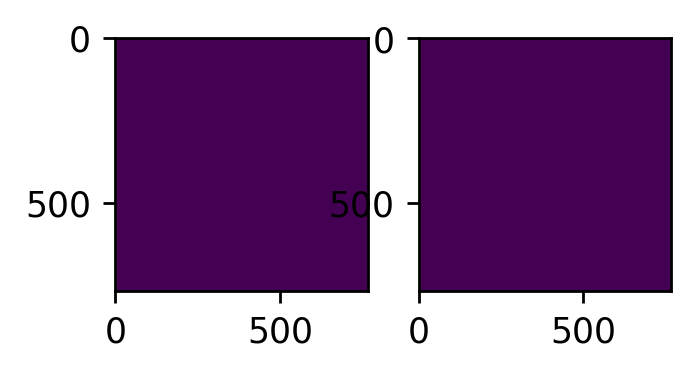

323


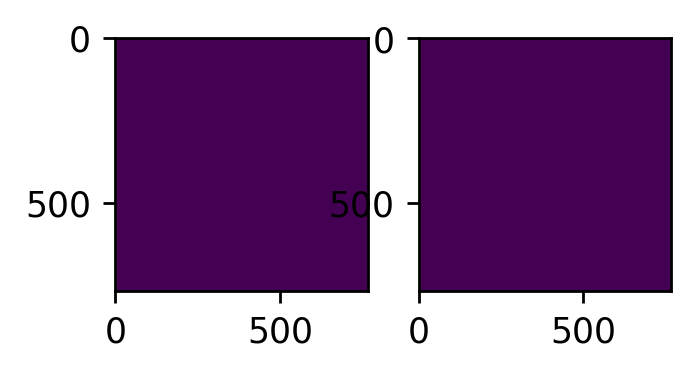

324


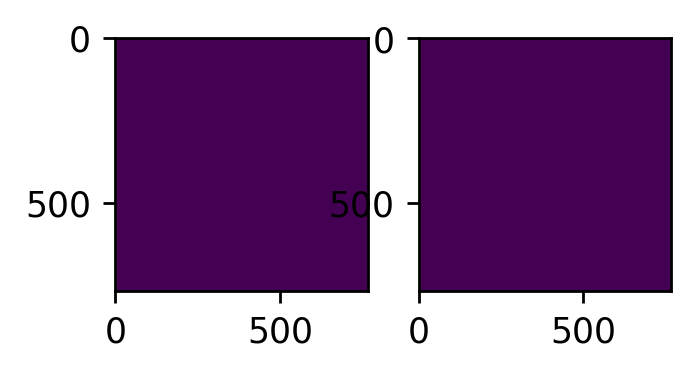

325


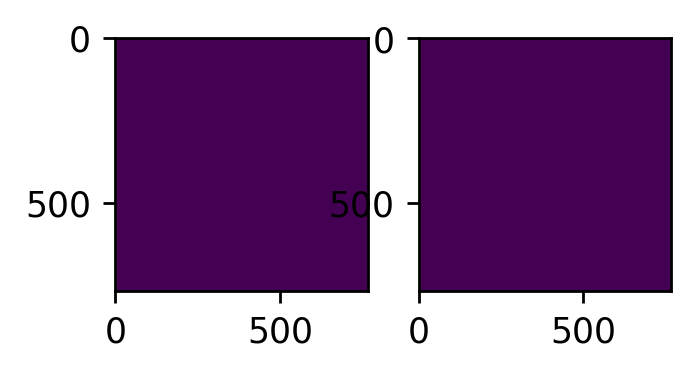

326


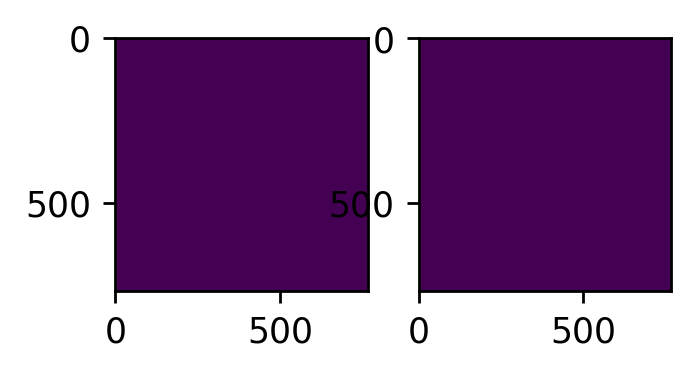

327


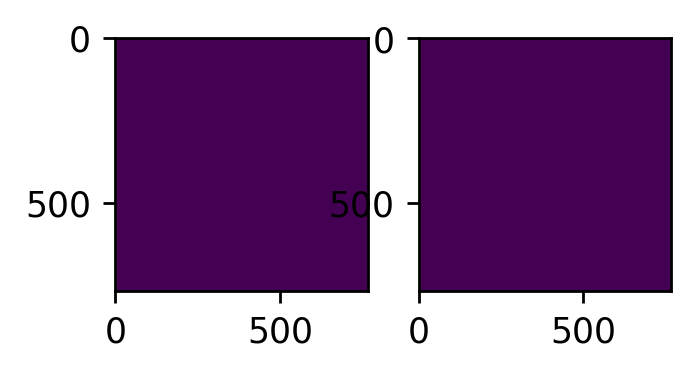

328


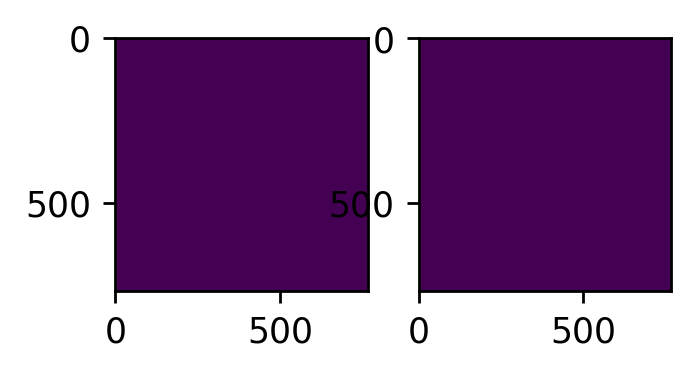

329


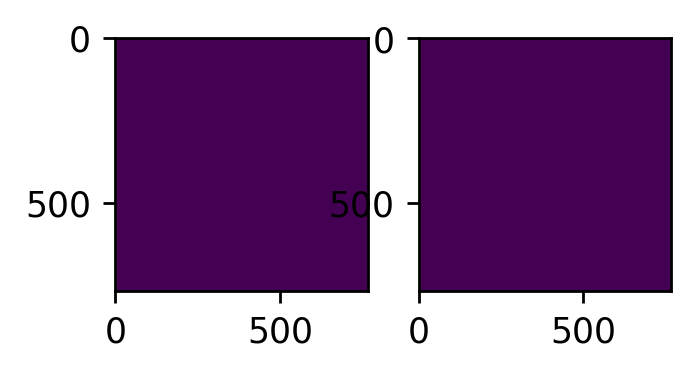

330


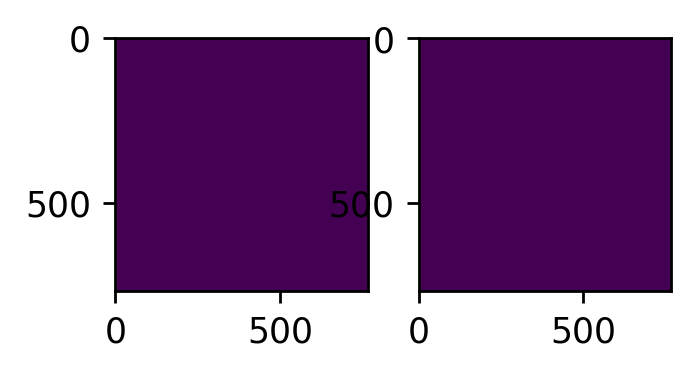

331


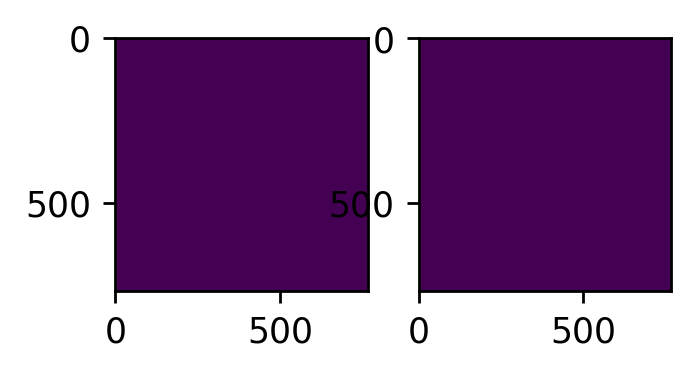

332


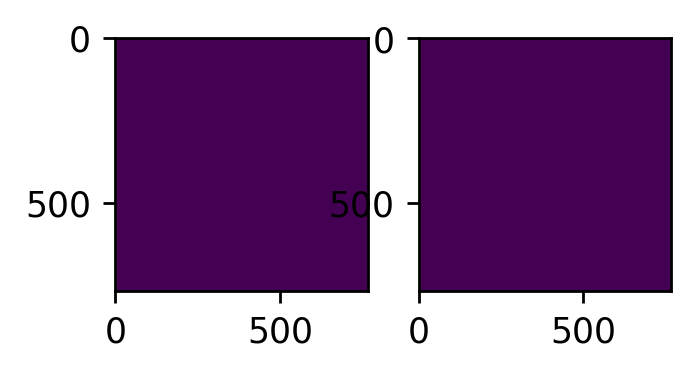

333


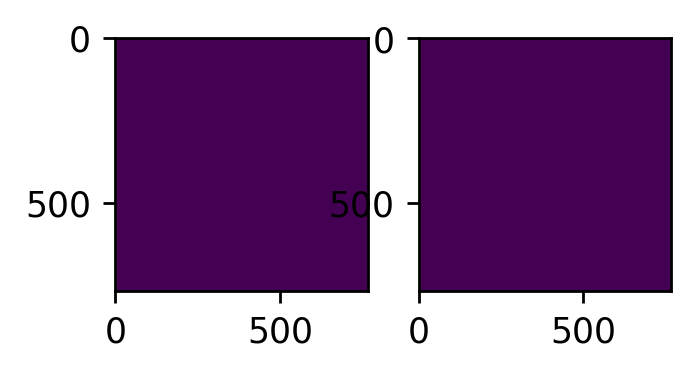

334


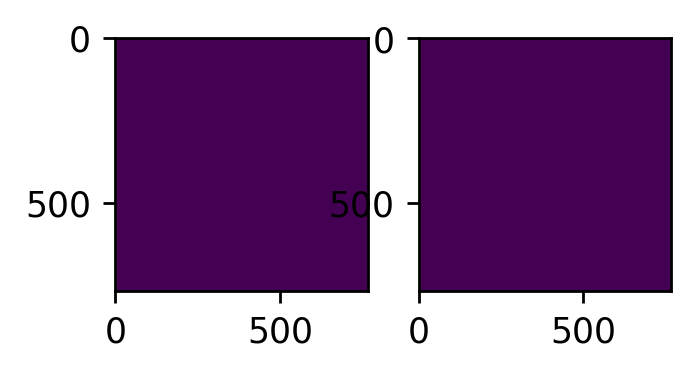

335


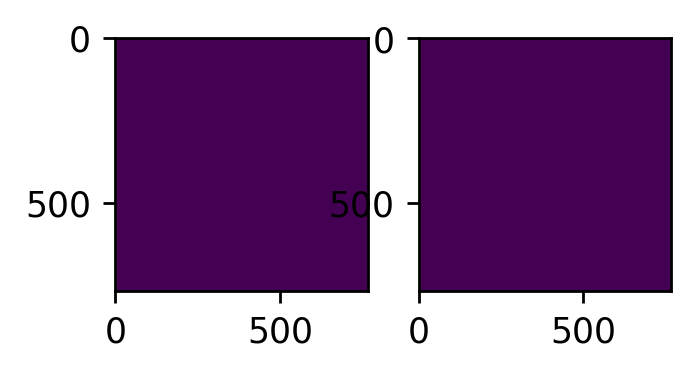

336


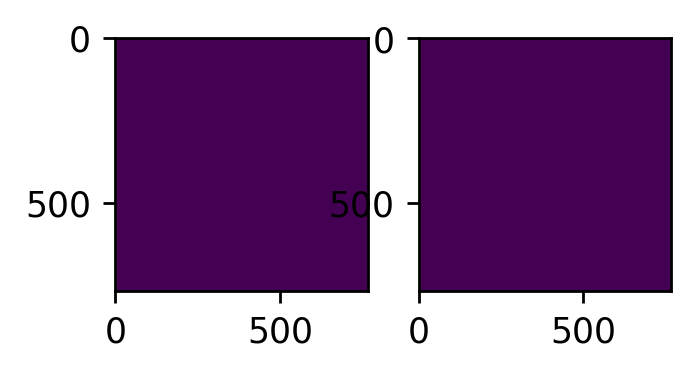

337


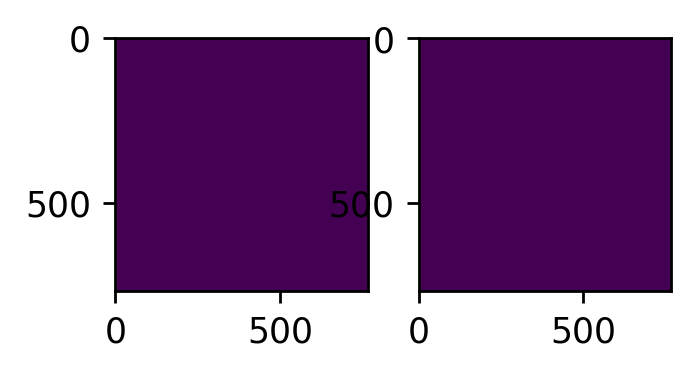

338


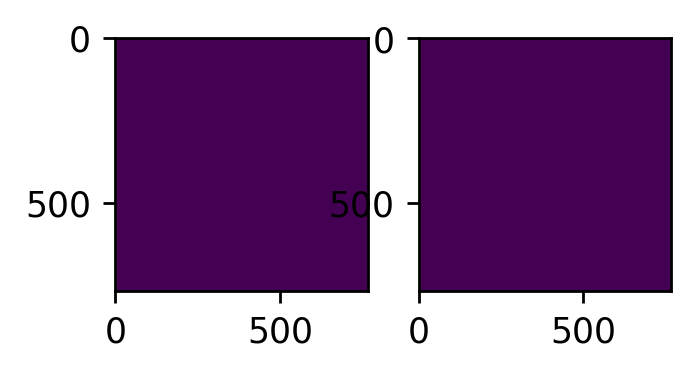

339


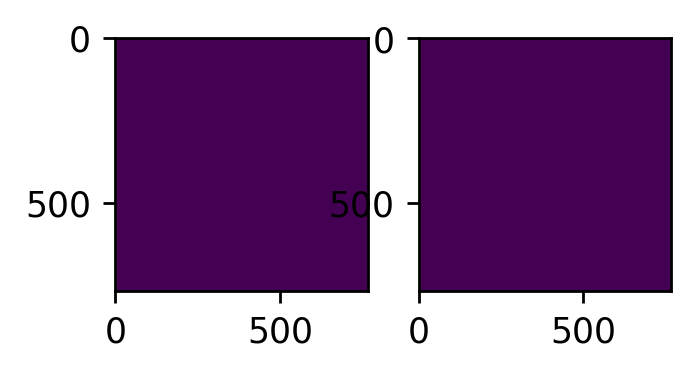

340


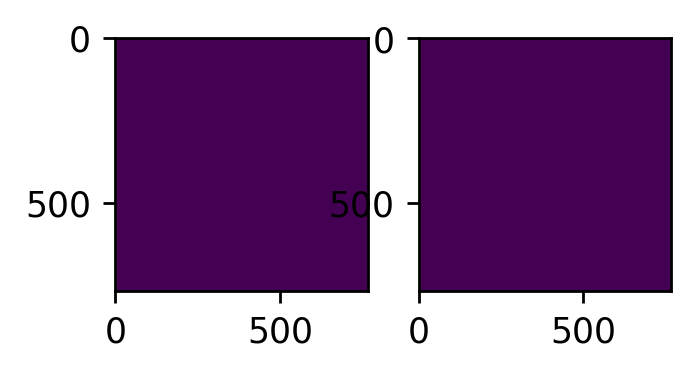

341


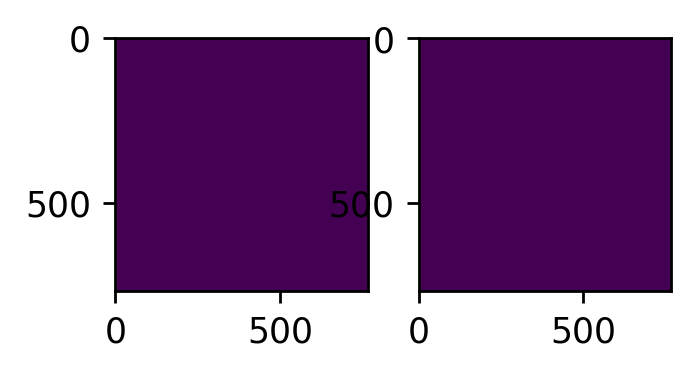

342


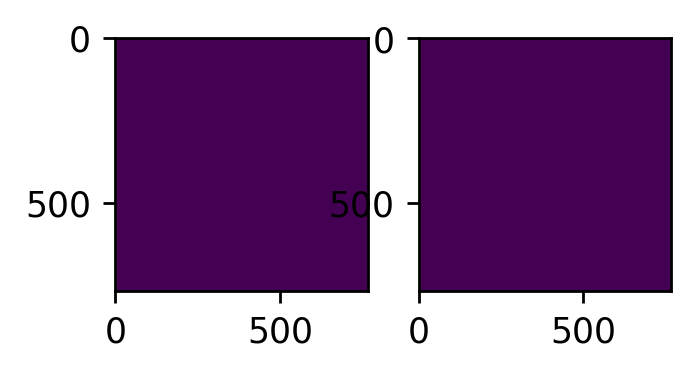

343


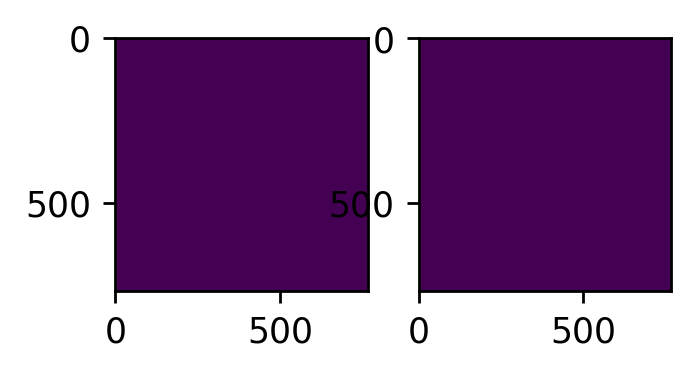

344


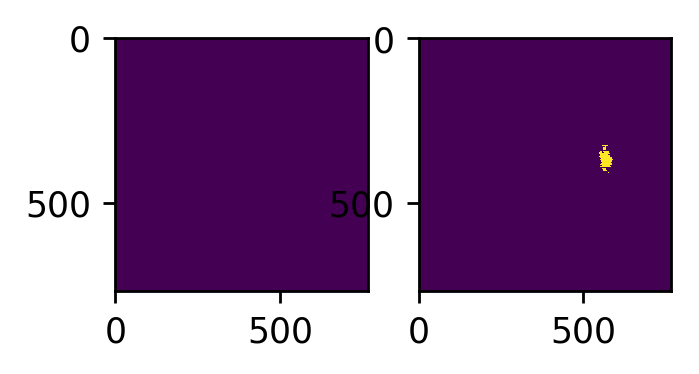

345


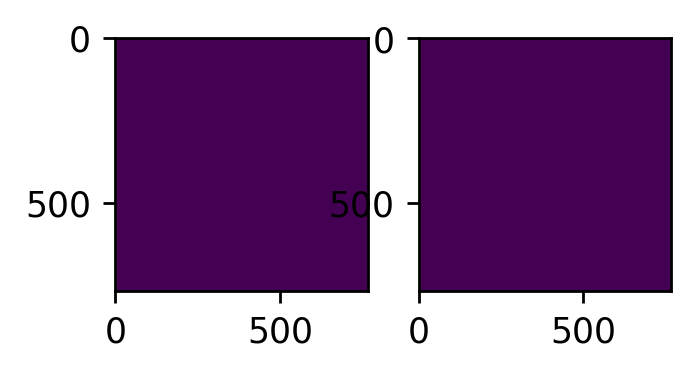

346


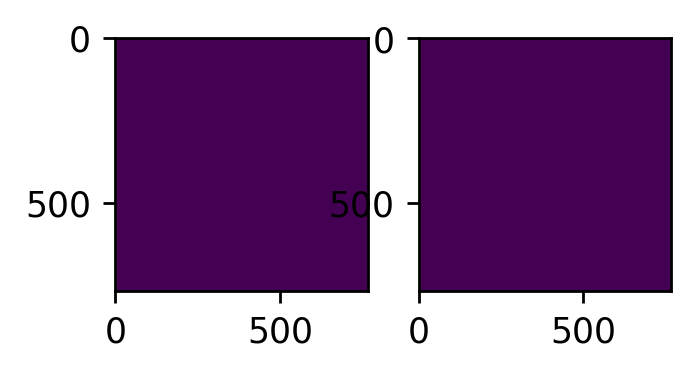

347


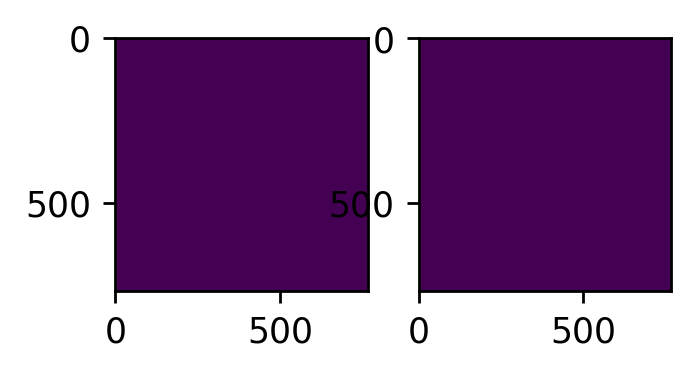

348


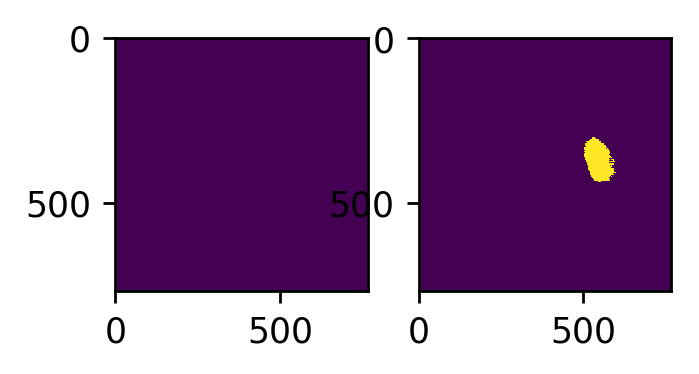

349


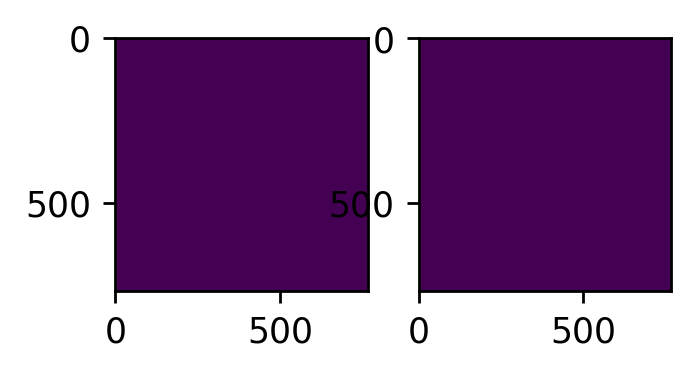

350


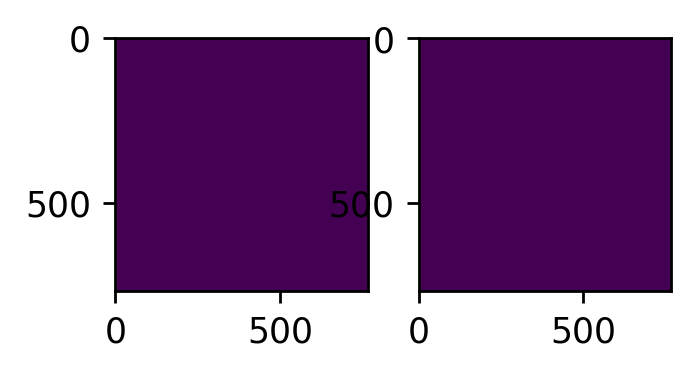

351


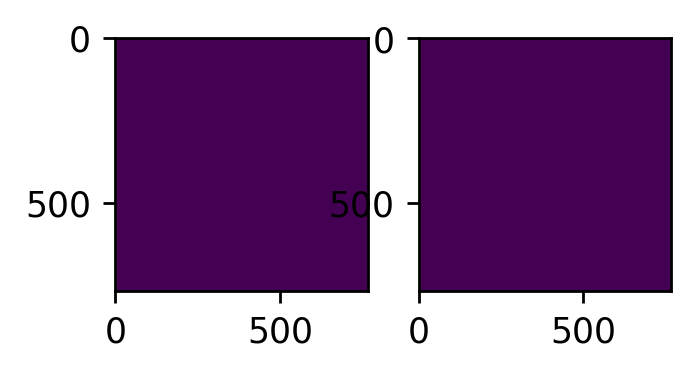

352


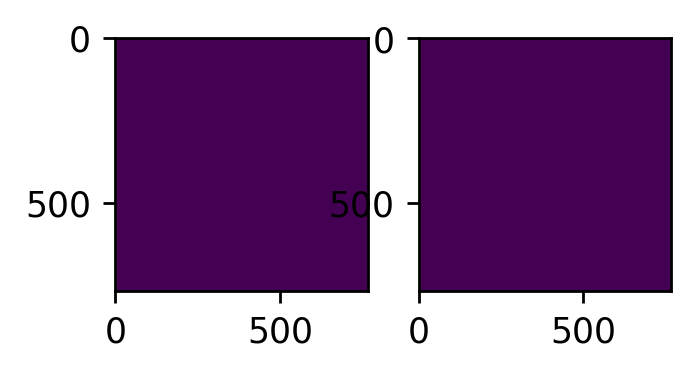

353


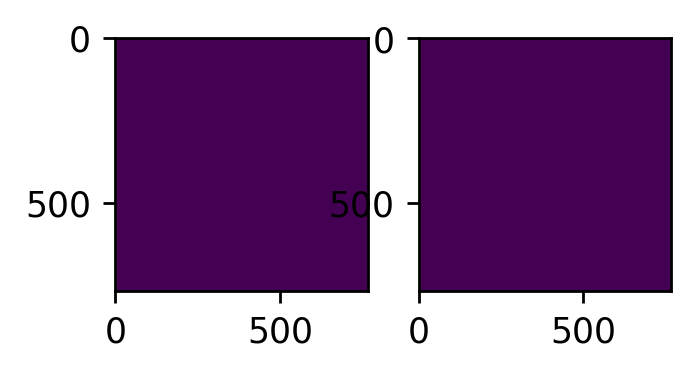

354


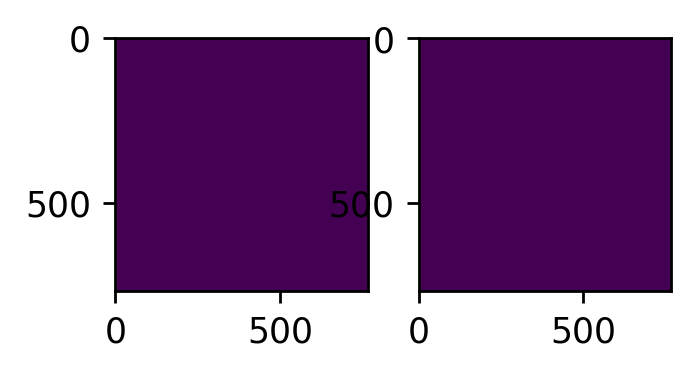

355


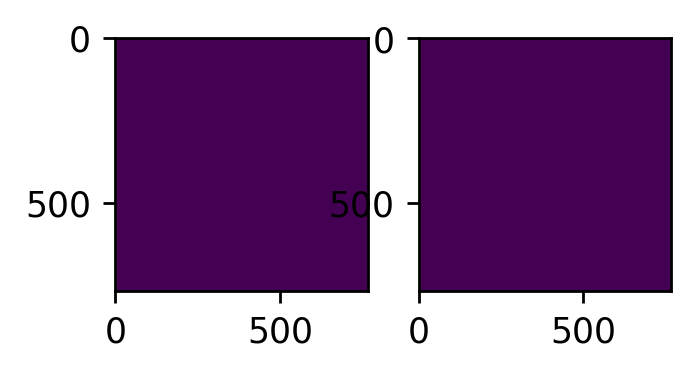

356


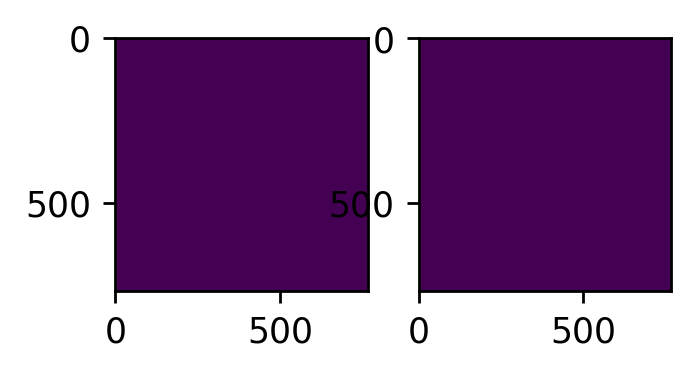

357


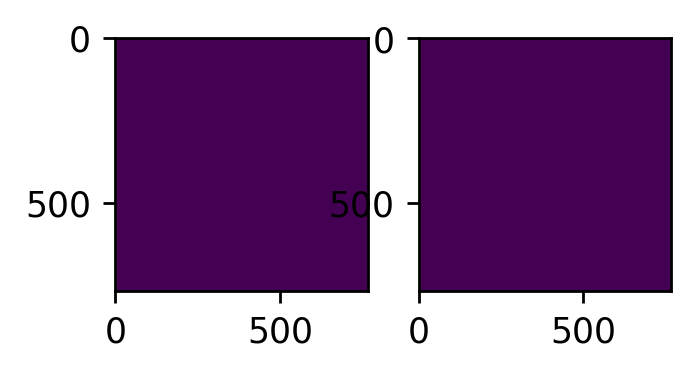

358


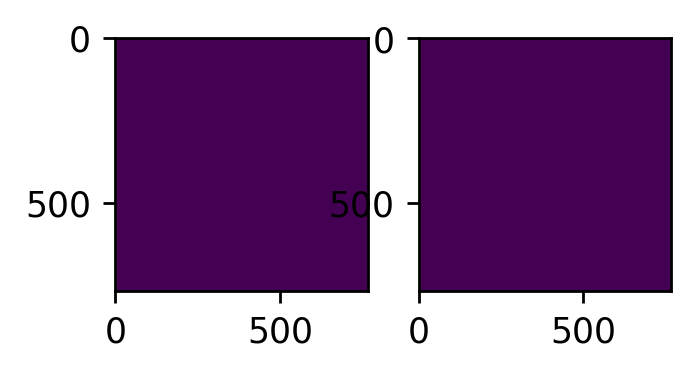

359


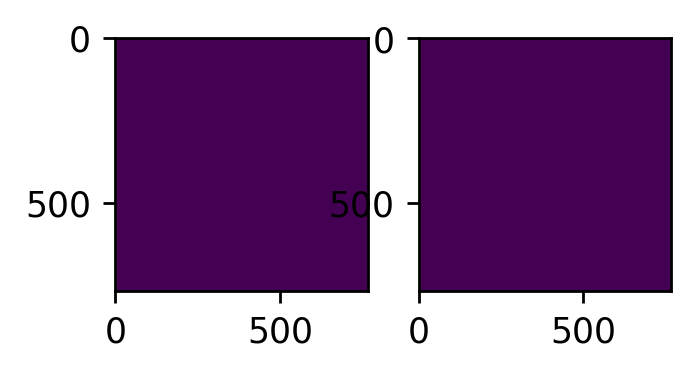

360


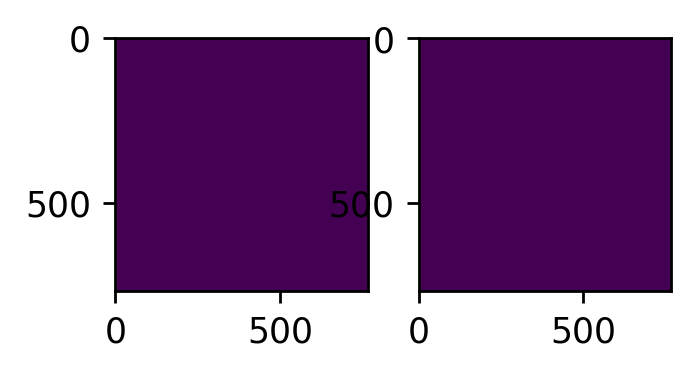

361


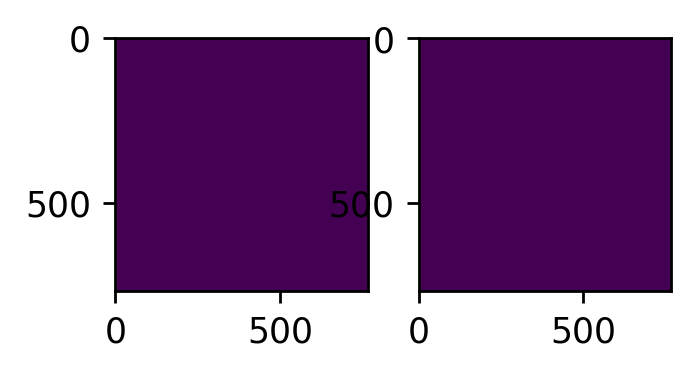

362


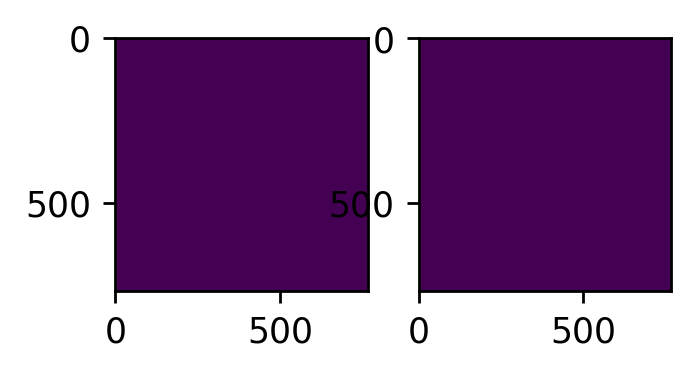

363


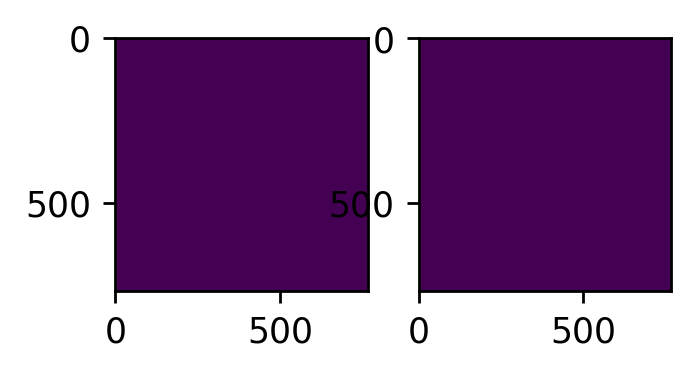

364


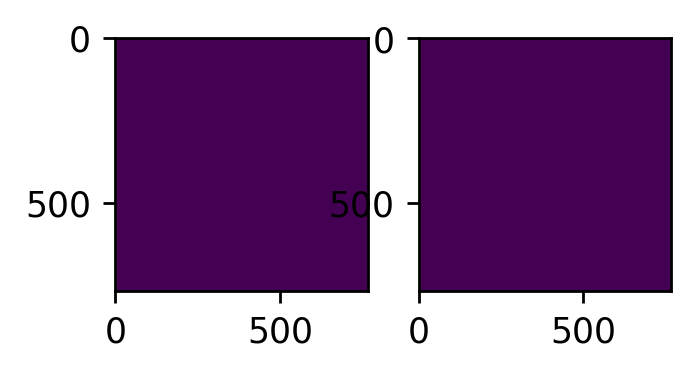

365


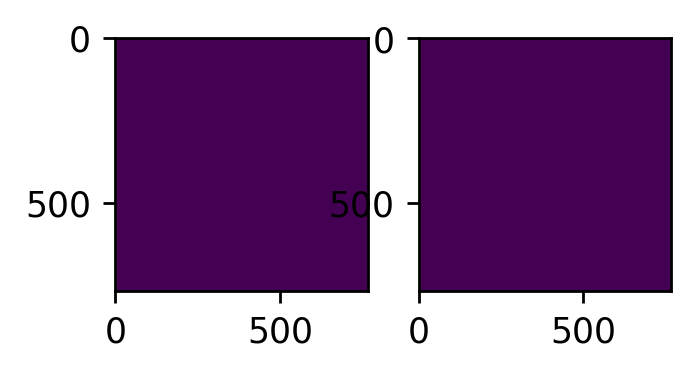

366


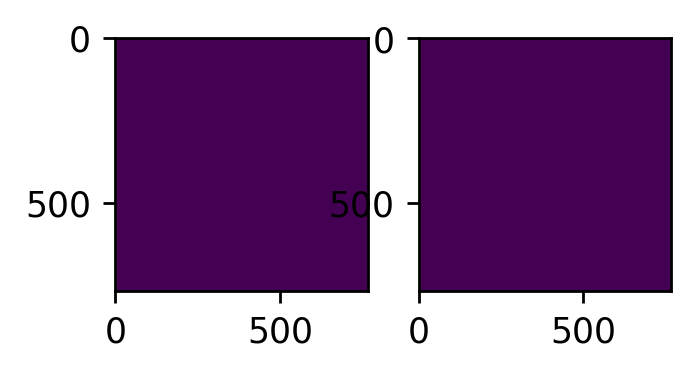

367


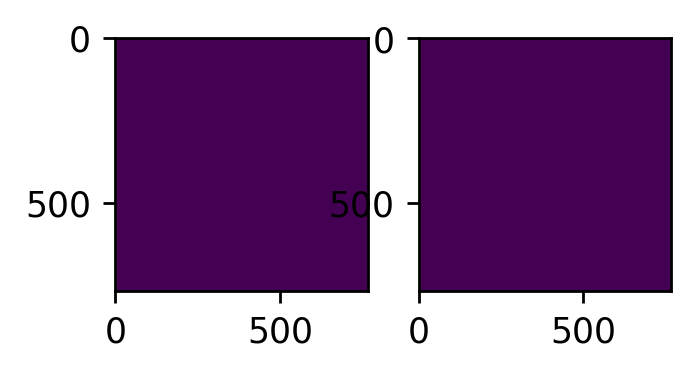

368


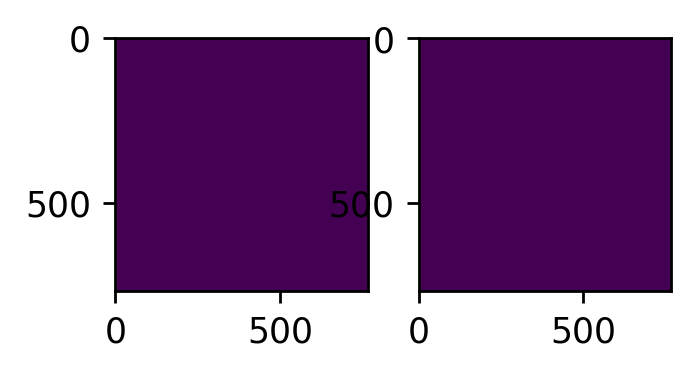

369


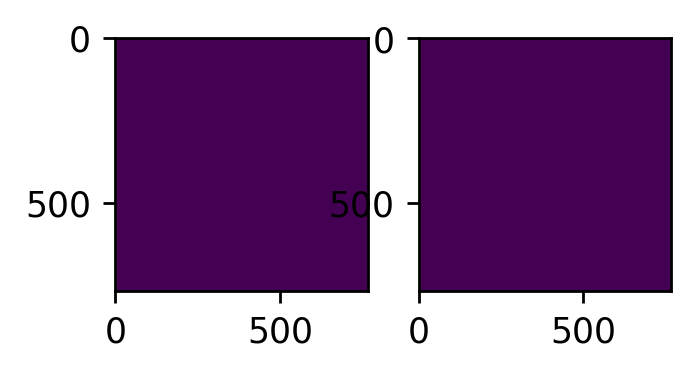

370


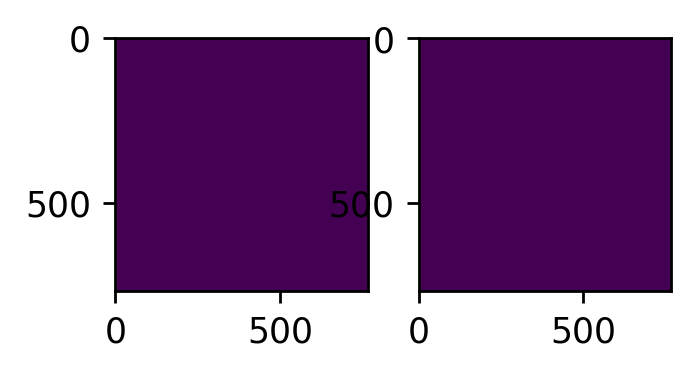

371


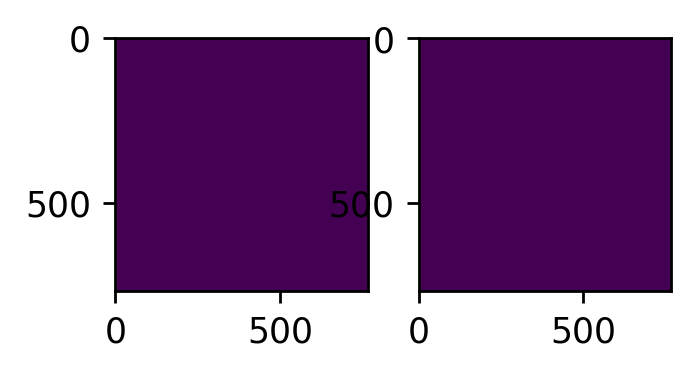

372


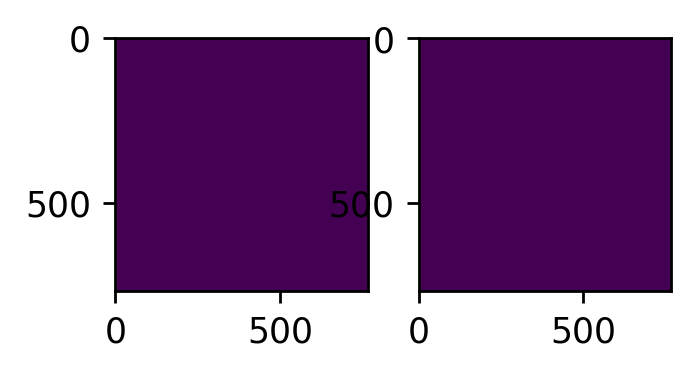

373


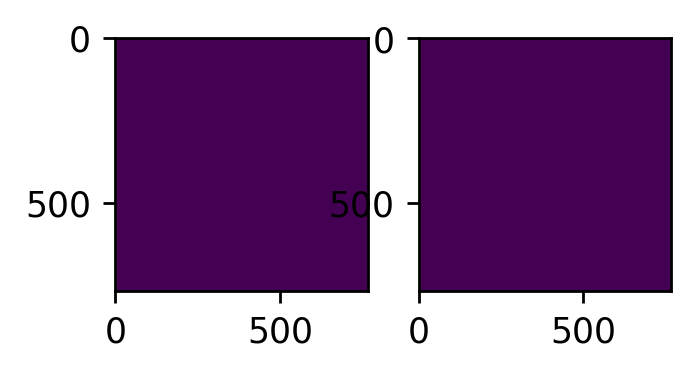

374


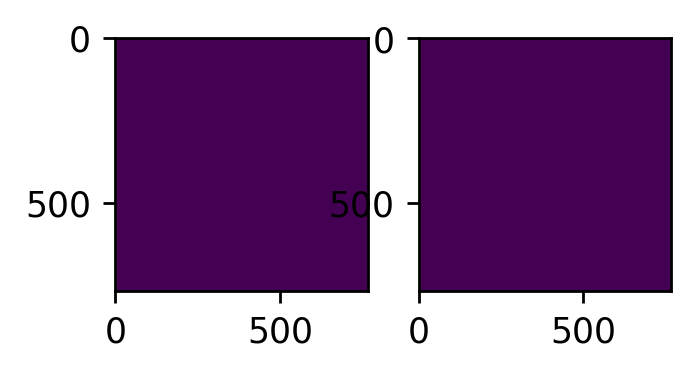

375


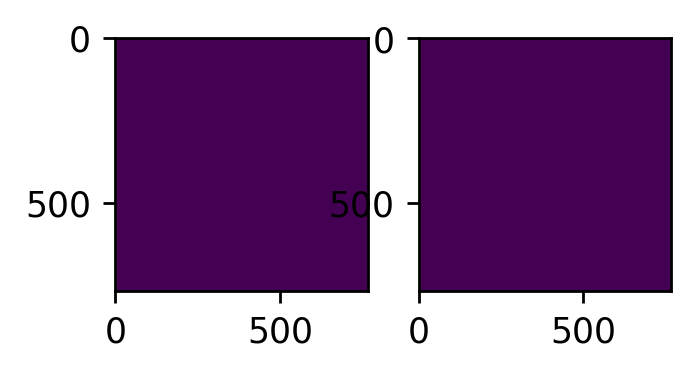

376


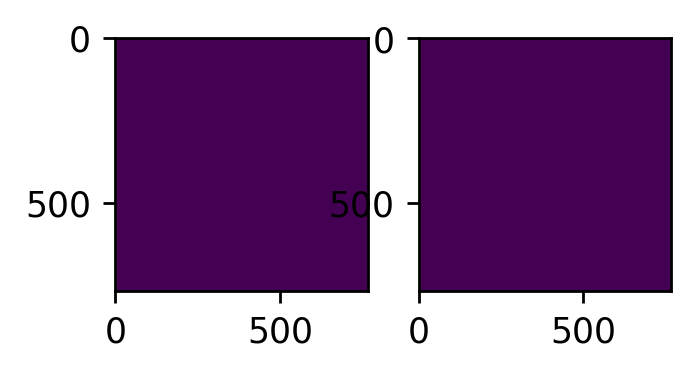

377


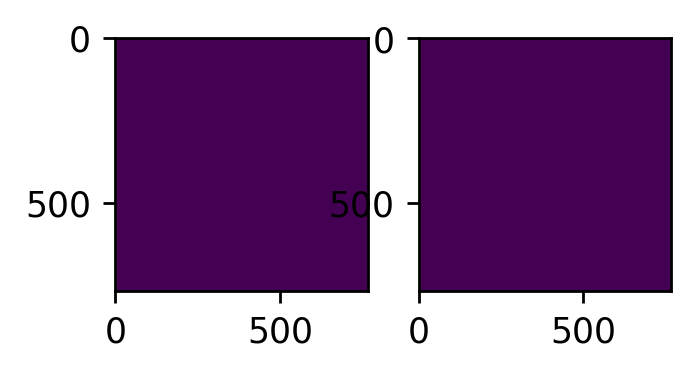

378


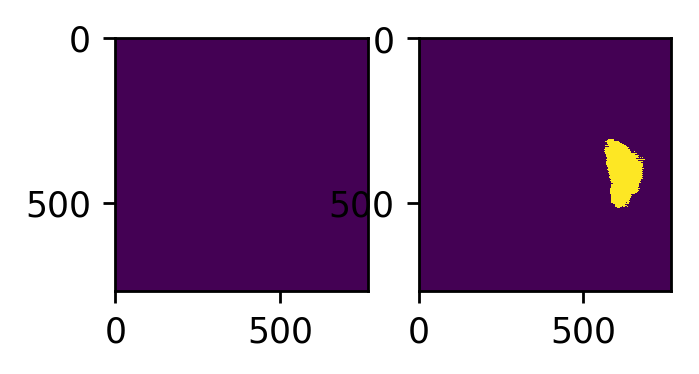

379


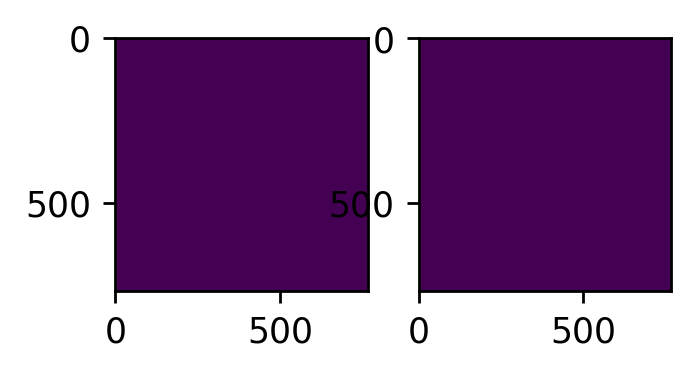

380


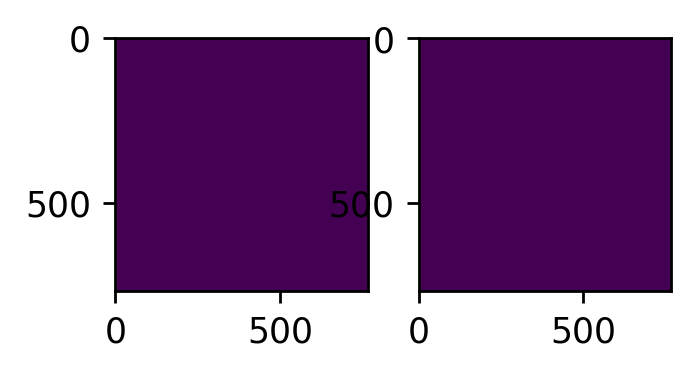

381


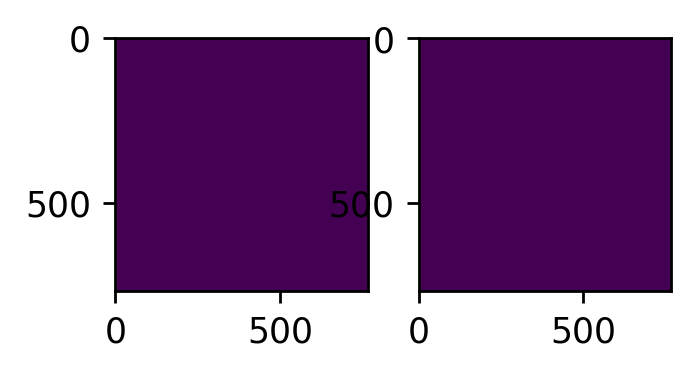

382


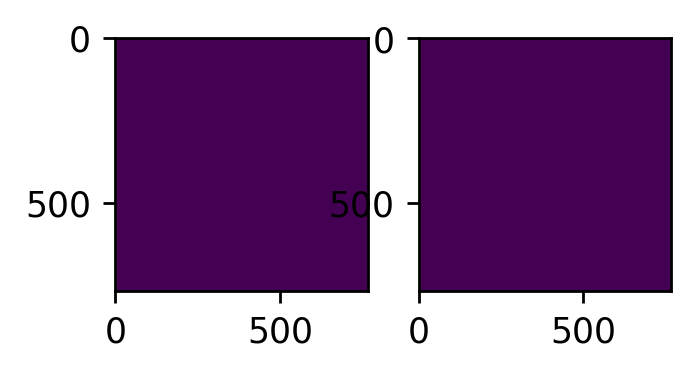

383


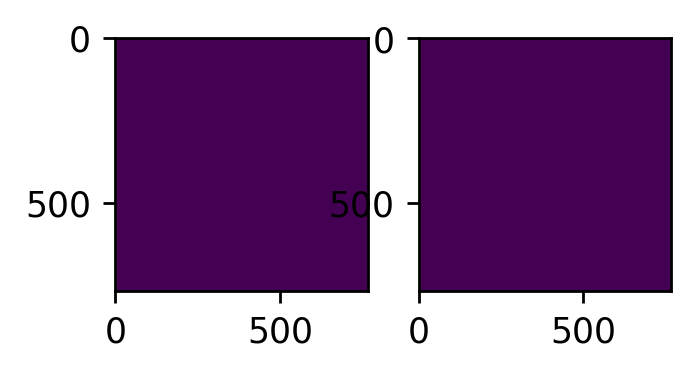

384


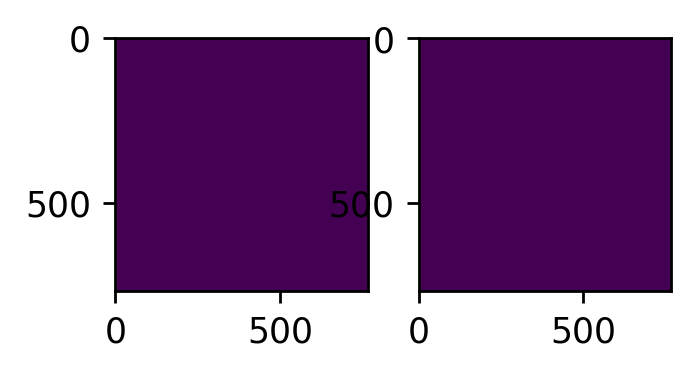

385


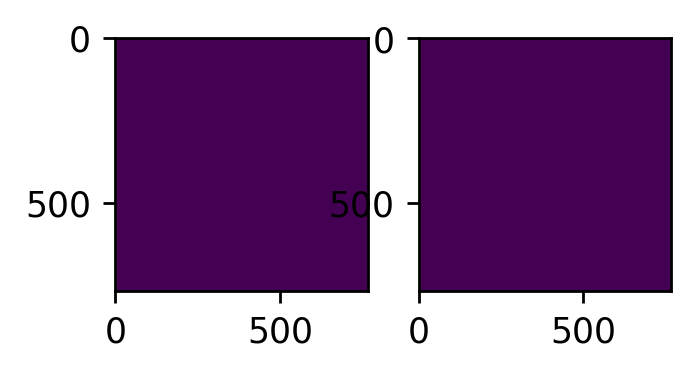

386


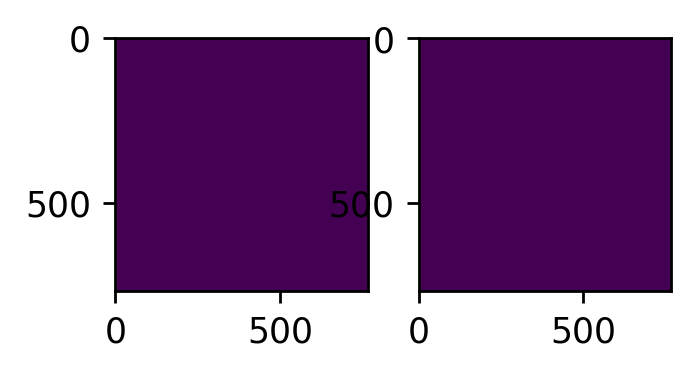

387


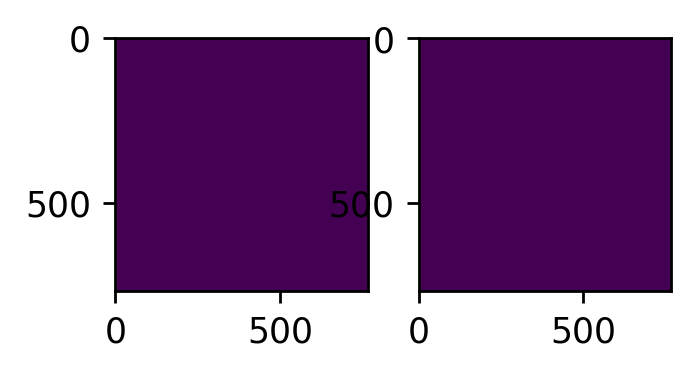

388


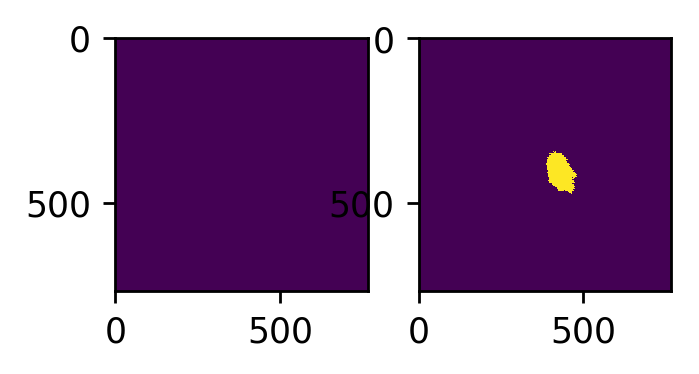

389


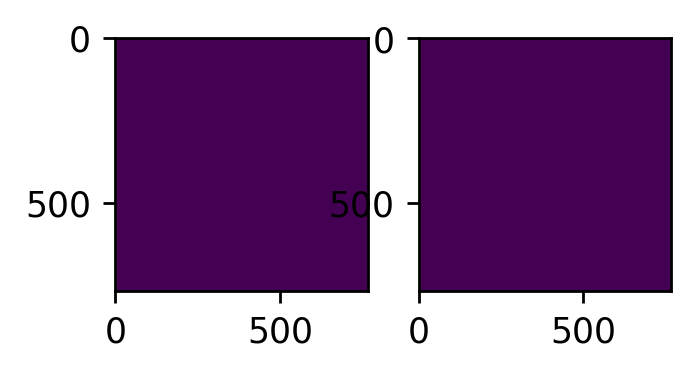

390


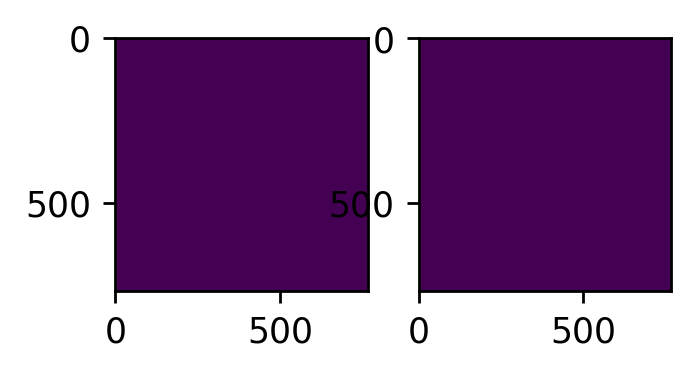

391


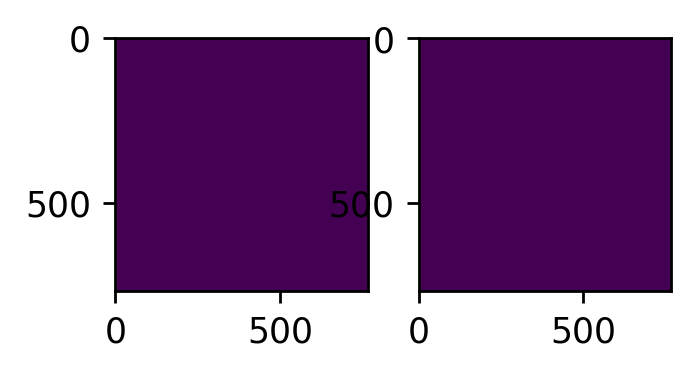

392


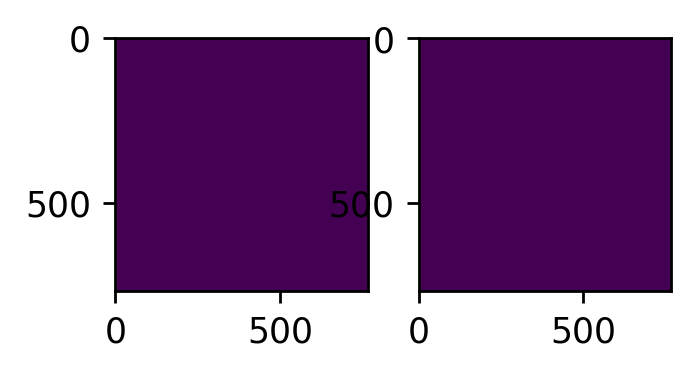

393


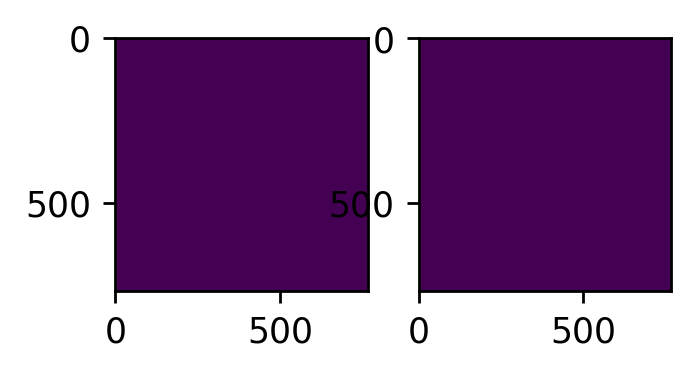

394


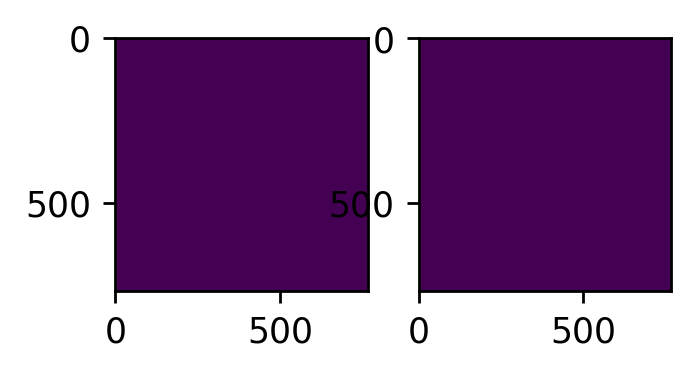

395


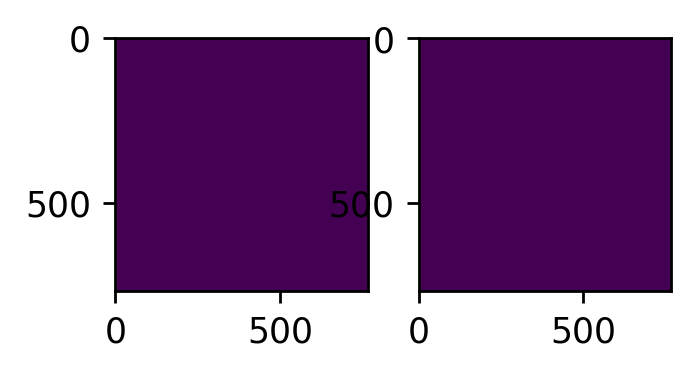

396


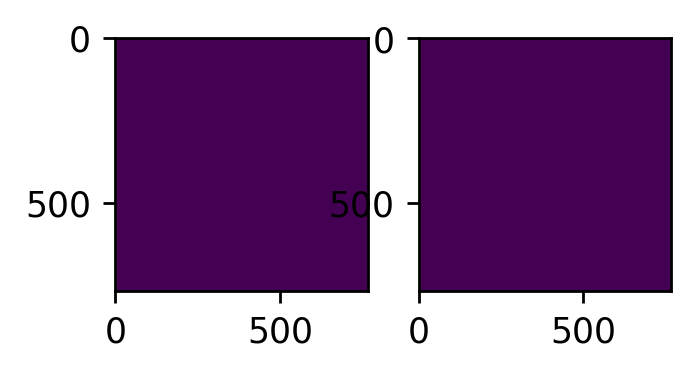

397


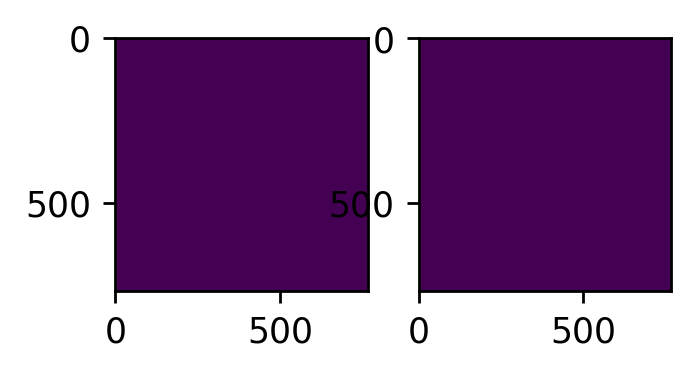

398


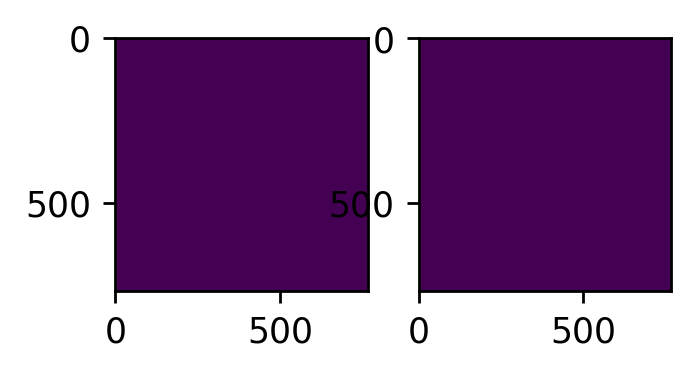

399


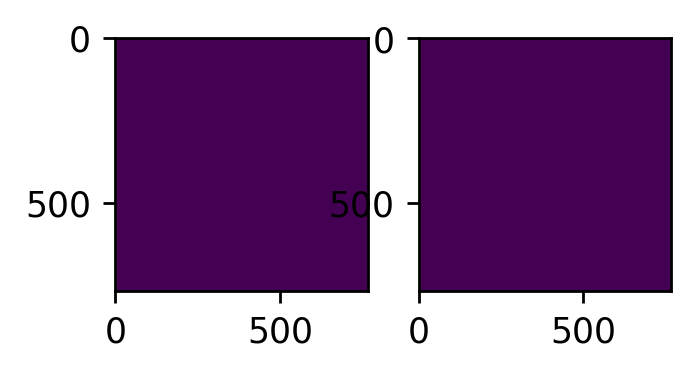

400


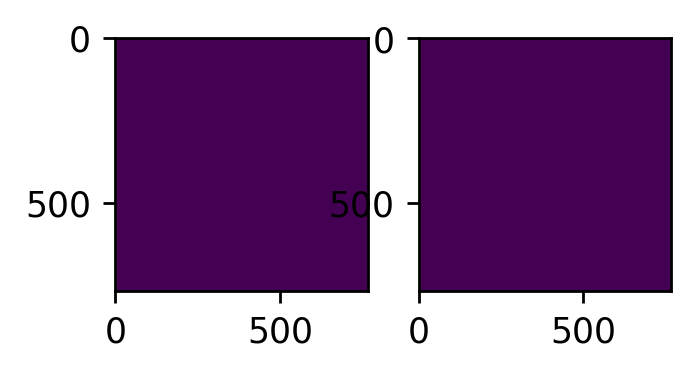

401


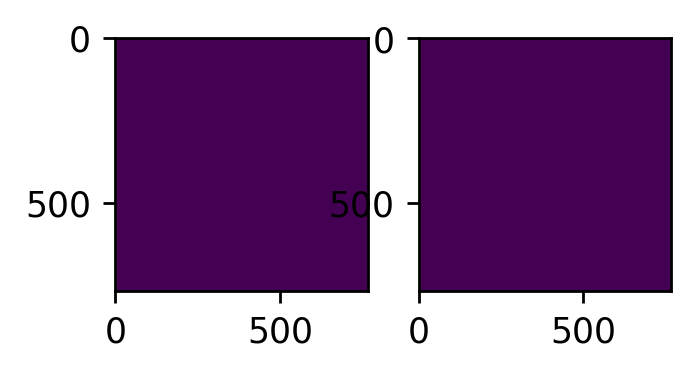

402


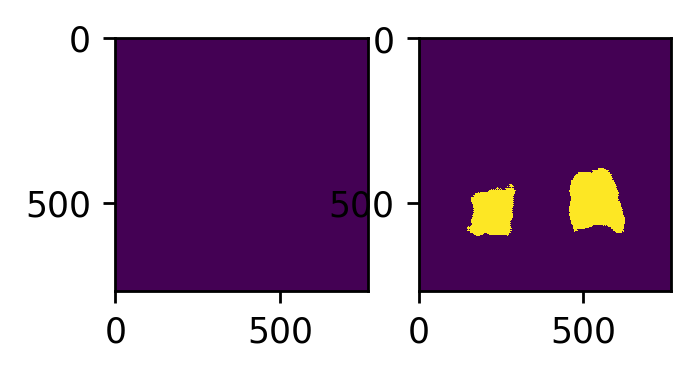

403


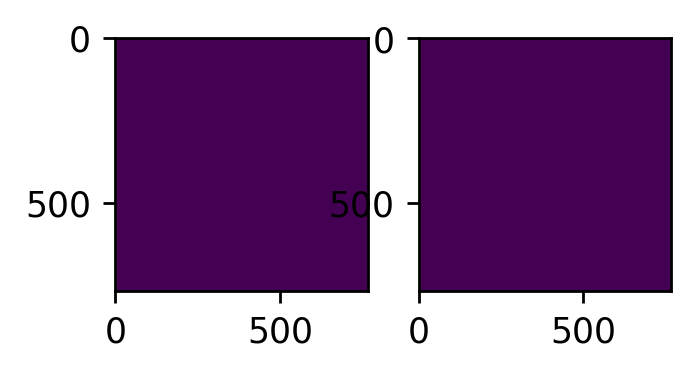

404


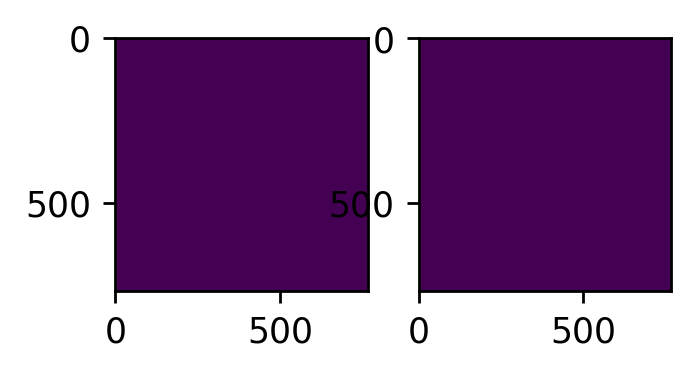

405


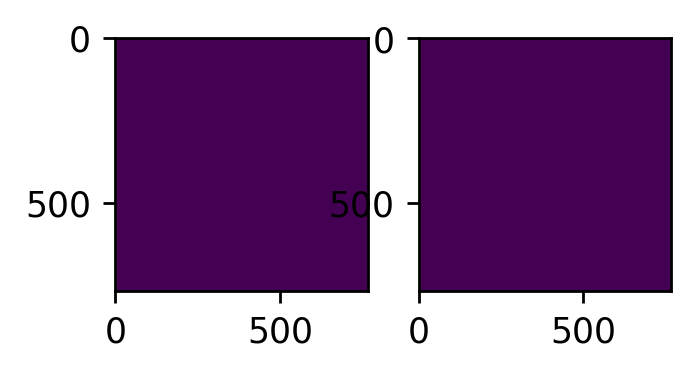

406


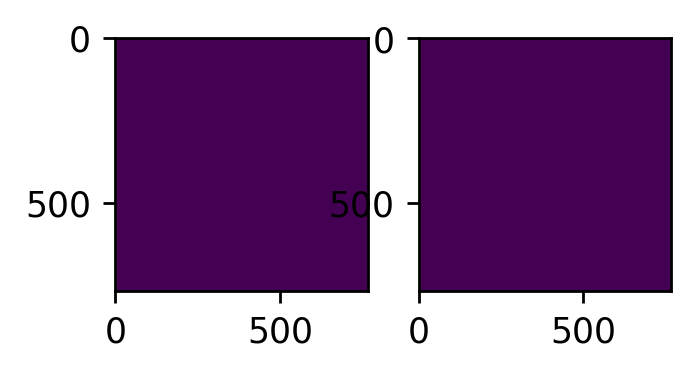

407


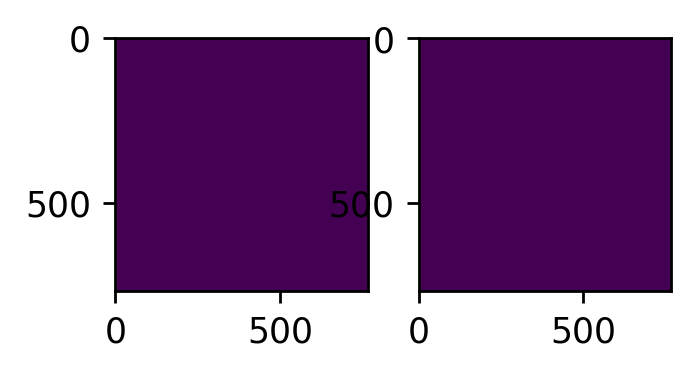

408


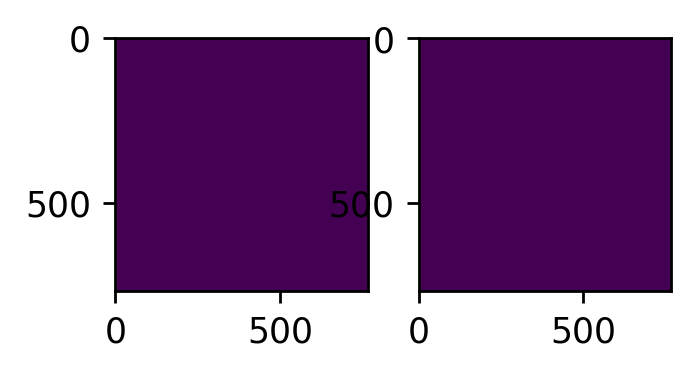

409


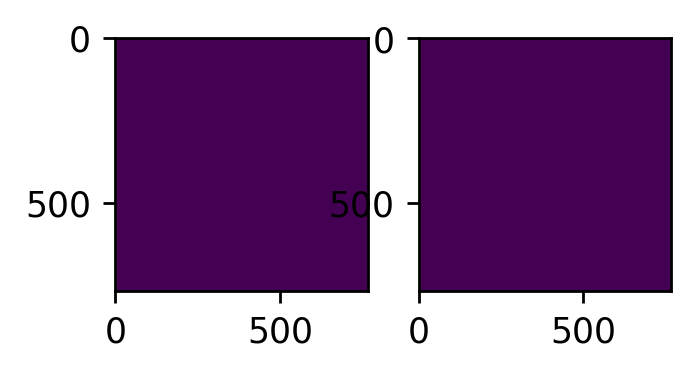

410


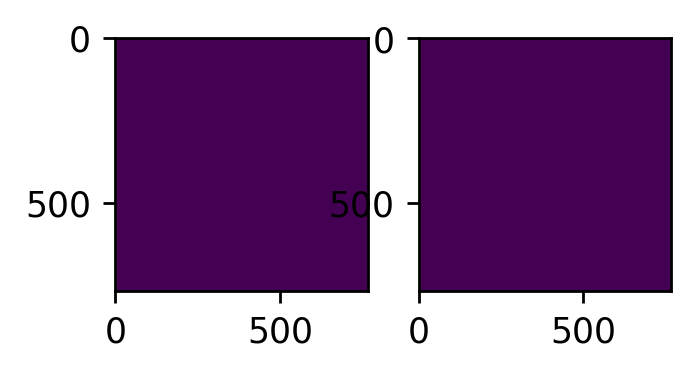

411


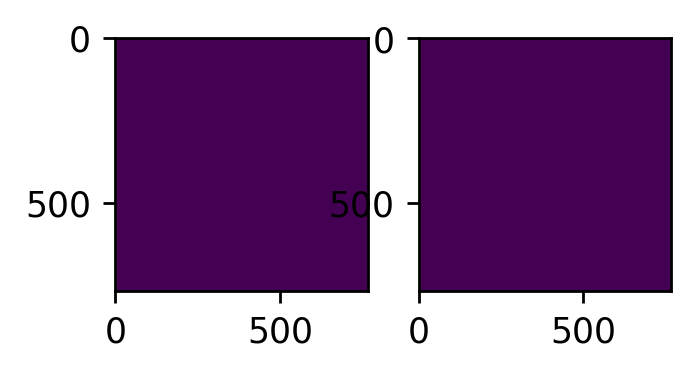

412


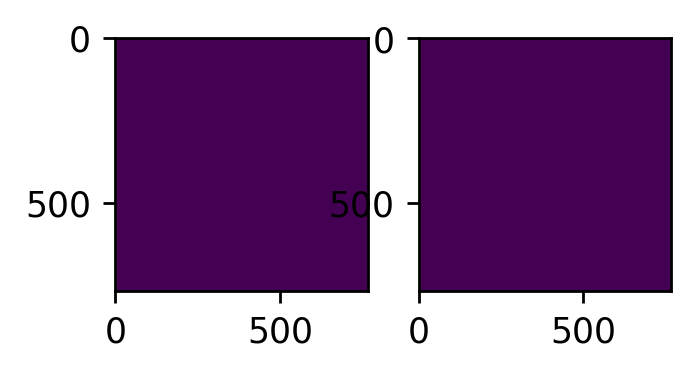

413


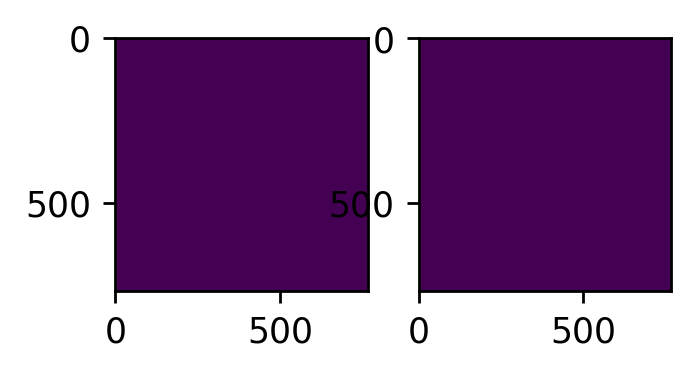

414


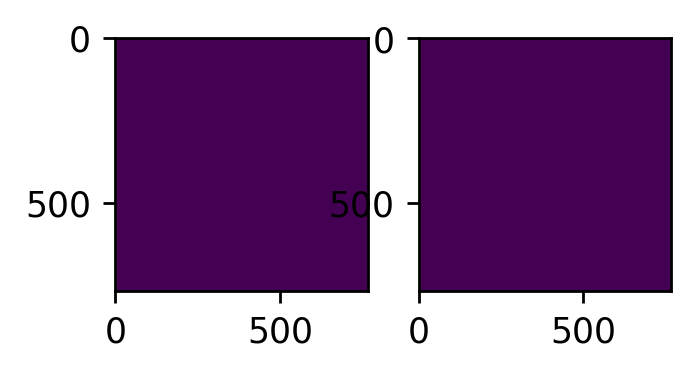

415


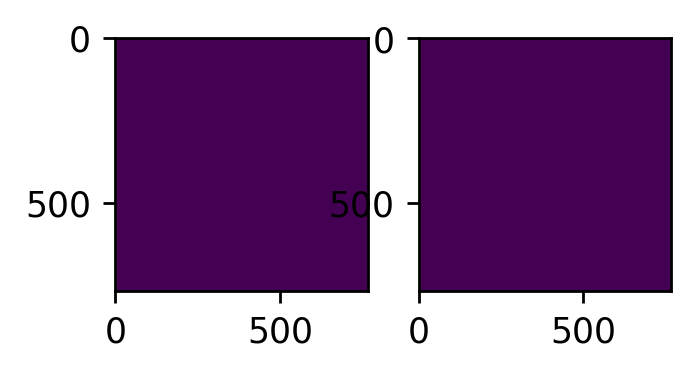

416


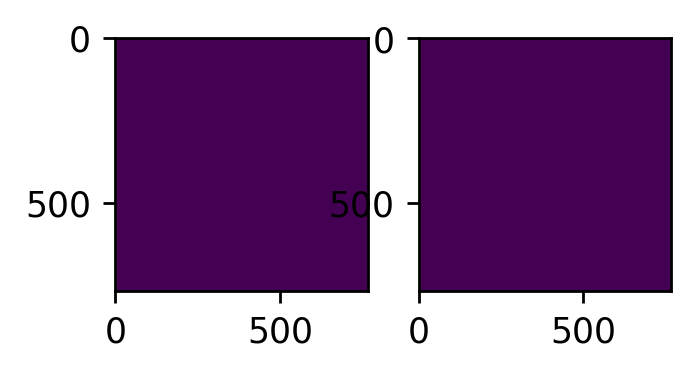

417


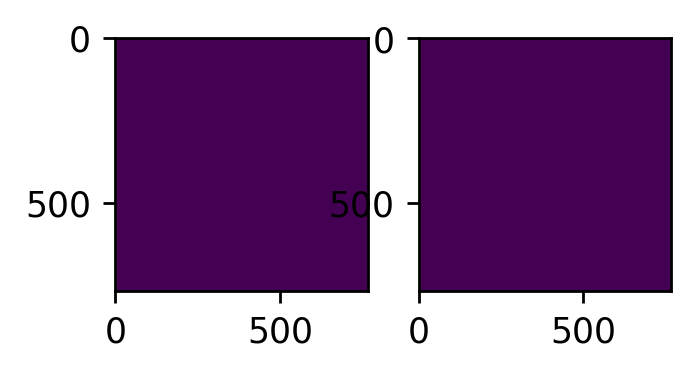

418


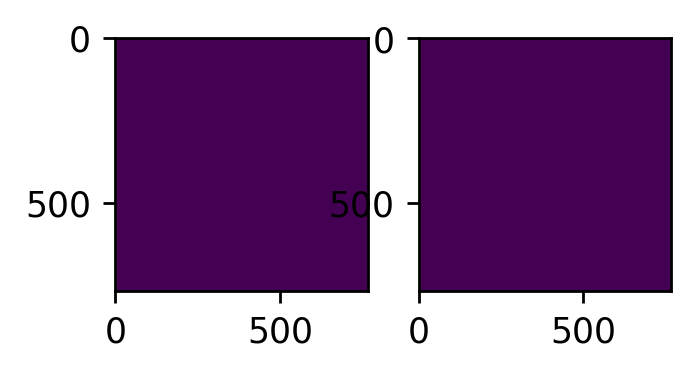

419


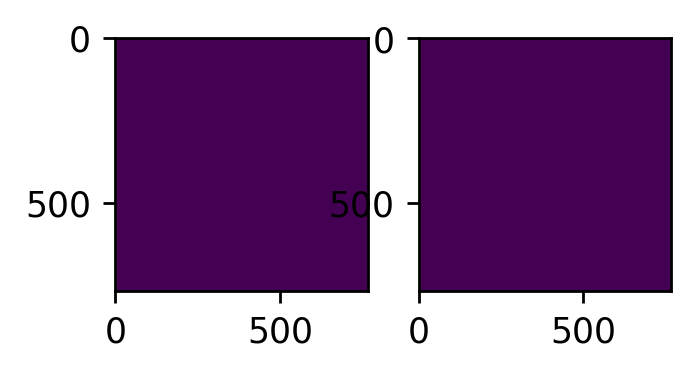

420


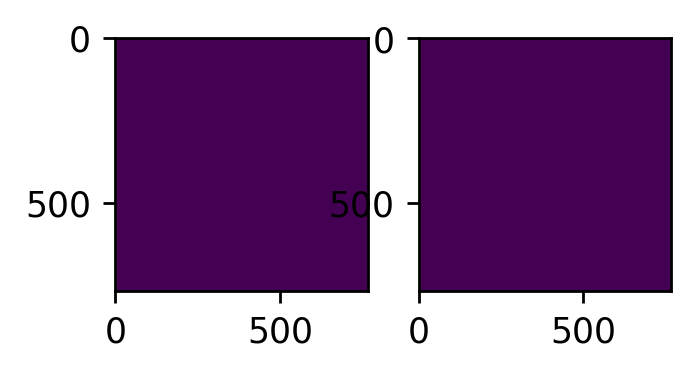

421


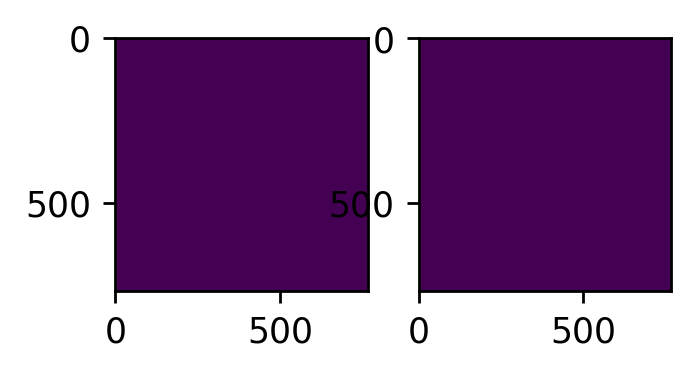

422


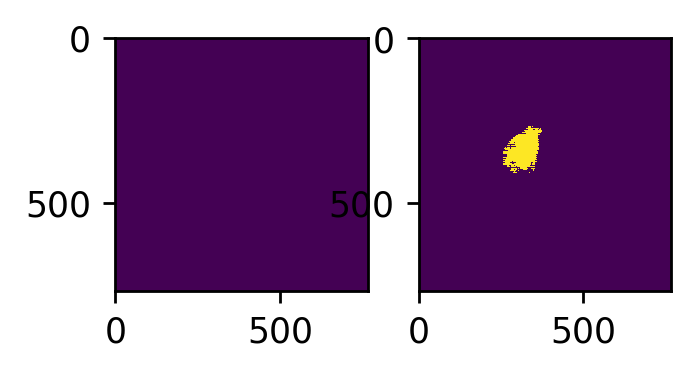

423


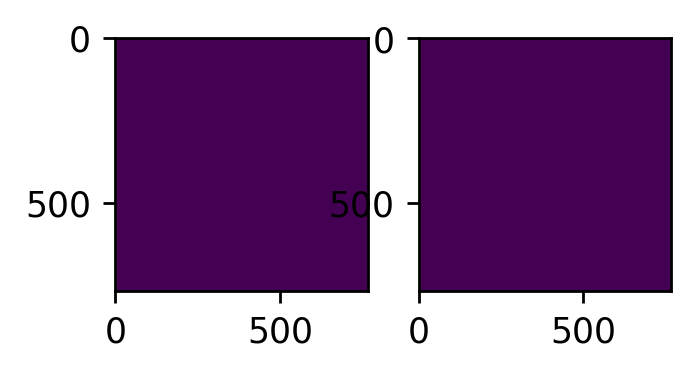

424


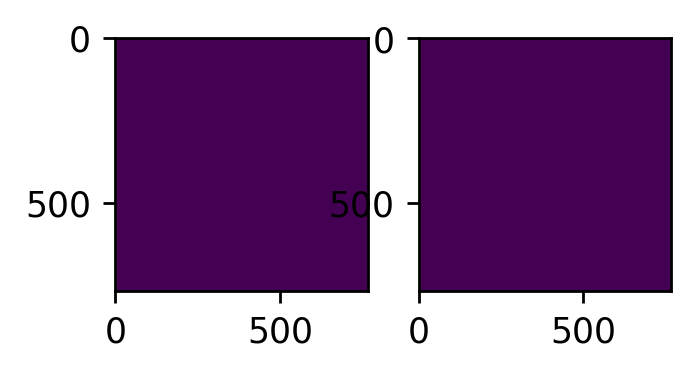

425


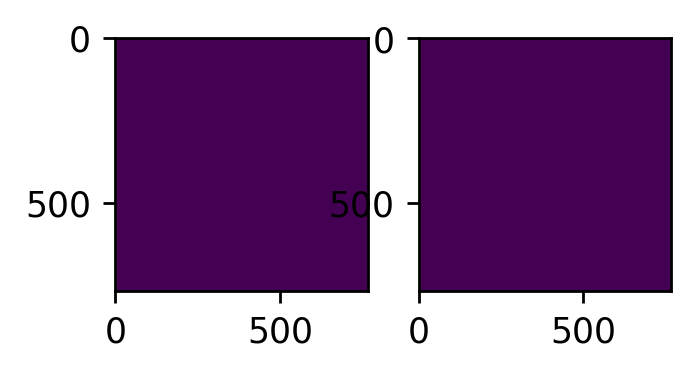

426


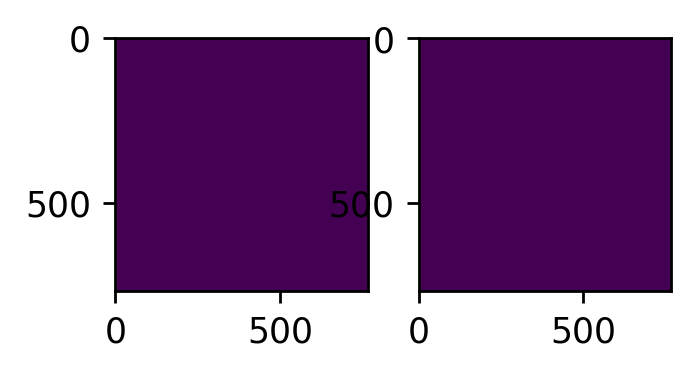

427


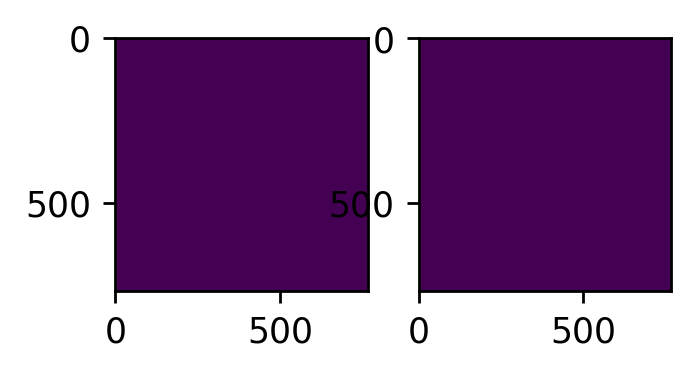

428


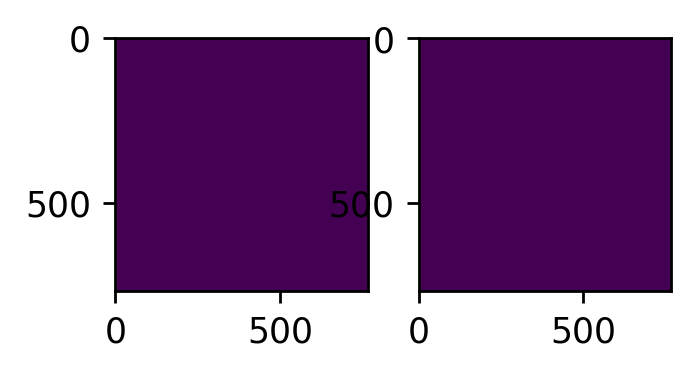

429


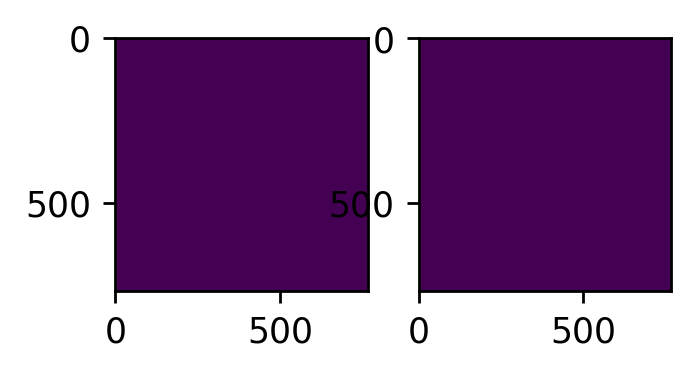

430


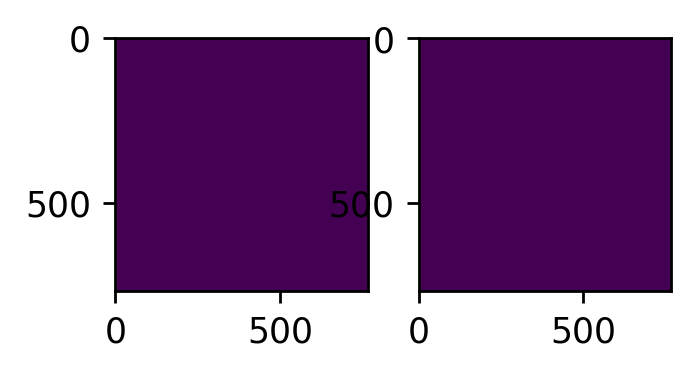

431


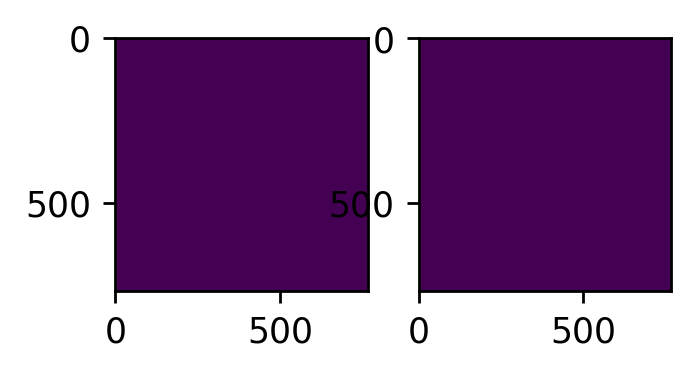

432


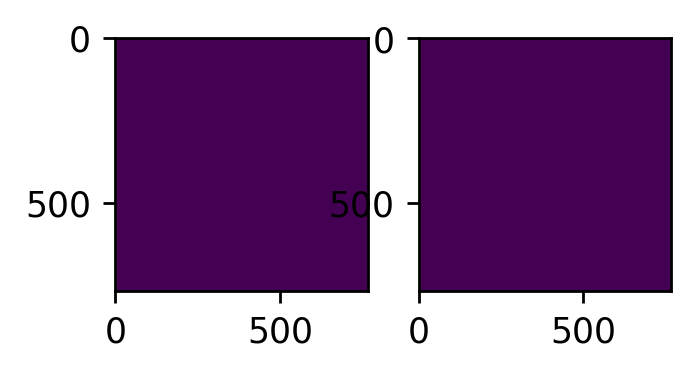

433


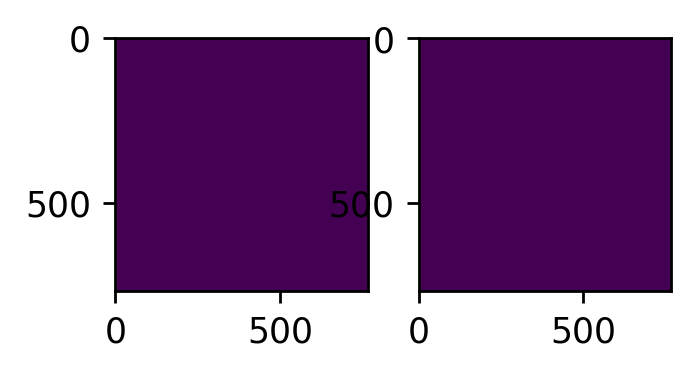

434


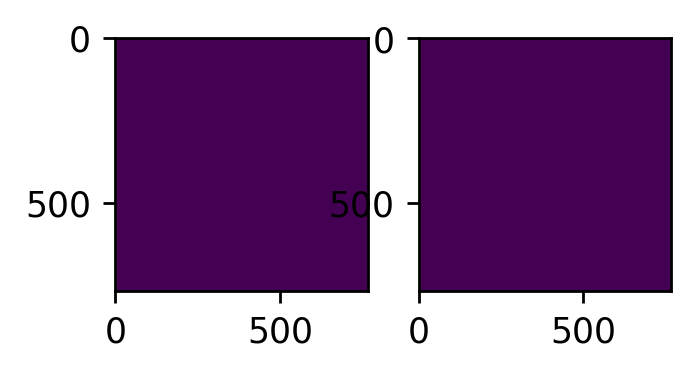

435


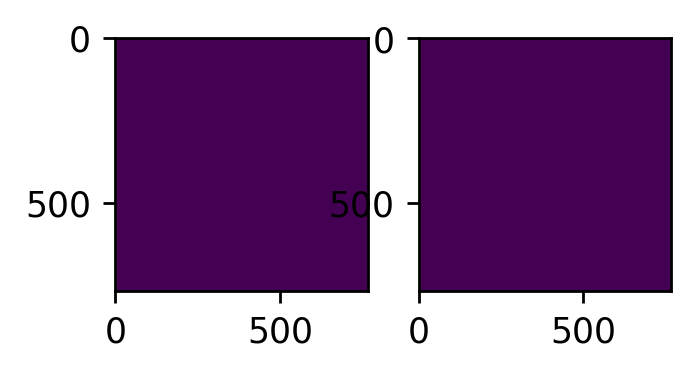

436


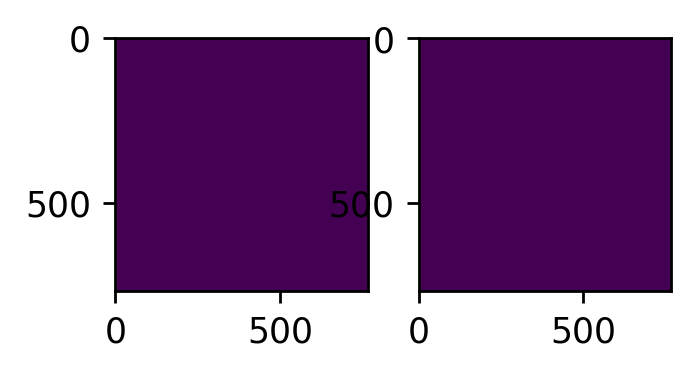

437


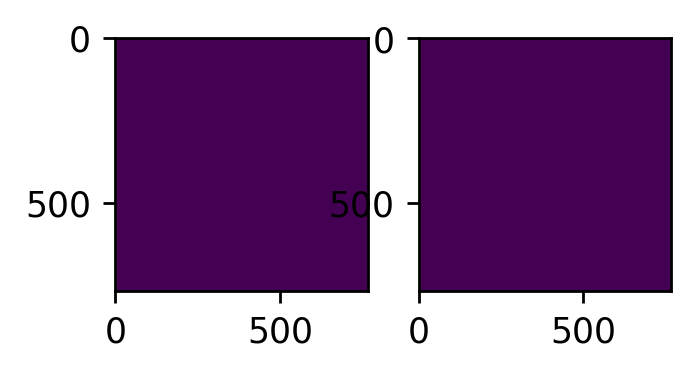

438


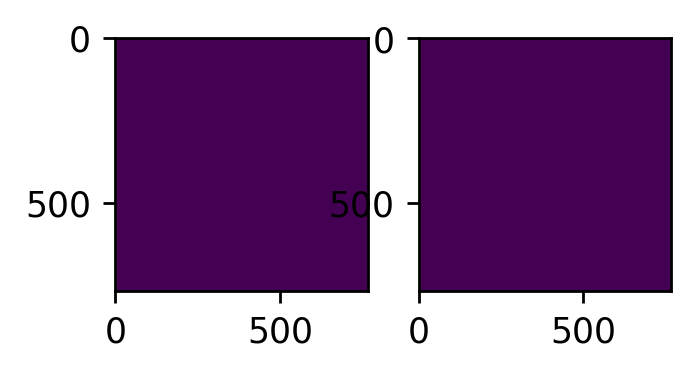

439


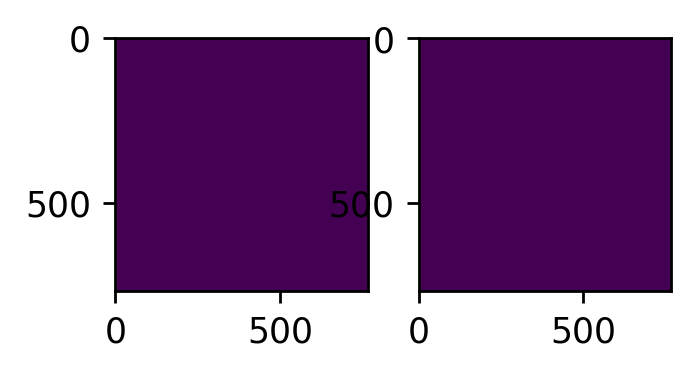

440


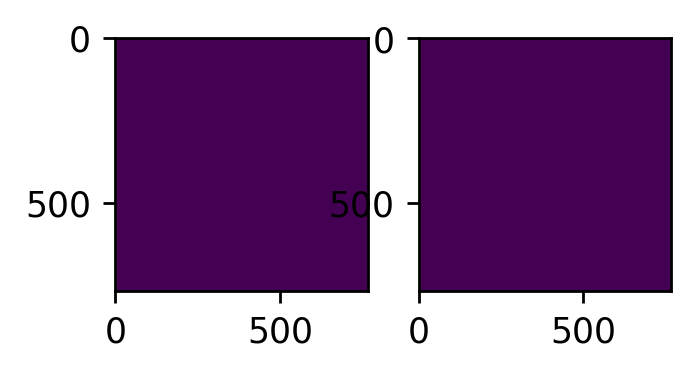

441


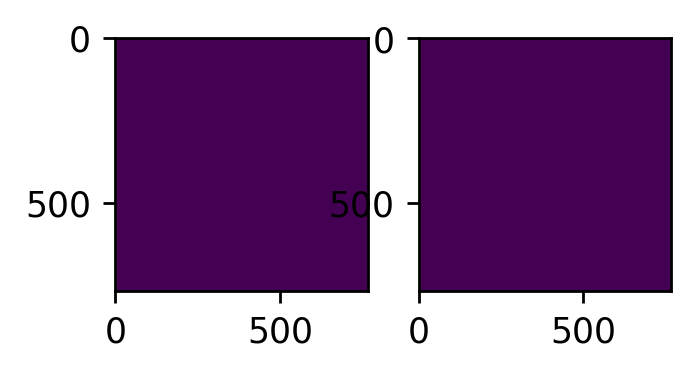

442


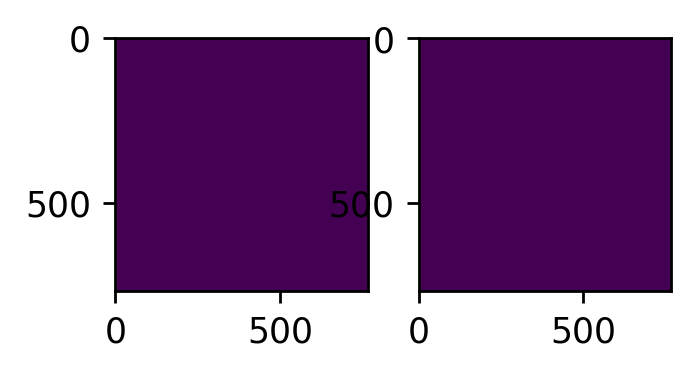

443


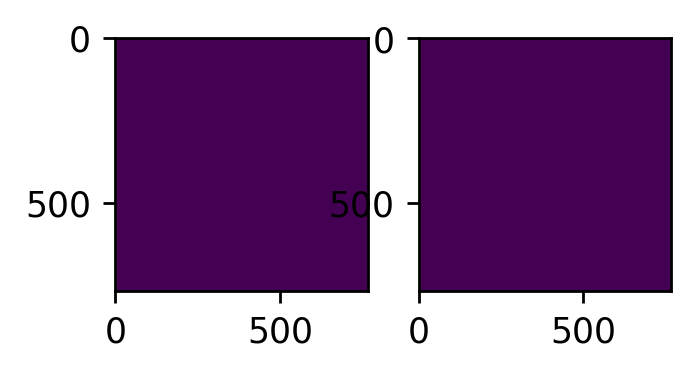

444


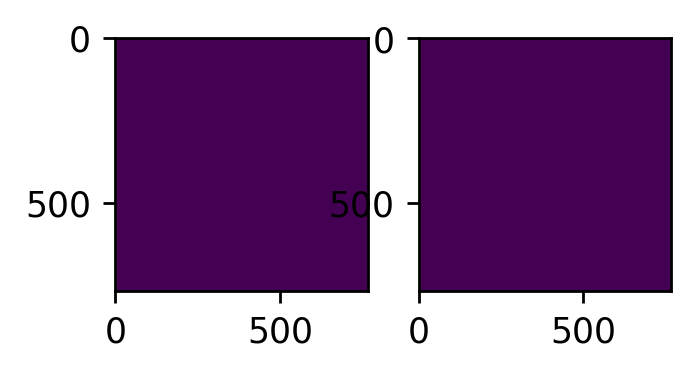

445


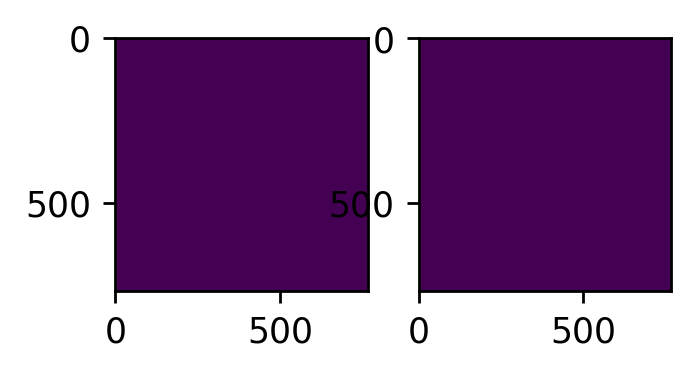

446


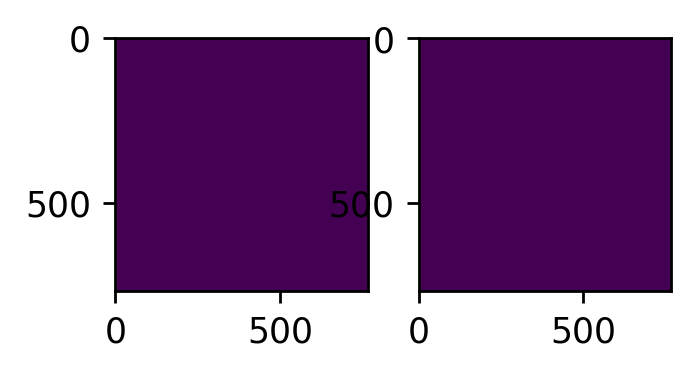

447


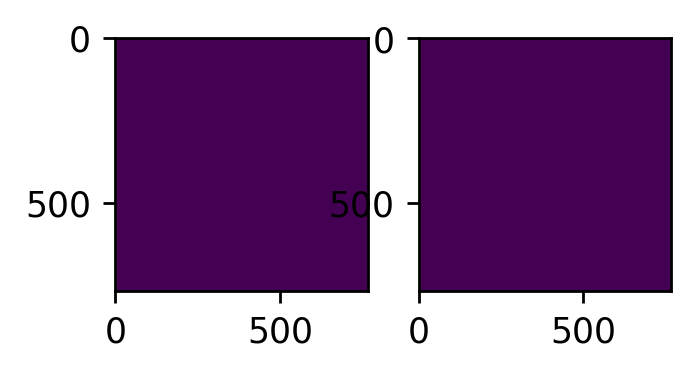

448


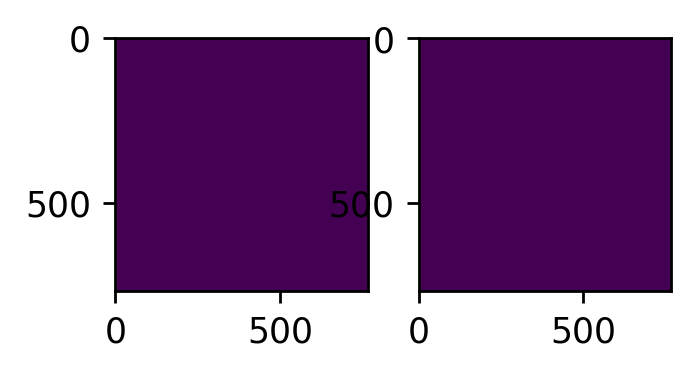

449


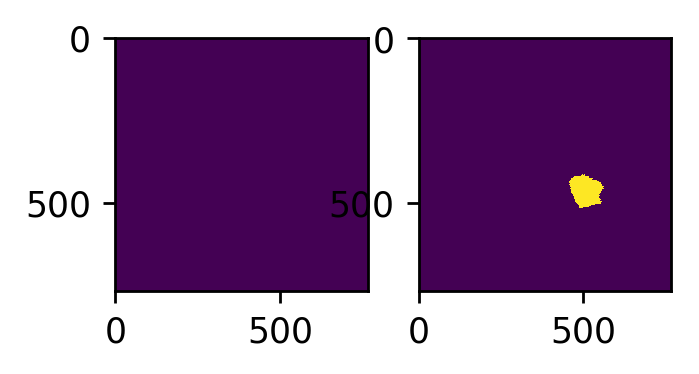

450


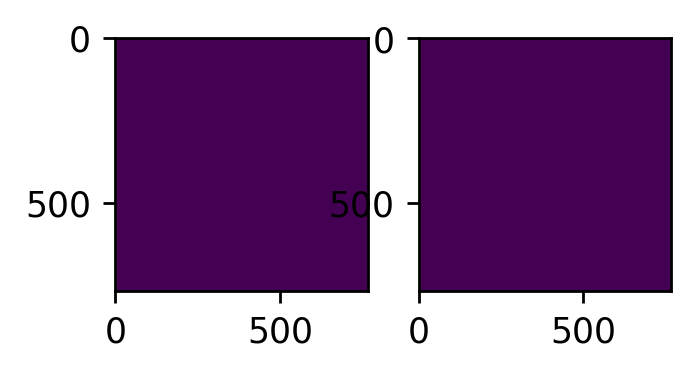

451


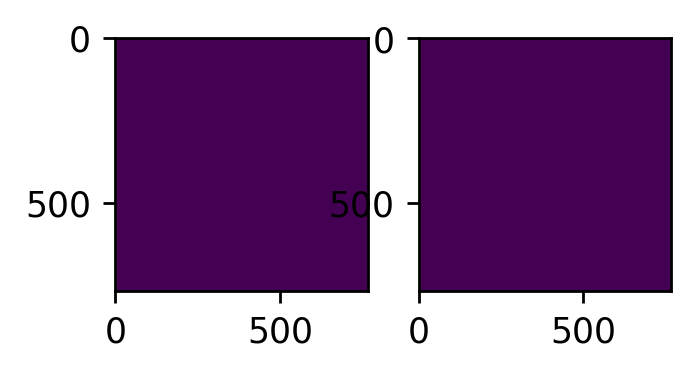

452


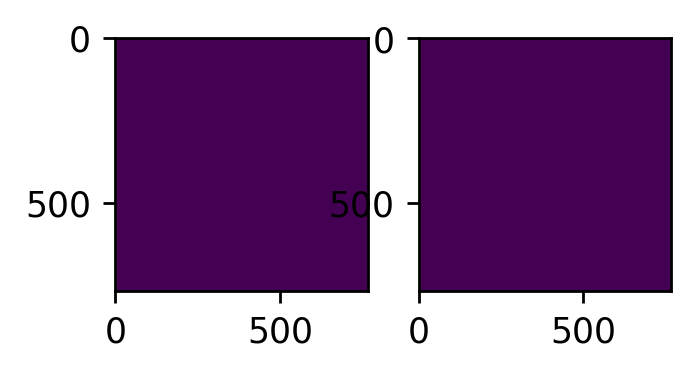

453


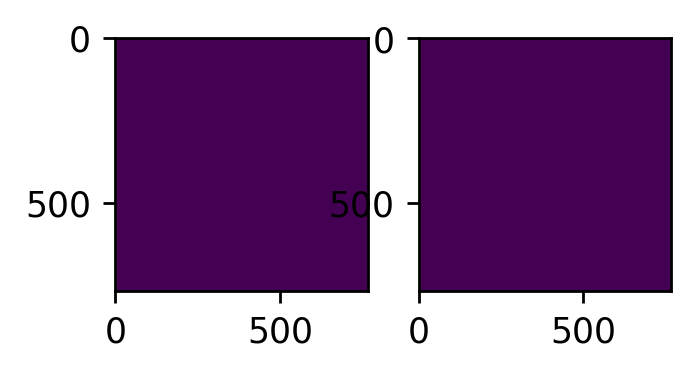

454


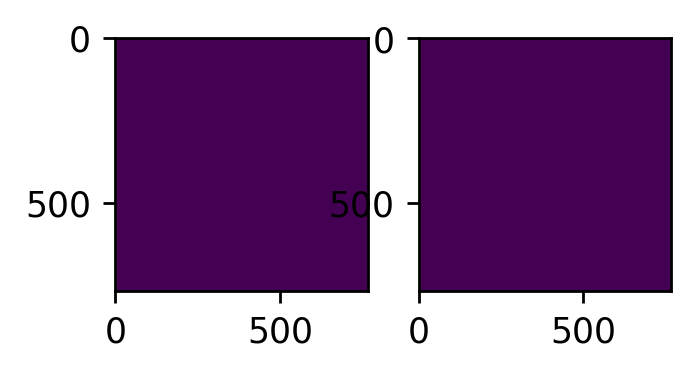

455


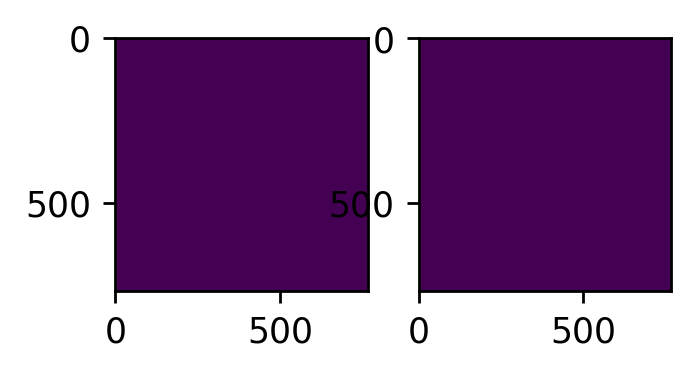

456


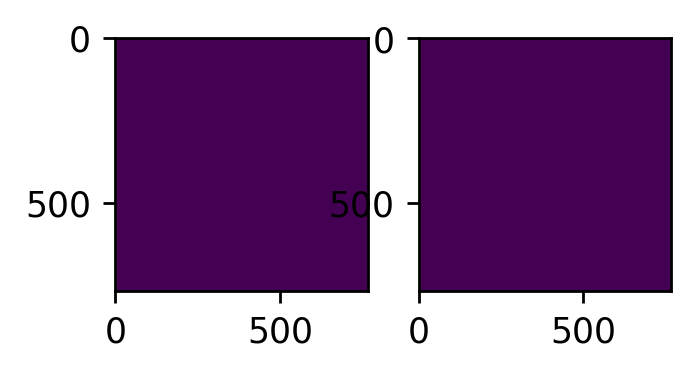

457


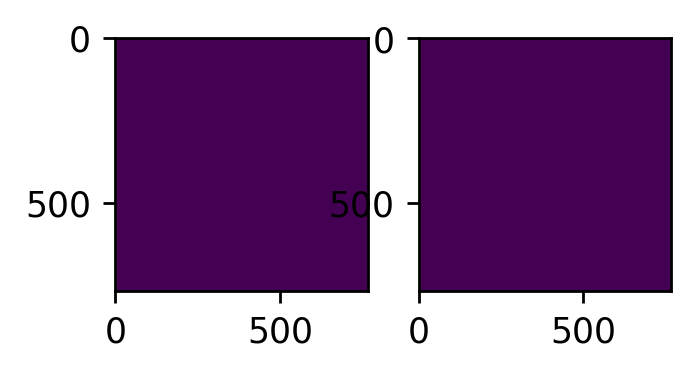

458


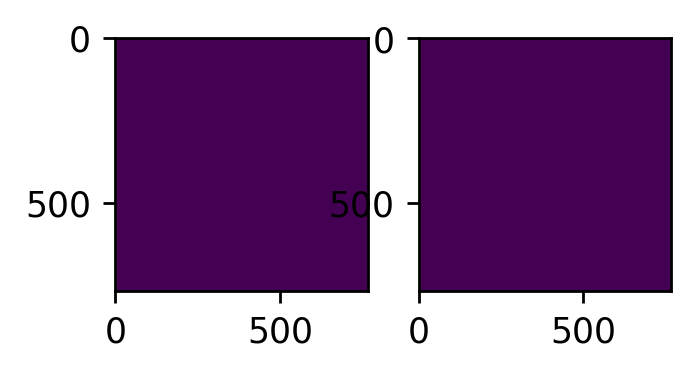

459


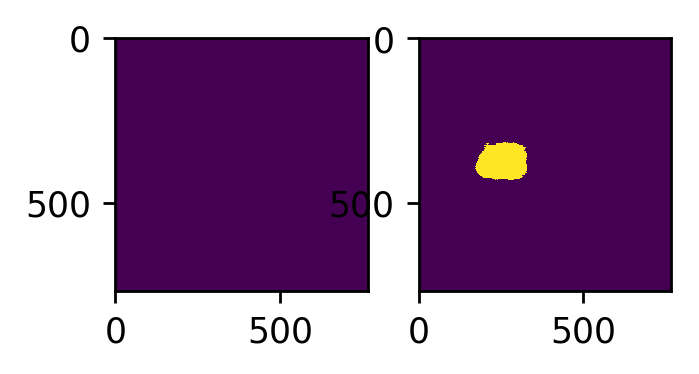

460


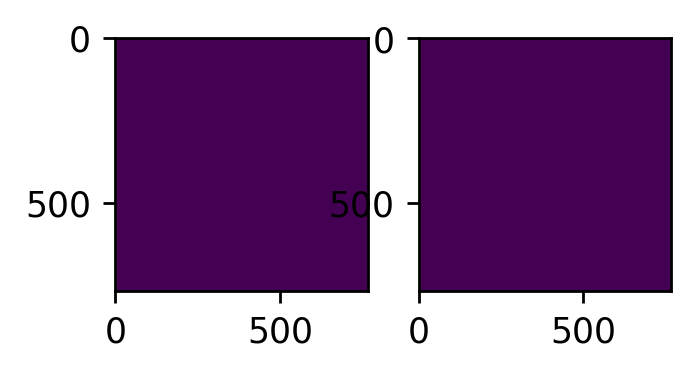

461


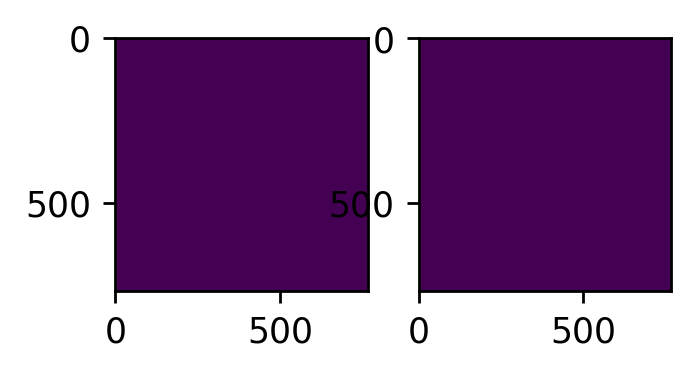

462


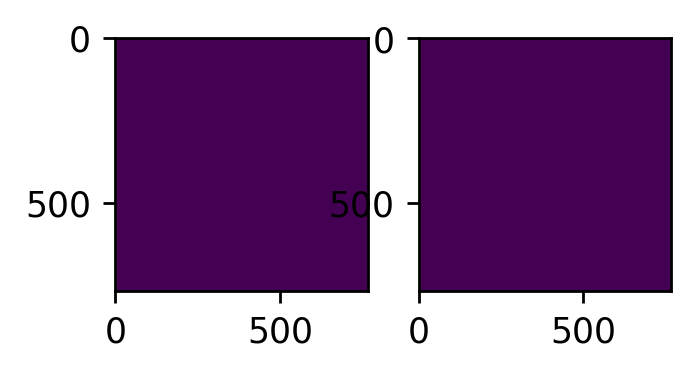

463


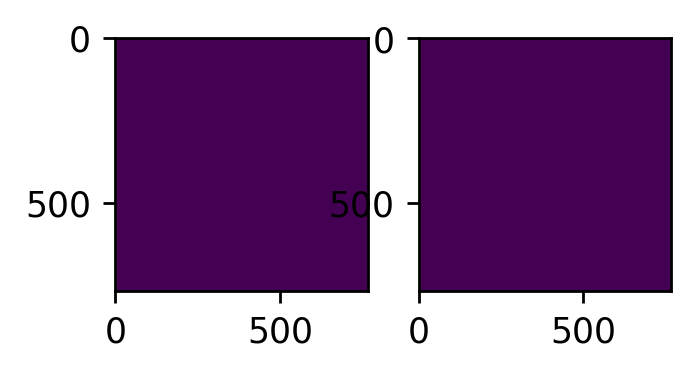

464


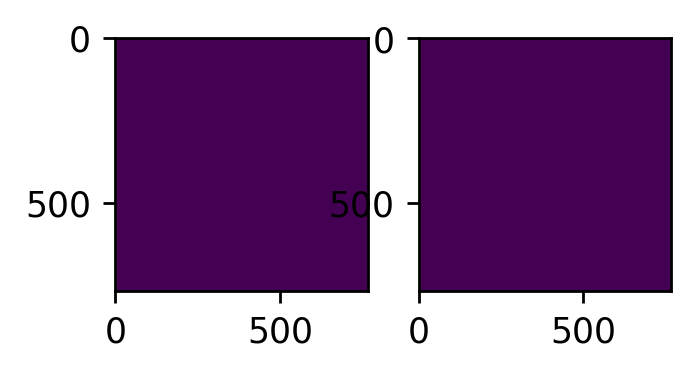

465


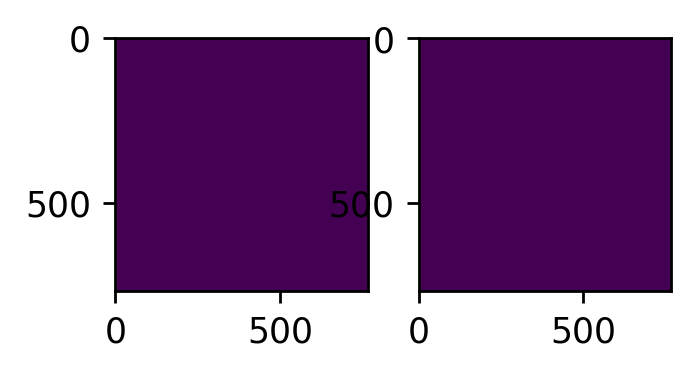

466


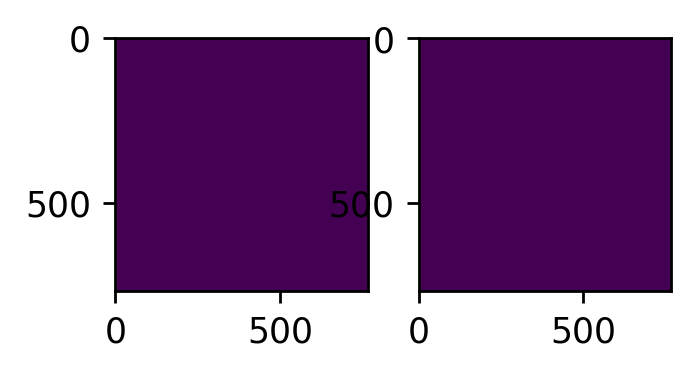

467


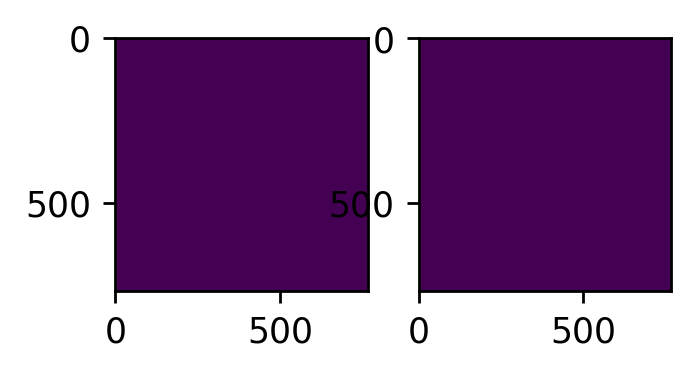

468


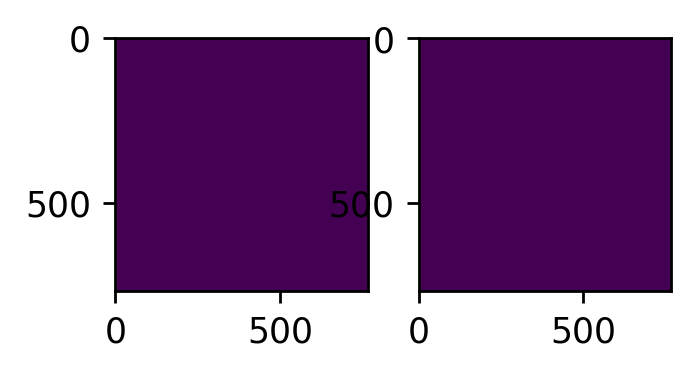

469


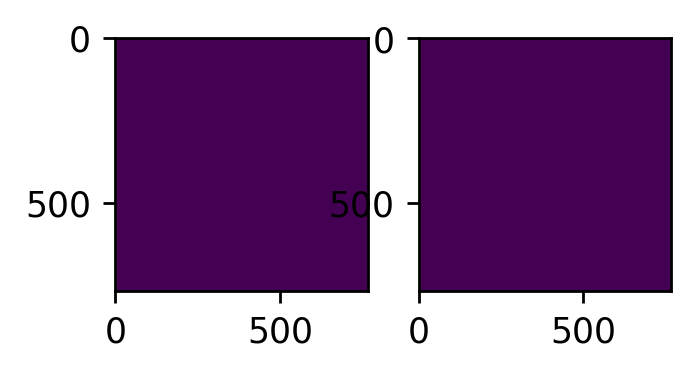

470


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-1bceddc4e2af>", line 20, in <module>
    plt.show()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py", line 254, in show
    return _show(*args, **kw)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 36, in show
    display(figure_manager.canvas.figure)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/display.py", line 298, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "<decorator-g

KeyboardInterrupt: 

In [9]:
for i in range(len(op2)):
#     print(np.unique(y_val[i]))
#     print(np.unique(np.argmax(op2[i],axis=-1)))
    print (i)
    plt.figure(dpi=250)
    plt.subplot(1,4,1)
    plt.imshow((y_val[i][:,:,0]*255).astype('uint8'))
#     plt.imshow((x_val[i][:,:,0]*255).astype('uint8'))
#     plt.subplot(1,4,2)
#     plt.imshow((y_val[i][:,:,0]*255).astype('uint8'))
#     plt.subplot(1,4,3)
#     plt.imshow(x_val[i][:,:,0])
    # plt.imshow(op2[i][:,:,1])
    plt.subplot(1,4,2)
    new_mask=op2[i][:,:,0]>0.5
    new_mask=(new_mask*255).astype('uint8')
    plt.imshow(new_mask)
#     plt.subplot(1,4,4)
#     plt.imshow(np.argmax(op2[i],axis=-1))
    plt.show()

In [11]:
# i=25
tp=0
stack=[]

for i in range(len(op2)):
    if np.max(y_val[i])>0.5:
        stack.append(dice_score(y_val[i],np.where(op2[i][:,:,0]>0.5,1,0)))
        if np.max(op2[i,:,:,0])>0.5:
            tp=tp+1
    print (i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
np.average(stack)

0.4004358669233272

In [8]:
y_pred=[]
for idx, i in enumerate(op2):
    if np.max(i)>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
    print (idx)
        
test=[]
for i in y_val:
    if np.max(i)>0:
        test.append(1)
    else:
        test.append(0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test, y_pred)

array([[966,  34],
       [ 38, 226]])

In [10]:
from sklearn.metrics import classification_report
print (classification_report(test, y_pred, target_names=['Healthy', 'Edema']))

              precision    recall  f1-score   support

     Healthy       0.96      0.97      0.96      1000
       Edema       0.87      0.86      0.86       264

    accuracy                           0.94      1264
   macro avg       0.92      0.91      0.91      1264
weighted avg       0.94      0.94      0.94      1264



In [ ]:
len(x_val)

# Test Set 1 

In [8]:
df_test=pd.read_csv('./CSV/test.csv')
df_test.head()

Unnamed: 0                   filepaths  labels
0           0  chexpert_087443_021001.jpg       1
1           1  mimic_0231806_16127152.jpg       1
2           2  mimic_0114534_13051530.jpg       1
3           3  mimic_0135980_13613571.jpg       1
4           4  mimic_0260405_16914073.jpg       1

## Positive samples

In [30]:
x_test=np.load('./Numpy/x_test.npy')
y_test=np.load('./Numpy/y_test.npy')

In [31]:
x_test_2=np.zeros(x_test.shape, dtype='float16')
for idx, i in enumerate(x_test):
    x_test_2[idx]=i.astype('float16')/255
    print (idx)
print (x_test_2[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[[[0.00784 0.00784 0.00784]
  [0.00784 0.00784 0.00784]
  [0.00784 0.00784 0.00784]
  ...
  [0.00784 0.00784 0.00784]
  [0.00784 0.00784 0.00784]
  [0.00784 0.00784 0.00784]]

 [[0.00784 0.00784 0.00784]
  [0.00784 0.00784 0.00784]
  [0.00784 0.00784 0.00784]
  ...
  [0.00784 0.00784 0.00784]
  [0.00784 0.007

In [32]:
y_test=y_test.astype('float16')/255

In [33]:
y_test=np.expand_dims(y_test,axis=-1)
y_test[y_test>0.]=1

In [37]:
op2=model.predict(x_test_2,verbose=1,batch_size=2)

200/200 [==============================] - 30s 152ms/step


In [38]:
tp=0
stack=[]

for i in range(len(op2)):
    if np.max(y_test[i])>0.5:
        stack.append(dice_score(y_test[i],np.where(op2[i][:,:,0]>0.5,1,0)))
        if np.max(op2[i,:,:,0])>0.5:
            tp=tp+1
    print (i)
    
print ("TP:", tp)
print ("Total Positives:", len(op2))
print ("Recall:", float(tp)/len(op2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
TP: 180
Total Positives: 200
Recall: 0.9


In [15]:
np.average(stack)

0.41544723489774327

## Negative samples

In [16]:
filenames=list(df_test['filepaths'])
labels=list(df_test['labels'])

In [20]:
y_pred=[]
test=labels[200:]
for idx, i in enumerate(filenames[200:]):
    print (idx)
    image=cv2.imread(i)
    image=cv2.resize(image, (768,768))
    image=image.astype('float16')/255
    pred=model.predict(np.expand_dims(image, axis=0), verbose=1)
    
    if np.max(pred[0])>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

0
1/1 [==============================] - 3s 3s/step
1
1/1 [==============================] - 0s 171ms/step
2
1/1 [==============================] - 0s 169ms/step
3
1/1 [==============================] - 0s 177ms/step
4
1/1 [==============================] - 0s 170ms/step
5
1/1 [==============================] - 0s 169ms/step
6
1/1 [==============================] - 0s 173ms/step
7
1/1 [==============================] - 0s 168ms/step
8
1/1 [==============================] - 0s 168ms/step
9
1/1 [==============================] - 0s 168ms/step
10
1/1 [==============================] - 0s 167ms/step
11
1/1 [==============================] - 0s 168ms/step
12
1/1 [==============================] - 0s 169ms/step
13
1/1 [==============================] - 0s 169ms/step
14
1/1 [==============================] - 0s 168ms/step
15
1/1 [==============================] - 0s 169ms/step
16
1/1 [==============================] - 0s 166ms/step
17
1/1 [==============================] - 0s 170ms/step
18
1/

146
1/1 [==============================] - 0s 175ms/step
147
1/1 [==============================] - 0s 172ms/step
148
1/1 [==============================] - 0s 174ms/step
149
1/1 [==============================] - 0s 171ms/step
150
1/1 [==============================] - 0s 173ms/step
151
1/1 [==============================] - 0s 175ms/step
152
1/1 [==============================] - 0s 170ms/step
153
1/1 [==============================] - 0s 170ms/step
154
1/1 [==============================] - 0s 171ms/step
155
1/1 [==============================] - 0s 172ms/step
156
1/1 [==============================] - 0s 172ms/step
157
1/1 [==============================] - 0s 171ms/step
158
1/1 [==============================] - 0s 175ms/step
159
1/1 [==============================] - 0s 173ms/step
160
1/1 [==============================] - 0s 173ms/step
161
1/1 [==============================] - 0s 173ms/step
162
1/1 [==============================] - 0s 172ms/step
163
1/1 [======================

290
1/1 [==============================] - 0s 174ms/step
291
1/1 [==============================] - 0s 174ms/step
292
1/1 [==============================] - 0s 175ms/step
293
1/1 [==============================] - 0s 175ms/step
294
1/1 [==============================] - 0s 168ms/step
295
1/1 [==============================] - 0s 176ms/step
296
1/1 [==============================] - 0s 174ms/step
297
1/1 [==============================] - 0s 177ms/step
298
1/1 [==============================] - 0s 174ms/step
299
1/1 [==============================] - 0s 177ms/step
300
1/1 [==============================] - 0s 173ms/step
301
1/1 [==============================] - 0s 177ms/step
302
1/1 [==============================] - 0s 175ms/step
303
1/1 [==============================] - 0s 176ms/step
304
1/1 [==============================] - 0s 175ms/step
305
1/1 [==============================] - 0s 175ms/step
306
1/1 [==============================] - 0s 176ms/step
307
1/1 [======================

434
1/1 [==============================] - 0s 178ms/step
435
1/1 [==============================] - 0s 176ms/step
436
1/1 [==============================] - 0s 180ms/step
437
1/1 [==============================] - 0s 179ms/step
438
1/1 [==============================] - 0s 176ms/step
439
1/1 [==============================] - 0s 180ms/step
440
1/1 [==============================] - 0s 174ms/step
441
1/1 [==============================] - 0s 179ms/step
442
1/1 [==============================] - 0s 180ms/step
443
1/1 [==============================] - 0s 179ms/step
444
1/1 [==============================] - 0s 178ms/step
445
1/1 [==============================] - 0s 177ms/step
446
1/1 [==============================] - 0s 175ms/step
447
1/1 [==============================] - 0s 174ms/step
448
1/1 [==============================] - 0s 179ms/step
449
1/1 [==============================] - 0s 176ms/step
450
1/1 [==============================] - 0s 179ms/step
451
1/1 [======================

578
1/1 [==============================] - 0s 179ms/step
579
1/1 [==============================] - 0s 181ms/step
580
1/1 [==============================] - 0s 180ms/step
581
1/1 [==============================] - 0s 183ms/step
582
1/1 [==============================] - 0s 181ms/step
583
1/1 [==============================] - 0s 180ms/step
584
1/1 [==============================] - 0s 177ms/step
585
1/1 [==============================] - 0s 178ms/step
586
1/1 [==============================] - 0s 181ms/step
587
1/1 [==============================] - 0s 179ms/step
588
1/1 [==============================] - 0s 180ms/step
589
1/1 [==============================] - 0s 177ms/step
590
1/1 [==============================] - 0s 182ms/step
591
1/1 [==============================] - 0s 179ms/step
592
1/1 [==============================] - 0s 182ms/step
593
1/1 [==============================] - 0s 184ms/step
594
1/1 [==============================] - 0s 184ms/step
595
1/1 [======================

722
1/1 [==============================] - 0s 186ms/step
723
1/1 [==============================] - 0s 182ms/step
724
1/1 [==============================] - 0s 184ms/step
725
1/1 [==============================] - 0s 178ms/step
726
1/1 [==============================] - 0s 184ms/step
727
1/1 [==============================] - 0s 184ms/step
728
1/1 [==============================] - 0s 182ms/step
729
1/1 [==============================] - 0s 177ms/step
730
1/1 [==============================] - 0s 183ms/step
731
1/1 [==============================] - 0s 183ms/step
732
1/1 [==============================] - 0s 183ms/step
733
1/1 [==============================] - 0s 185ms/step
734
1/1 [==============================] - 0s 185ms/step
735
1/1 [==============================] - 0s 187ms/step
736
1/1 [==============================] - 0s 182ms/step
737
1/1 [==============================] - 0s 180ms/step
738
1/1 [==============================] - 0s 183ms/step
739
1/1 [======================

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test, y_pred)

array([[800]])